In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm

In [60]:
fontsize_axis_labels = 16
fontsize_legend = 12

In [61]:
pip install torchview

In [62]:
!pip install torchcam

In [63]:
!python -m pip install git+https://github.com/garrettj403/SciencePlots.git
import scienceplots
plt.style.use(['science','no-latex'])
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

  Cloning https://github.com/garrettj403/SciencePlots.git to /tmp/pip-req-build-cruuf3fw
  Running command git clone --filter=blob:none --quiet https://github.com/garrettj403/SciencePlots.git /tmp/pip-req-build-cruuf3fw
  Resolved https://github.com/garrettj403/SciencePlots.git to commit 57571653751ce9cb0069a8d89706817c46fa8716
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
train_set = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/train_set.pt')
val_set = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/val_set.pt')
test_set = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/test_set.pt')

train_labels = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/train_labels.pt')
val_labels = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/val_labels.pt')
test_labels = torch.load('/content/drive/MyDrive/Datasets/Deep Learning Coursework Dataset/test_labels.pt')

In [66]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

3738
1636
1155


In [67]:
train_set = train_set.to(torch.float32)
val_set = val_set.to(torch.float32)
test_set = test_set.to(torch.float32)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

<ipython-input-67-44776335c39b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-67-44776335c39b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels)
<ipython-input-67-44776335c39b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [68]:
train_dataset = TensorDataset(train_set, train_labels)
val_dataset = TensorDataset(val_set, val_labels)
test_dataset = TensorDataset(test_set, test_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

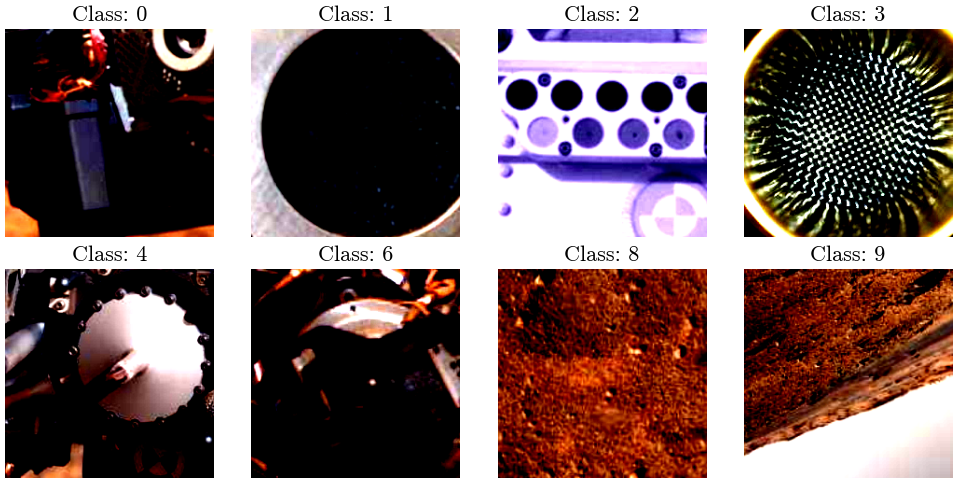

In [69]:
# prompt: create a 2x4 sample of images in the test set with unqiue classes in each image. increase font size

import matplotlib.pyplot as plt
import numpy as np

# Assuming test_set and test_labels are defined as in your provided code

# Find unique classes in the test set
unique_classes = np.unique(test_labels)

# Create a 2x4 grid for displaying images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # Increased figure size

# Iterate through the subplots
for i in range(2):
    for j in range(4):
        # Select an image with a unique class
        class_index = (i * 4 + j) % len(unique_classes)
        class_label = unique_classes[class_index]

        # Find the index of the first image with the selected class
        image_index = np.where(test_labels == class_label)[0][0]

        # Display the image
        axes[i, j].imshow(np.transpose(test_set[image_index].numpy(), (1, 2, 0))) # Assuming image data is in (C, H, W) format
        axes[i, j].set_title(f"Class: {class_label}", fontsize=fontsize_axis_labels) # Use the defined fontsize
        axes[i, j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


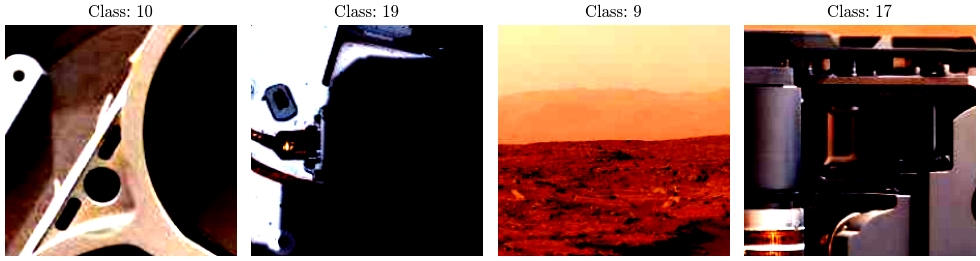

In [70]:
import matplotlib.pyplot as plt
import random

unique_labels = sorted(list(set(train_labels.tolist())))

# Select a random sample of images from each class
num_classes_to_show = min(4, len(unique_labels)) # Show up to 5 classes
sampled_images = []
sampled_labels = []

for label in random.sample(unique_labels, num_classes_to_show):
    # Find all indices with the current label
    indices_with_label = [i for i, x in enumerate(train_labels) if x == label]
    # Select a random image with the current label
    random_index = random.choice(indices_with_label)
    sampled_images.append(train_set[random_index])
    sampled_labels.append(train_labels[random_index])


# Display the images
plt.figure(figsize=(10, 5))
for i in range(num_classes_to_show):
  plt.subplot(1, num_classes_to_show, i + 1)
  plt.imshow(sampled_images[i].permute(1, 2, 0))
  plt.title(f"Class: {sampled_labels[i]}")
  plt.axis('off')

plt.tight_layout()
plt.show()


## Functions

In [71]:
def train_model(model, train, val, scheduler, epochs, patience):
  results = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
  count = 0
  for epoch in range(epochs):
    train_acc, train_loss = train_loop(model, train, epoch)
    val_acc = val_loop(model, val, scheduler, epoch)
    results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)
    if (patience > 0):
      if (val_acc < results["Validation Accuracy"].max()):
        count += 1
        print(f"Early stopping count: {count}\n")
      else:
        count = 0
      if (count == patience):
        print("Early stopping triggered")
        break
  return results

In [72]:
def train_loop(model, loader, epoch):
  model.train()
  total_loss = 0.0
  correct, total = 0, 0

  for images, labels in tqdm(loader, desc=f"Epoch {epoch+1} - Training", leave=False):
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criteria(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  train_acc = 100 * correct / total
  train_loss = total_loss / len(loader)
  print(f"Training Accuracy: {train_acc:.2f}%\n")
  return train_acc, train_loss

In [73]:
def val_loop(model, loader, scheduler, epoch):
  model.eval()
  val_correct, val_total = 0, 0
  with torch.no_grad():
      for images, labels in loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          val_correct += (predicted == labels).sum().item()
          val_total += labels.size(0)

  val_acc = 100 * val_correct / val_total
  scheduler.step(val_acc)
  print(f"Validation Accuracy: {val_acc:.2f}%\n")
  return val_acc

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Initial Model

In [75]:
initial_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(initial_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
initial_model = initial_model.to(device)

initial_results = train_model(initial_model, train_loader, val_loader, scheduler, 1000, 15)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 73.52%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 28.55%



Training Accuracy: 83.39%

Validation Accuracy: 22.37%

Early stopping count: 1



Training Accuracy: 86.86%

Validation Accuracy: 41.44%



Training Accuracy: 89.78%

Validation Accuracy: 41.69%



Training Accuracy: 91.49%

Validation Accuracy: 56.54%



Training Accuracy: 92.59%

Validation Accuracy: 55.07%

Early stopping count: 1



Training Accuracy: 93.53%

Validation Accuracy: 60.51%



Training Accuracy: 93.87%

Validation Accuracy: 57.64%

Early stopping count: 1



Training Accuracy: 94.49%

Validation Accuracy: 56.60%

Early stopping count: 2



Training Accuracy: 95.02%

Validation Accuracy: 60.88%



Training Accuracy: 94.62%

Validation Accuracy: 58.68%

Early stopping count: 1



Training Accuracy: 94.89%

Validation Accuracy: 58.99%

Early stopping count: 2



Training Accuracy: 95.51%

Validation Accuracy: 58.62%

Early stopping count: 3



Training Accuracy: 95.69%

Validation Accuracy: 58.99%

Early stopping count: 4



Training Accuracy: 96.36%

Validation Accuracy: 60.51%

Early stopping count: 5



Training Accuracy: 96.82%

Validation Accuracy: 61.86%



Training Accuracy: 97.22%

Validation Accuracy: 61.61%

Early stopping count: 1



Training Accuracy: 97.16%

Validation Accuracy: 61.61%

Early stopping count: 2



Training Accuracy: 96.87%

Validation Accuracy: 62.22%



Training Accuracy: 97.08%

Validation Accuracy: 61.00%

Early stopping count: 1



Training Accuracy: 97.32%

Validation Accuracy: 61.00%

Early stopping count: 2



Training Accuracy: 97.46%

Validation Accuracy: 61.37%

Early stopping count: 3



Training Accuracy: 97.65%

Validation Accuracy: 62.29%



Training Accuracy: 97.62%

Validation Accuracy: 61.98%

Early stopping count: 1



Training Accuracy: 97.62%

Validation Accuracy: 61.92%

Early stopping count: 2



Training Accuracy: 97.41%

Validation Accuracy: 61.25%

Early stopping count: 3



Training Accuracy: 97.91%

Validation Accuracy: 61.80%

Early stopping count: 4



Training Accuracy: 97.83%

Validation Accuracy: 61.86%

Early stopping count: 5



Training Accuracy: 98.13%

Validation Accuracy: 61.67%

Early stopping count: 6



Training Accuracy: 97.97%

Validation Accuracy: 61.49%

Early stopping count: 7



Training Accuracy: 98.13%

Validation Accuracy: 61.61%

Early stopping count: 8



Training Accuracy: 98.07%

Validation Accuracy: 61.61%

Early stopping count: 9



Training Accuracy: 97.78%

Validation Accuracy: 61.67%

Early stopping count: 10



Training Accuracy: 98.10%

Validation Accuracy: 61.67%

Early stopping count: 11



Training Accuracy: 97.73%

Validation Accuracy: 61.61%

Early stopping count: 12



Training Accuracy: 97.65%

Validation Accuracy: 61.61%

Early stopping count: 13



Training Accuracy: 98.07%

Validation Accuracy: 61.61%

Early stopping count: 14



Training Accuracy: 97.81%

Validation Accuracy: 61.61%

Early stopping count: 15

Early stopping triggered


In [76]:
initial_results

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,1.199310,73.515249,0,28.545232
1,2,0.566173,83.386838,0,22.371638
2,3,0.422494,86.864633,0,41.442543
3,4,0.325521,89.780631,0,41.687042
4,5,0.267259,91.492777,0,56.540342
5,6,0.226865,92.589620,0,55.073350
6,7,0.200475,93.525950,0,60.513447
7,8,0.185836,93.873729,0,57.640587
8,9,0.163567,94.489032,0,56.601467
9,10,0.158339,95.024077,0,60.880196


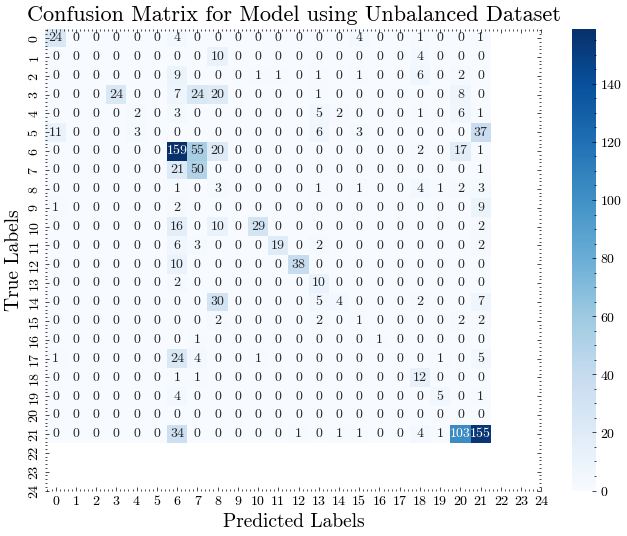

              precision    recall  f1-score   support

           0       0.65      0.71      0.68        34
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        21
           3       1.00      0.29      0.44        84
           4       0.40      0.10      0.16        20
           6       0.00      0.00      0.00        60
           8       0.52      0.63      0.57       254
           9       0.36      0.69      0.48        72
          10       0.03      0.19      0.05        16
          11       0.00      0.00      0.00        12
          12       0.94      0.51      0.66        57
          13       0.95      0.59      0.73        32
          14       0.97      0.79      0.87        48
          15       0.30      0.83      0.44        12
          16       0.57      0.08      0.15        48
          17       0.09      0.11      0.10         9
          18       1.00      0.50      0.67         2
          19       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [77]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = initial_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(25), yticklabels=range(25))
plt.title("Confusion Matrix for Model using Unbalanced Dataset", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

## Reshuffled datasets

Due to mismatching classes between sets they were remerged and split with classes distributed evenly

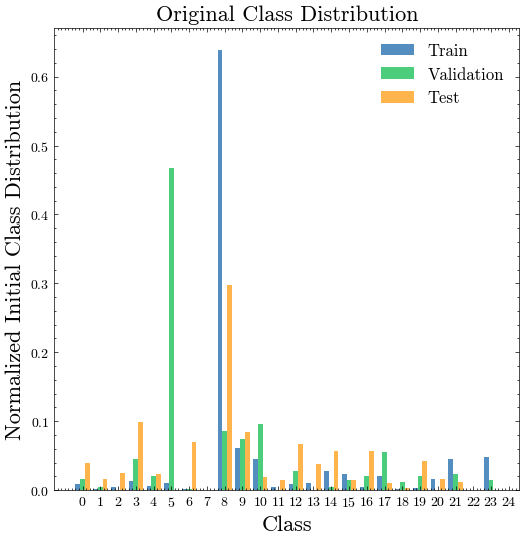

In [78]:
orig_train_class_counts = train_labels.numpy()
orig_val_class_counts = val_labels.numpy()
orig_test_class_counts = test_labels.numpy()

plt.figure(figsize=(6, 6))

plt.hist([train_labels.numpy(), val_labels.numpy(), test_labels.numpy()],
         bins=np.arange(25) - 0.5,
         label=['Train', 'Validation', 'Test'],
         density=True,  # Normalize the histograms
         alpha=0.7)

plt.xlabel('Class', fontsize=fontsize_axis_labels)
plt.ylabel('Normalized Initial Class Distribution', fontsize=fontsize_axis_labels)
plt.title('Original Class Distribution', fontsize=fontsize_axis_labels)
plt.legend(fontsize=fontsize_legend)
plt.xticks(range(25))
plt.show()

In [79]:
merged_set = torch.cat((train_set, val_set, test_set), dim=0)
merged_labels = torch.cat((train_labels, val_labels, test_labels), dim=0)
merged_dataset = TensorDataset(merged_set, merged_labels)

In [80]:
merged_set = torch.cat((train_set, val_set, test_set), dim=0)
merged_labels = torch.cat((train_labels, val_labels, test_labels), dim=0)
merged_dataset = TensorDataset(merged_set, merged_labels)

del train_set, val_set, test_set, train_labels, val_labels, test_labels

train_val_set, test_set, train_val_labels, test_labels = train_test_split(
    merged_set, merged_labels, test_size=0.2, stratify=merged_labels, random_state=42
)
train_set, val_set, train_labels, val_labels = train_test_split(
    train_val_set, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
)

In [81]:
train_dataset = TensorDataset(train_set, train_labels)
val_dataset = TensorDataset(val_set, val_labels)
test_dataset = TensorDataset(test_set, test_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

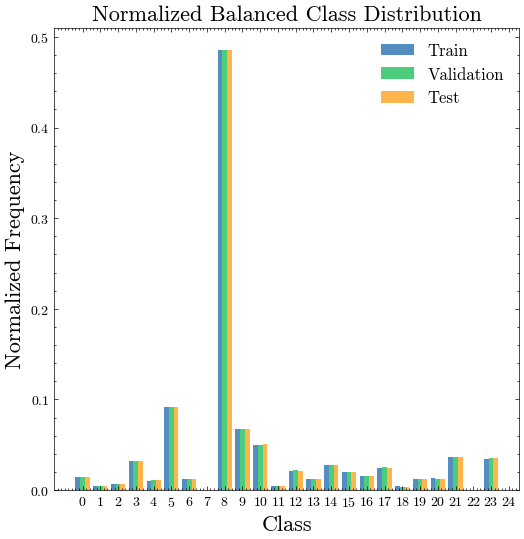

In [82]:
train_class_counts = Counter(train_labels.tolist())
val_class_counts = Counter(val_labels.tolist())
test_class_counts = Counter(test_labels.tolist())

plt.figure(figsize=(6, 6))

plt.hist([train_labels.numpy(), val_labels.numpy(), test_labels.numpy()],
         bins=np.arange(25) - 0.5,
         label=['Train', 'Validation', 'Test'],
         density=True,  # Normalize the histograms
         alpha=0.7)

plt.xlabel('Class', fontsize=fontsize_axis_labels)
plt.ylabel('Normalized Frequency', fontsize=fontsize_axis_labels)
plt.title('Normalized Balanced Class Distribution', fontsize=fontsize_axis_labels)
plt.legend(fontsize=fontsize_legend)
plt.xticks(range(25))
plt.show()

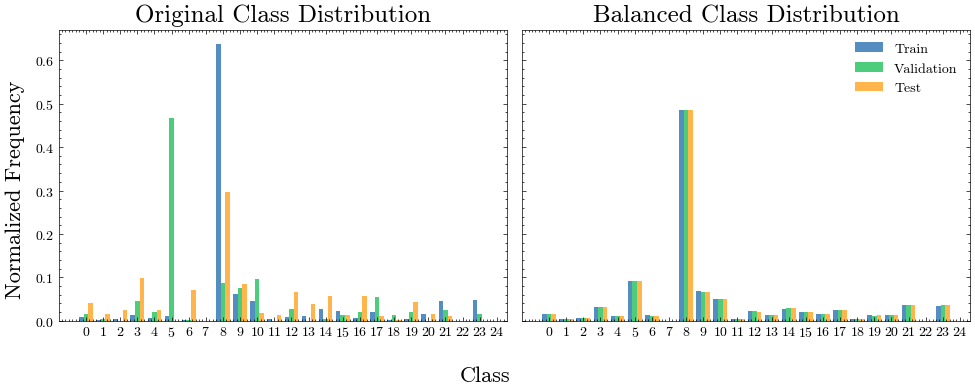

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Balanced class distribution
ax[1].hist([train_labels.numpy(), val_labels.numpy(), test_labels.numpy()],
           bins=np.arange(25) - 0.5,
           label=['Train', 'Validation', 'Test'],
           density=True,
           alpha=0.7)
ax[1].set_title('Balanced Class Distribution', fontsize=18)
ax[1].set_xticks(np.arange(25))
ax[1].tick_params(axis='x', labelsize=10)
ax[1].legend()

# Original class distribution
ax[0].hist([orig_train_class_counts, orig_val_class_counts, orig_test_class_counts],
           bins=np.arange(25) - 0.5,
           label=['Train', 'Validation', 'Test'],
           density=True,
           alpha=0.7)
ax[0].set_title('Original Class Distribution', fontsize=18)
ax[0].set_xticks(np.arange(25))
ax[0].tick_params(axis='x', labelsize=10)

fig.supxlabel('Class', fontsize=16)
fig.supylabel('Normalized Frequency', fontsize=16)
plt.tight_layout()
plt.show()

In [84]:
shuffled_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shuffled_model.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
shuffled_model = shuffled_model.to(device)

shuffled_results = train_model(shuffled_model, train_loader, val_loader, scheduler, 100, 15)

Using device: cuda


Training Accuracy: 62.62%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 74.27%



Training Accuracy: 74.62%

Validation Accuracy: 80.86%



Training Accuracy: 81.67%

Validation Accuracy: 85.30%



Training Accuracy: 84.68%

Validation Accuracy: 88.28%



Training Accuracy: 86.98%

Validation Accuracy: 91.04%



Training Accuracy: 88.95%

Validation Accuracy: 91.27%



Training Accuracy: 90.32%

Validation Accuracy: 92.73%



Training Accuracy: 91.68%

Validation Accuracy: 93.57%



Training Accuracy: 92.24%

Validation Accuracy: 93.49%

Early stopping count: 1



Training Accuracy: 92.52%

Validation Accuracy: 93.19%

Early stopping count: 2



Training Accuracy: 93.16%

Validation Accuracy: 94.10%



Training Accuracy: 93.52%

Validation Accuracy: 94.33%



Training Accuracy: 94.23%

Validation Accuracy: 94.49%



Training Accuracy: 93.75%

Validation Accuracy: 94.95%



Training Accuracy: 94.36%

Validation Accuracy: 94.56%

Early stopping count: 1



Training Accuracy: 95.07%

Validation Accuracy: 94.79%

Early stopping count: 2



Training Accuracy: 95.30%

Validation Accuracy: 94.79%

Early stopping count: 3



Training Accuracy: 95.46%

Validation Accuracy: 94.95%



Training Accuracy: 95.89%

Validation Accuracy: 95.10%



Training Accuracy: 96.45%

Validation Accuracy: 95.18%



Training Accuracy: 96.30%

Validation Accuracy: 94.79%

Early stopping count: 1



Training Accuracy: 96.63%

Validation Accuracy: 94.95%

Early stopping count: 2



Training Accuracy: 96.73%

Validation Accuracy: 95.02%

Early stopping count: 3



Training Accuracy: 96.43%

Validation Accuracy: 94.56%

Early stopping count: 4



Training Accuracy: 96.81%

Validation Accuracy: 95.48%



Training Accuracy: 96.78%

Validation Accuracy: 94.95%

Early stopping count: 1



Training Accuracy: 97.27%

Validation Accuracy: 95.10%

Early stopping count: 2



Training Accuracy: 96.86%

Validation Accuracy: 95.41%

Early stopping count: 3



Training Accuracy: 96.89%

Validation Accuracy: 94.64%

Early stopping count: 4



Training Accuracy: 97.19%

Validation Accuracy: 95.71%



Training Accuracy: 97.47%

Validation Accuracy: 95.18%

Early stopping count: 1



Training Accuracy: 96.81%

Validation Accuracy: 95.41%

Early stopping count: 2



Training Accuracy: 97.93%

Validation Accuracy: 95.48%

Early stopping count: 3



Training Accuracy: 97.86%

Validation Accuracy: 95.33%

Early stopping count: 4



Training Accuracy: 97.65%

Validation Accuracy: 95.87%



Training Accuracy: 97.80%

Validation Accuracy: 95.25%

Early stopping count: 1



Training Accuracy: 97.86%

Validation Accuracy: 95.79%

Early stopping count: 2



Training Accuracy: 97.73%

Validation Accuracy: 95.33%

Early stopping count: 3



Training Accuracy: 97.50%

Validation Accuracy: 95.48%

Early stopping count: 4



Training Accuracy: 97.75%

Validation Accuracy: 95.64%

Early stopping count: 5



Training Accuracy: 97.65%

Validation Accuracy: 95.48%

Early stopping count: 6



Training Accuracy: 98.06%

Validation Accuracy: 95.33%

Early stopping count: 7



Training Accuracy: 97.80%

Validation Accuracy: 95.10%

Early stopping count: 8



Training Accuracy: 97.91%

Validation Accuracy: 95.02%

Early stopping count: 9



Training Accuracy: 98.32%

Validation Accuracy: 95.87%



Training Accuracy: 98.49%

Validation Accuracy: 95.87%



Training Accuracy: 98.16%

Validation Accuracy: 94.95%

Early stopping count: 1



Training Accuracy: 98.42%

Validation Accuracy: 95.18%

Early stopping count: 2



Training Accuracy: 98.62%

Validation Accuracy: 95.33%

Early stopping count: 3



Training Accuracy: 98.47%

Validation Accuracy: 95.33%

Early stopping count: 4



Training Accuracy: 98.24%

Validation Accuracy: 95.18%

Early stopping count: 5



Training Accuracy: 98.42%

Validation Accuracy: 95.56%

Early stopping count: 6



Training Accuracy: 98.16%

Validation Accuracy: 95.48%

Early stopping count: 7



Training Accuracy: 98.54%

Validation Accuracy: 96.02%



Training Accuracy: 98.54%

Validation Accuracy: 95.79%

Early stopping count: 1



Training Accuracy: 98.34%

Validation Accuracy: 94.87%

Early stopping count: 2



Training Accuracy: 97.98%

Validation Accuracy: 95.79%

Early stopping count: 3



Training Accuracy: 98.39%

Validation Accuracy: 95.02%

Early stopping count: 4



Training Accuracy: 98.52%

Validation Accuracy: 95.94%

Early stopping count: 5



Training Accuracy: 98.44%

Validation Accuracy: 95.48%

Early stopping count: 6



Training Accuracy: 98.44%

Validation Accuracy: 95.64%

Early stopping count: 7



Training Accuracy: 98.83%

Validation Accuracy: 95.64%

Early stopping count: 8



Training Accuracy: 98.72%

Validation Accuracy: 94.10%

Early stopping count: 9



Training Accuracy: 97.83%

Validation Accuracy: 95.33%

Early stopping count: 10



Training Accuracy: 99.00%

Validation Accuracy: 95.56%

Early stopping count: 11



Training Accuracy: 98.29%

Validation Accuracy: 95.33%

Early stopping count: 12



Training Accuracy: 98.60%

Validation Accuracy: 95.56%

Early stopping count: 13



Training Accuracy: 98.88%

Validation Accuracy: 95.64%

Early stopping count: 14



Training Accuracy: 98.65%

Validation Accuracy: 95.71%

Early stopping count: 15

Early stopping triggered


In [85]:
shuffled_results

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,1.467548,62.624457,0,74.272588
1,2,0.906074,74.623436,0,80.857580
2,3,0.662168,81.669645,0,85.298622
3,4,0.555195,84.682155,0,88.284839
4,5,0.450144,86.979832,0,91.041348
...,...,...,...,...,...
64,65,0.035278,99.004340,0,95.558959
65,66,0.050759,98.289507,0,95.329250
66,67,0.042474,98.595864,0,95.558959
67,68,0.040535,98.876691,0,95.635528


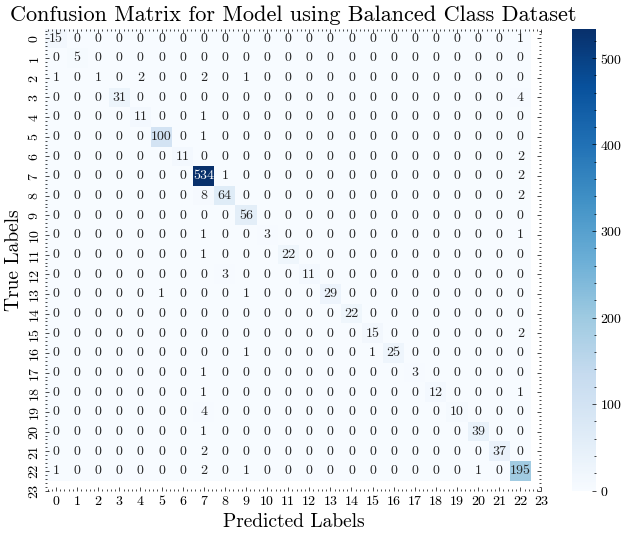

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       1.00      1.00      1.00         5
           2       1.00      0.14      0.25         7
           3       1.00      0.89      0.94        35
           4       0.85      0.92      0.88        12
           5       0.99      0.99      0.99       101
           6       1.00      0.85      0.92        13
           8       0.96      0.99      0.97       537
           9       0.94      0.86      0.90        74
          10       0.93      1.00      0.97        56
          11       1.00      0.60      0.75         5
          12       1.00      0.96      0.98        23
          13       1.00      0.79      0.88        14
          14       1.00      0.94      0.97        31
          15       1.00      1.00      1.00        22
          16       0.94      0.88      0.91        17
          17       1.00      0.93      0.96        27
          18       1.00    

In [86]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = shuffled_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix for Model using Balanced Class Dataset", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

## Weighted Model
Accuracy is high at 95% when class imbalance is not taken into account, but lower when a balanced accuracy is used with balanced accuracy only 7% lower at 88%. Attempting to use weighted model to improve balanced accuracy

In [87]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

unique_labels = np.unique(train_labels)
train_labels_int = [int(label.item()) for label in train_labels]
unique_labels_int = np.unique(train_labels_int)

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_int, y=train_labels_int)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [88]:
#class weights missing last 2 weights. Not sure why
class_weights = torch.cat((class_weights, torch.tensor([1.0]).to(device)))
class_weights = torch.cat((class_weights, torch.tensor([1.0]).to(device)))

In [89]:
len(class_weights)

25

In [90]:
weighted_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)


criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(weighted_model.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
weighted_model = weighted_model.to(device)

weighted_results = train_model(weighted_model, train_loader, val_loader, scheduler, 100, 3)

Using device: cuda


Training Accuracy: 52.62%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 68.84%



Training Accuracy: 68.55%

Validation Accuracy: 78.64%



Training Accuracy: 76.44%

Validation Accuracy: 82.16%



Training Accuracy: 80.16%

Validation Accuracy: 88.28%



Training Accuracy: 85.45%

Validation Accuracy: 89.89%



Training Accuracy: 88.10%

Validation Accuracy: 90.12%



Training Accuracy: 89.74%

Validation Accuracy: 91.58%



Training Accuracy: 91.73%

Validation Accuracy: 93.42%



Training Accuracy: 91.58%

Validation Accuracy: 92.88%

Early stopping count: 1



Training Accuracy: 93.64%

Validation Accuracy: 94.03%



Training Accuracy: 94.59%

Validation Accuracy: 93.34%

Early stopping count: 1



Training Accuracy: 93.72%

Validation Accuracy: 94.10%



Training Accuracy: 94.92%

Validation Accuracy: 93.34%

Early stopping count: 1



Training Accuracy: 94.77%

Validation Accuracy: 94.56%



Training Accuracy: 95.56%

Validation Accuracy: 93.03%

Early stopping count: 1



Training Accuracy: 95.02%

Validation Accuracy: 94.79%



Training Accuracy: 95.56%

Validation Accuracy: 95.02%



Training Accuracy: 96.96%

Validation Accuracy: 95.41%



Training Accuracy: 96.91%

Validation Accuracy: 95.10%

Early stopping count: 1



Training Accuracy: 97.04%

Validation Accuracy: 94.95%

Early stopping count: 2



Training Accuracy: 97.19%

Validation Accuracy: 95.48%



Training Accuracy: 97.32%

Validation Accuracy: 95.33%

Early stopping count: 1



Training Accuracy: 97.45%

Validation Accuracy: 94.95%

Early stopping count: 2



Training Accuracy: 96.78%

Validation Accuracy: 94.26%

Early stopping count: 3

Early stopping triggered


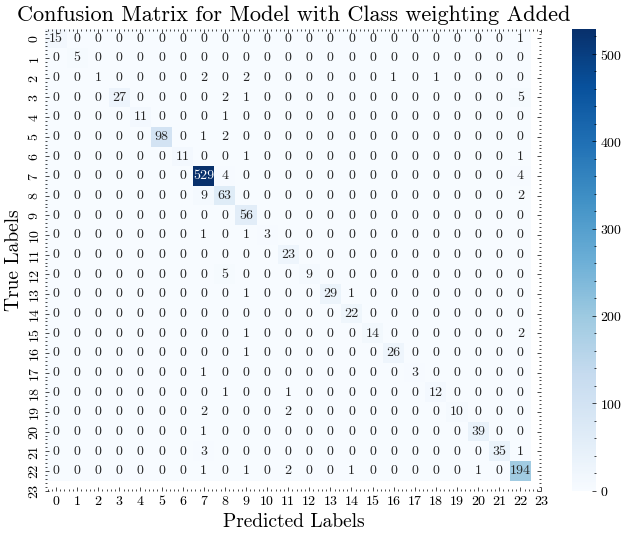

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       1.00      1.00      1.00         5
           2       1.00      0.14      0.25         7
           3       1.00      0.77      0.87        35
           4       1.00      0.92      0.96        12
           5       1.00      0.97      0.98       101
           6       1.00      0.85      0.92        13
           8       0.96      0.99      0.97       537
           9       0.81      0.85      0.83        74
          10       0.86      1.00      0.93        56
          11       1.00      0.60      0.75         5
          12       0.82      1.00      0.90        23
          13       1.00      0.64      0.78        14
          14       1.00      0.94      0.97        31
          15       0.92      1.00      0.96        22
          16       1.00      0.82      0.90        17
          17       0.96      0.96      0.96        27
          18       1.00    

In [91]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = weighted_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix for Model with Class weighting Added", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

In [92]:
max_val_acc_row = weighted_results.loc[weighted_results['Validation Accuracy'].idxmax()]
max_val_acc_row


,20
Epoch,21
Train Loss,0.078877
Train Accuracy,97.191728
Validation Loss,0
Validation Accuracy,95.482389


## Model Tuning

With a reasonably accuracte model established I decided to start tuning


In [ ]:
parameter_results = {}
params = {"decay":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7],
          "lr":[0.1,0.01,0.001,0.0001,0.00001]}

for decay in params["decay"]:
  for lr in params["lr"]:

    temp_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 56 * 56, 128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 25)
    )

    criteria = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(temp_model.parameters(), lr=lr, weight_decay=decay)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = temp_model.to(device)

    temp = train_model(temp_model, train_loader, val_loader, scheduler, 50, 3)
    temp = temp.loc[temp['Validation Accuracy'].idxmax()]

    print("Decay: ", decay, "Learning Rate: ", lr, "Train Accuracy: ", temp["Train Accuracy"].item(), "Train Loss: ", temp["Train Loss"].item(), "Validation Accuracy: ", temp["Validation Accuracy"].item())
    parameter_results[f"Decay: {decay}, Learning Rate: {lr}"] = [temp["Train Accuracy"].item(), temp["Train Loss"].item(), temp["Validation Accuracy"].item()]

Using device: cuda


Training Accuracy: 10.77%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 2.14%



Training Accuracy: 11.97%

Validation Accuracy: 4.21%



Training Accuracy: 11.77%

Validation Accuracy: 2.14%

Early stopping count: 1



Training Accuracy: 11.74%

Validation Accuracy: 41.12%



Training Accuracy: 11.54%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.10%

Validation Accuracy: 41.12%



Training Accuracy: 13.22%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 13.76%

Validation Accuracy: 2.14%

Early stopping count: 2



Training Accuracy: 9.14%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.1 Train Accuracy:  11.743681388817972 Train Loss:  6.710579782966676 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 31.12%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 40.35%



Training Accuracy: 36.30%

Validation Accuracy: 39.74%

Early stopping count: 1



Training Accuracy: 37.78%

Validation Accuracy: 38.13%

Early stopping count: 2



Training Accuracy: 41.49%

Validation Accuracy: 9.49%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.01 Train Accuracy:  31.12075568036763 Train Loss:  4.474537039190773 Validation Accuracy:  40.35222052067381
Using device: cuda


Training Accuracy: 49.27%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 53.52%



Training Accuracy: 57.03%

Validation Accuracy: 64.55%



Training Accuracy: 60.02%

Validation Accuracy: 67.84%



Training Accuracy: 60.68%

Validation Accuracy: 64.55%

Early stopping count: 1



Training Accuracy: 62.52%

Validation Accuracy: 67.38%

Early stopping count: 2



Training Accuracy: 62.39%

Validation Accuracy: 70.06%



Training Accuracy: 61.88%

Validation Accuracy: 69.07%

Early stopping count: 1



Training Accuracy: 62.68%

Validation Accuracy: 66.77%

Early stopping count: 2



Training Accuracy: 60.76%

Validation Accuracy: 69.30%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.001 Train Accuracy:  62.39468981363288 Train Loss:  1.4704426352570696 Validation Accuracy:  70.06125574272588
Using device: cuda


Training Accuracy: 50.83%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 65.39%



Training Accuracy: 62.11%

Validation Accuracy: 68.45%



Training Accuracy: 65.28%

Validation Accuracy: 72.74%



Training Accuracy: 68.75%

Validation Accuracy: 75.04%



Training Accuracy: 69.52%

Validation Accuracy: 75.04%



Training Accuracy: 71.71%

Validation Accuracy: 79.10%



Training Accuracy: 71.61%

Validation Accuracy: 77.87%

Early stopping count: 1



Training Accuracy: 74.98%

Validation Accuracy: 80.17%



Training Accuracy: 76.28%

Validation Accuracy: 80.70%



Training Accuracy: 75.54%

Validation Accuracy: 80.70%



Training Accuracy: 76.26%

Validation Accuracy: 85.53%



Training Accuracy: 78.12%

Validation Accuracy: 84.99%

Early stopping count: 1



Training Accuracy: 78.20%

Validation Accuracy: 82.77%

Early stopping count: 2



Training Accuracy: 79.37%

Validation Accuracy: 86.37%



Training Accuracy: 77.30%

Validation Accuracy: 81.16%

Early stopping count: 1



Training Accuracy: 79.81%

Validation Accuracy: 83.38%

Early stopping count: 2



Training Accuracy: 79.50%

Validation Accuracy: 85.07%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.0001 Train Accuracy:  79.37196834311973 Train Loss:  0.6696974338312459 Validation Accuracy:  86.37059724349157
Using device: cuda


Training Accuracy: 40.31%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 52.45%



Training Accuracy: 54.86%

Validation Accuracy: 58.42%



Training Accuracy: 59.31%

Validation Accuracy: 64.01%



Training Accuracy: 63.80%

Validation Accuracy: 71.82%



Training Accuracy: 67.48%

Validation Accuracy: 71.29%

Early stopping count: 1



Training Accuracy: 69.06%

Validation Accuracy: 73.81%



Training Accuracy: 72.22%

Validation Accuracy: 75.04%



Training Accuracy: 72.99%

Validation Accuracy: 77.72%



Training Accuracy: 75.06%

Validation Accuracy: 77.26%

Early stopping count: 1



Training Accuracy: 77.10%

Validation Accuracy: 79.86%



Training Accuracy: 77.43%

Validation Accuracy: 79.48%

Early stopping count: 1



Training Accuracy: 78.86%

Validation Accuracy: 82.54%



Training Accuracy: 79.78%

Validation Accuracy: 84.00%



Training Accuracy: 81.11%

Validation Accuracy: 84.92%



Training Accuracy: 80.06%

Validation Accuracy: 84.07%

Early stopping count: 1



Training Accuracy: 81.34%

Validation Accuracy: 86.29%



Training Accuracy: 81.26%

Validation Accuracy: 86.75%



Training Accuracy: 83.51%

Validation Accuracy: 86.45%

Early stopping count: 1



Training Accuracy: 83.46%

Validation Accuracy: 88.21%



Training Accuracy: 83.89%

Validation Accuracy: 86.06%

Early stopping count: 1



Training Accuracy: 84.99%

Validation Accuracy: 88.51%



Training Accuracy: 84.32%

Validation Accuracy: 84.23%

Early stopping count: 1



Training Accuracy: 84.68%

Validation Accuracy: 86.14%

Early stopping count: 2



Training Accuracy: 86.21%

Validation Accuracy: 88.59%



Training Accuracy: 85.93%

Validation Accuracy: 89.89%



Training Accuracy: 86.49%

Validation Accuracy: 90.28%



Training Accuracy: 87.49%

Validation Accuracy: 90.05%

Early stopping count: 1



Training Accuracy: 88.15%

Validation Accuracy: 89.89%

Early stopping count: 2



Training Accuracy: 87.59%

Validation Accuracy: 87.52%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  1e-05 Train Accuracy:  86.49476640285933 Train Loss:  0.4211085884551692 Validation Accuracy:  90.27565084226646
Using device: cuda


Training Accuracy: 9.09%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 17.26%

Validation Accuracy: 4.21%



Training Accuracy: 18.00%

Validation Accuracy: 4.21%



Training Accuracy: 17.54%

Validation Accuracy: 41.12%



Training Accuracy: 16.85%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 18.99%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 11.23%

Validation Accuracy: 41.12%



Training Accuracy: 17.49%

Validation Accuracy: 41.12%



Training Accuracy: 16.44%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 19.40%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 18.05%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.1 Train Accuracy:  17.538932856778146 Train Loss:  2.7054076427366676 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 12.61%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.12%



Training Accuracy: 14.40%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.74%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 12.46%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.01 Train Accuracy:  12.611692621904519 Train Loss:  5.442622128540908 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 52.82%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 68.30%



Training Accuracy: 70.39%

Validation Accuracy: 76.88%



Training Accuracy: 76.72%

Validation Accuracy: 84.23%



Training Accuracy: 79.91%

Validation Accuracy: 79.40%

Early stopping count: 1



Training Accuracy: 82.00%

Validation Accuracy: 85.53%



Training Accuracy: 84.58%

Validation Accuracy: 89.28%



Training Accuracy: 85.19%

Validation Accuracy: 80.63%

Early stopping count: 1



Training Accuracy: 84.81%

Validation Accuracy: 88.74%

Early stopping count: 2



Training Accuracy: 86.49%

Validation Accuracy: 86.22%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.001 Train Accuracy:  84.58003574163901 Train Loss:  0.5186162732723283 Validation Accuracy:  89.2802450229709
Using device: cuda


Training Accuracy: 51.72%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 69.75%



Training Accuracy: 67.99%

Validation Accuracy: 77.26%



Training Accuracy: 74.01%

Validation Accuracy: 79.02%



Training Accuracy: 77.18%

Validation Accuracy: 87.83%



Training Accuracy: 81.72%

Validation Accuracy: 84.23%

Early stopping count: 1



Training Accuracy: 82.69%

Validation Accuracy: 90.58%



Training Accuracy: 85.14%

Validation Accuracy: 90.51%

Early stopping count: 1



Training Accuracy: 86.49%

Validation Accuracy: 90.66%



Training Accuracy: 87.46%

Validation Accuracy: 91.04%



Training Accuracy: 88.77%

Validation Accuracy: 91.73%



Training Accuracy: 89.05%

Validation Accuracy: 90.66%

Early stopping count: 1



Training Accuracy: 89.43%

Validation Accuracy: 92.19%



Training Accuracy: 90.96%

Validation Accuracy: 92.27%



Training Accuracy: 90.83%

Validation Accuracy: 92.65%



Training Accuracy: 90.76%

Validation Accuracy: 92.96%



Training Accuracy: 90.66%

Validation Accuracy: 92.73%

Early stopping count: 1



Training Accuracy: 91.12%

Validation Accuracy: 93.49%



Training Accuracy: 92.01%

Validation Accuracy: 93.80%



Training Accuracy: 91.65%

Validation Accuracy: 92.57%

Early stopping count: 1



Training Accuracy: 91.73%

Validation Accuracy: 93.42%

Early stopping count: 2



Training Accuracy: 92.49%

Validation Accuracy: 94.03%



Training Accuracy: 92.01%

Validation Accuracy: 93.80%

Early stopping count: 1



Training Accuracy: 92.90%

Validation Accuracy: 93.03%

Early stopping count: 2



Training Accuracy: 93.82%

Validation Accuracy: 93.11%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.0001 Train Accuracy:  92.49425580801633 Train Loss:  0.23569836055602483 Validation Accuracy:  94.02756508422665
Using device: cuda


Training Accuracy: 47.54%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 57.20%



Training Accuracy: 56.52%

Validation Accuracy: 61.33%



Training Accuracy: 62.32%

Validation Accuracy: 68.38%



Training Accuracy: 66.79%

Validation Accuracy: 72.21%



Training Accuracy: 69.54%

Validation Accuracy: 76.65%



Training Accuracy: 73.53%

Validation Accuracy: 77.11%



Training Accuracy: 74.73%

Validation Accuracy: 80.70%



Training Accuracy: 78.30%

Validation Accuracy: 82.85%



Training Accuracy: 79.96%

Validation Accuracy: 82.85%



Training Accuracy: 80.88%

Validation Accuracy: 84.46%



Training Accuracy: 81.13%

Validation Accuracy: 85.99%



Training Accuracy: 83.02%

Validation Accuracy: 86.75%



Training Accuracy: 84.04%

Validation Accuracy: 86.45%

Early stopping count: 1



Training Accuracy: 84.99%

Validation Accuracy: 88.67%



Training Accuracy: 85.27%

Validation Accuracy: 88.44%

Early stopping count: 1



Training Accuracy: 86.67%

Validation Accuracy: 88.90%



Training Accuracy: 86.72%

Validation Accuracy: 89.28%



Training Accuracy: 87.95%

Validation Accuracy: 88.21%

Early stopping count: 1



Training Accuracy: 89.07%

Validation Accuracy: 90.81%



Training Accuracy: 89.07%

Validation Accuracy: 89.43%

Early stopping count: 1



Training Accuracy: 89.00%

Validation Accuracy: 90.43%

Early stopping count: 2



Training Accuracy: 89.33%

Validation Accuracy: 91.42%



Training Accuracy: 90.12%

Validation Accuracy: 91.35%

Early stopping count: 1



Training Accuracy: 89.99%

Validation Accuracy: 90.43%

Early stopping count: 2



Training Accuracy: 90.94%

Validation Accuracy: 92.11%



Training Accuracy: 91.17%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 90.53%

Validation Accuracy: 91.42%

Early stopping count: 2



Training Accuracy: 91.40%

Validation Accuracy: 91.88%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  1e-05 Train Accuracy:  90.93694153689047 Train Loss:  0.28840210422025464 Validation Accuracy:  92.11332312404288
Using device: cuda


Training Accuracy: 10.29%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 12.28%

Validation Accuracy: 4.21%



Training Accuracy: 9.88%

Validation Accuracy: 4.21%



Training Accuracy: 11.05%

Validation Accuracy: 4.21%



Training Accuracy: 11.90%

Validation Accuracy: 4.21%



Training Accuracy: 10.57%

Validation Accuracy: 4.21%



Training Accuracy: 12.59%

Validation Accuracy: 41.12%



Training Accuracy: 13.89%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 18.94%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 15.27%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.1 Train Accuracy:  12.586162879754914 Train Loss:  2.6492408097274907 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 10.16%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 11.00%

Validation Accuracy: 4.21%



Training Accuracy: 7.05%

Validation Accuracy: 4.21%



Training Accuracy: 12.23%

Validation Accuracy: 4.21%



Training Accuracy: 7.74%

Validation Accuracy: 4.21%



Training Accuracy: 9.57%

Validation Accuracy: 4.21%



Training Accuracy: 9.27%

Validation Accuracy: 4.21%



Training Accuracy: 12.94%

Validation Accuracy: 4.21%



Training Accuracy: 13.05%

Validation Accuracy: 4.21%



Training Accuracy: 14.04%

Validation Accuracy: 4.21%



Training Accuracy: 10.21%

Validation Accuracy: 4.21%



Training Accuracy: 9.11%

Validation Accuracy: 4.21%



Training Accuracy: 11.97%

Validation Accuracy: 41.12%



Training Accuracy: 10.37%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 9.09%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 8.99%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.01 Train Accuracy:  11.973449068164411 Train Loss:  5.043443718576819 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 56.50%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 71.98%



Training Accuracy: 73.04%

Validation Accuracy: 85.15%



Training Accuracy: 80.09%

Validation Accuracy: 86.83%



Training Accuracy: 84.84%

Validation Accuracy: 91.42%



Training Accuracy: 88.54%

Validation Accuracy: 91.58%



Training Accuracy: 89.33%

Validation Accuracy: 92.57%



Training Accuracy: 90.25%

Validation Accuracy: 92.80%



Training Accuracy: 92.47%

Validation Accuracy: 93.11%



Training Accuracy: 91.47%

Validation Accuracy: 93.11%



Training Accuracy: 92.19%

Validation Accuracy: 93.42%



Training Accuracy: 92.62%

Validation Accuracy: 93.42%



Training Accuracy: 94.28%

Validation Accuracy: 91.50%

Early stopping count: 1



Training Accuracy: 93.46%

Validation Accuracy: 93.64%



Training Accuracy: 93.69%

Validation Accuracy: 92.80%

Early stopping count: 1



Training Accuracy: 94.74%

Validation Accuracy: 92.73%

Early stopping count: 2



Training Accuracy: 94.84%

Validation Accuracy: 93.03%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.001 Train Accuracy:  93.4643860097013 Train Loss:  0.19448630694996535 Validation Accuracy:  93.64471669218989
Using device: cuda


Training Accuracy: 50.40%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 61.72%



Training Accuracy: 65.89%

Validation Accuracy: 76.65%



Training Accuracy: 72.33%

Validation Accuracy: 85.15%



Training Accuracy: 77.33%

Validation Accuracy: 86.98%



Training Accuracy: 80.85%

Validation Accuracy: 88.82%



Training Accuracy: 83.79%

Validation Accuracy: 91.96%



Training Accuracy: 85.42%

Validation Accuracy: 90.35%

Early stopping count: 1



Training Accuracy: 88.21%

Validation Accuracy: 92.19%



Training Accuracy: 89.46%

Validation Accuracy: 92.88%



Training Accuracy: 89.76%

Validation Accuracy: 92.88%



Training Accuracy: 90.81%

Validation Accuracy: 93.49%



Training Accuracy: 92.49%

Validation Accuracy: 93.42%

Early stopping count: 1



Training Accuracy: 91.93%

Validation Accuracy: 93.87%



Training Accuracy: 92.52%

Validation Accuracy: 94.26%



Training Accuracy: 93.18%

Validation Accuracy: 94.33%



Training Accuracy: 93.41%

Validation Accuracy: 94.18%

Early stopping count: 1



Training Accuracy: 93.92%

Validation Accuracy: 93.80%

Early stopping count: 2



Training Accuracy: 94.43%

Validation Accuracy: 94.72%



Training Accuracy: 94.46%

Validation Accuracy: 93.95%

Early stopping count: 1



Training Accuracy: 95.00%

Validation Accuracy: 94.72%



Training Accuracy: 92.95%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 93.46%

Validation Accuracy: 94.10%

Early stopping count: 2



Training Accuracy: 94.95%

Validation Accuracy: 94.33%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.0001 Train Accuracy:  94.43451621138627 Train Loss:  0.15788267186380983 Validation Accuracy:  94.7166921898928
Using device: cuda


Training Accuracy: 48.25%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 53.83%



Training Accuracy: 56.78%

Validation Accuracy: 66.16%



Training Accuracy: 65.41%

Validation Accuracy: 67.61%



Training Accuracy: 70.08%

Validation Accuracy: 72.89%



Training Accuracy: 72.79%

Validation Accuracy: 75.80%



Training Accuracy: 75.67%

Validation Accuracy: 81.01%



Training Accuracy: 78.12%

Validation Accuracy: 83.54%



Training Accuracy: 79.78%

Validation Accuracy: 84.61%



Training Accuracy: 82.15%

Validation Accuracy: 85.15%



Training Accuracy: 83.28%

Validation Accuracy: 87.21%



Training Accuracy: 84.73%

Validation Accuracy: 87.75%



Training Accuracy: 84.81%

Validation Accuracy: 88.82%



Training Accuracy: 86.85%

Validation Accuracy: 88.82%



Training Accuracy: 87.41%

Validation Accuracy: 90.35%



Training Accuracy: 88.33%

Validation Accuracy: 90.20%

Early stopping count: 1



Training Accuracy: 88.61%

Validation Accuracy: 91.50%



Training Accuracy: 88.44%

Validation Accuracy: 90.58%

Early stopping count: 1



Training Accuracy: 89.28%

Validation Accuracy: 91.42%

Early stopping count: 2



Training Accuracy: 90.40%

Validation Accuracy: 91.12%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  1e-05 Train Accuracy:  88.61373500127648 Train Loss:  0.3950741126285336 Validation Accuracy:  91.50076569678407
Using device: cuda


Training Accuracy: 13.45%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 10.59%

Validation Accuracy: 4.21%



Training Accuracy: 18.76%

Validation Accuracy: 4.21%



Training Accuracy: 17.77%

Validation Accuracy: 4.21%



Training Accuracy: 12.92%

Validation Accuracy: 41.12%



Training Accuracy: 15.85%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 14.45%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 10.57%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.1 Train Accuracy:  12.91804952769977 Train Loss:  2.6444776116347892 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 12.02%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 10.67%

Validation Accuracy: 4.21%



Training Accuracy: 9.88%

Validation Accuracy: 4.21%



Training Accuracy: 7.38%

Validation Accuracy: 4.21%



Training Accuracy: 6.64%

Validation Accuracy: 4.21%



Training Accuracy: 5.67%

Validation Accuracy: 4.21%



Training Accuracy: 6.43%

Validation Accuracy: 4.21%



Training Accuracy: 16.98%

Validation Accuracy: 4.21%



Training Accuracy: 5.13%

Validation Accuracy: 4.21%



Training Accuracy: 9.22%

Validation Accuracy: 4.21%



Training Accuracy: 7.02%

Validation Accuracy: 4.21%



Training Accuracy: 4.98%

Validation Accuracy: 4.21%



Training Accuracy: 12.84%

Validation Accuracy: 4.21%



Training Accuracy: 5.13%

Validation Accuracy: 4.21%



Training Accuracy: 4.21%

Validation Accuracy: 4.21%



Training Accuracy: 11.26%

Validation Accuracy: 4.21%



Training Accuracy: 5.13%

Validation Accuracy: 4.21%



Training Accuracy: 4.37%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 6.66%

Validation Accuracy: 4.21%



Training Accuracy: 4.26%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.19%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.29%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.49%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.98%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  0.0001 Learning Rate:  0.01 Train Accuracy:  12.02450855246362 Train Loss:  7.812454029796569 Validation Accuracy:  4.211332312404288
Using device: cuda


Training Accuracy: 49.25%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 66.23%



Training Accuracy: 65.25%

Validation Accuracy: 77.72%



Training Accuracy: 73.35%

Validation Accuracy: 82.70%



Training Accuracy: 77.38%

Validation Accuracy: 82.16%

Early stopping count: 1



Training Accuracy: 79.83%

Validation Accuracy: 86.52%



Training Accuracy: 80.88%

Validation Accuracy: 81.09%

Early stopping count: 1



Training Accuracy: 80.06%

Validation Accuracy: 87.75%



Training Accuracy: 83.51%

Validation Accuracy: 87.52%

Early stopping count: 1



Training Accuracy: 84.99%

Validation Accuracy: 89.59%



Training Accuracy: 86.60%

Validation Accuracy: 84.15%

Early stopping count: 1



Training Accuracy: 86.72%

Validation Accuracy: 91.50%



Training Accuracy: 88.87%

Validation Accuracy: 89.36%

Early stopping count: 1



Training Accuracy: 88.28%

Validation Accuracy: 90.66%

Early stopping count: 2



Training Accuracy: 89.86%

Validation Accuracy: 92.27%



Training Accuracy: 90.53%

Validation Accuracy: 93.42%



Training Accuracy: 92.03%

Validation Accuracy: 91.88%

Early stopping count: 1



Training Accuracy: 91.01%

Validation Accuracy: 93.42%



Training Accuracy: 92.29%

Validation Accuracy: 92.42%

Early stopping count: 1



Training Accuracy: 92.34%

Validation Accuracy: 93.80%



Training Accuracy: 93.80%

Validation Accuracy: 93.72%

Early stopping count: 1



Training Accuracy: 93.67%

Validation Accuracy: 93.34%

Early stopping count: 2



Training Accuracy: 92.88%

Validation Accuracy: 93.19%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.001 Train Accuracy:  92.34107735511871 Train Loss:  0.2187000877276911 Validation Accuracy:  93.7978560490046
Using device: cuda


Training Accuracy: 48.91%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.63%



Training Accuracy: 62.83%

Validation Accuracy: 69.53%



Training Accuracy: 71.74%

Validation Accuracy: 78.10%



Training Accuracy: 76.49%

Validation Accuracy: 81.62%



Training Accuracy: 79.86%

Validation Accuracy: 85.83%



Training Accuracy: 83.79%

Validation Accuracy: 88.97%



Training Accuracy: 85.29%

Validation Accuracy: 90.43%



Training Accuracy: 87.92%

Validation Accuracy: 92.50%



Training Accuracy: 88.33%

Validation Accuracy: 92.96%



Training Accuracy: 89.71%

Validation Accuracy: 93.03%



Training Accuracy: 88.92%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 90.83%

Validation Accuracy: 93.72%



Training Accuracy: 91.24%

Validation Accuracy: 93.64%

Early stopping count: 1



Training Accuracy: 91.60%

Validation Accuracy: 94.26%



Training Accuracy: 92.85%

Validation Accuracy: 94.33%



Training Accuracy: 92.14%

Validation Accuracy: 94.03%

Early stopping count: 1



Training Accuracy: 93.95%

Validation Accuracy: 95.33%



Training Accuracy: 94.43%

Validation Accuracy: 94.18%

Early stopping count: 1



Training Accuracy: 94.69%

Validation Accuracy: 94.79%

Early stopping count: 2



Training Accuracy: 94.92%

Validation Accuracy: 94.72%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.0001 Train Accuracy:  93.94945111054378 Train Loss:  0.1596965262348332 Validation Accuracy:  95.3292496171516
Using device: cuda


Training Accuracy: 47.82%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.59%



Training Accuracy: 56.11%

Validation Accuracy: 56.28%



Training Accuracy: 60.76%

Validation Accuracy: 66.16%



Training Accuracy: 65.20%

Validation Accuracy: 69.30%



Training Accuracy: 67.58%

Validation Accuracy: 71.82%



Training Accuracy: 71.33%

Validation Accuracy: 74.66%



Training Accuracy: 73.07%

Validation Accuracy: 75.42%



Training Accuracy: 74.09%

Validation Accuracy: 78.48%



Training Accuracy: 76.18%

Validation Accuracy: 78.64%



Training Accuracy: 78.73%

Validation Accuracy: 80.78%



Training Accuracy: 80.09%

Validation Accuracy: 80.86%



Training Accuracy: 80.78%

Validation Accuracy: 82.31%



Training Accuracy: 81.54%

Validation Accuracy: 83.46%



Training Accuracy: 82.92%

Validation Accuracy: 85.91%



Training Accuracy: 83.20%

Validation Accuracy: 86.06%



Training Accuracy: 83.87%

Validation Accuracy: 85.07%

Early stopping count: 1



Training Accuracy: 84.40%

Validation Accuracy: 87.52%



Training Accuracy: 85.88%

Validation Accuracy: 87.90%



Training Accuracy: 85.98%

Validation Accuracy: 88.36%



Training Accuracy: 86.62%

Validation Accuracy: 89.51%



Training Accuracy: 88.10%

Validation Accuracy: 90.58%



Training Accuracy: 87.31%

Validation Accuracy: 91.04%



Training Accuracy: 87.57%

Validation Accuracy: 90.05%

Early stopping count: 1



Training Accuracy: 88.92%

Validation Accuracy: 91.58%



Training Accuracy: 88.89%

Validation Accuracy: 90.28%

Early stopping count: 1



Training Accuracy: 89.20%

Validation Accuracy: 91.42%

Early stopping count: 2



Training Accuracy: 89.53%

Validation Accuracy: 91.73%



Training Accuracy: 89.56%

Validation Accuracy: 92.04%



Training Accuracy: 89.74%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 90.25%

Validation Accuracy: 91.96%

Early stopping count: 2



Training Accuracy: 90.99%

Validation Accuracy: 92.34%



Training Accuracy: 90.17%

Validation Accuracy: 92.27%

Early stopping count: 1



Training Accuracy: 91.42%

Validation Accuracy: 92.80%



Training Accuracy: 91.58%

Validation Accuracy: 93.03%



Training Accuracy: 90.99%

Validation Accuracy: 92.73%

Early stopping count: 1



Training Accuracy: 92.32%

Validation Accuracy: 92.88%

Early stopping count: 2



Training Accuracy: 91.83%

Validation Accuracy: 92.73%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  1e-05 Train Accuracy:  91.57518509063058 Train Loss:  0.25030046855894533 Validation Accuracy:  93.03215926493108
Using device: cuda


Training Accuracy: 12.99%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 14.32%

Validation Accuracy: 4.21%



Training Accuracy: 11.46%

Validation Accuracy: 4.21%



Training Accuracy: 11.21%

Validation Accuracy: 41.12%



Training Accuracy: 7.84%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 15.39%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 10.88%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.1 Train Accuracy:  11.207556803676283 Train Loss:  2.6463461019159333 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 9.80%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 8.96%

Validation Accuracy: 4.21%



Training Accuracy: 13.74%

Validation Accuracy: 4.21%



Training Accuracy: 9.83%

Validation Accuracy: 4.21%



Training Accuracy: 9.57%

Validation Accuracy: 4.21%



Training Accuracy: 9.60%

Validation Accuracy: 4.21%



Training Accuracy: 11.03%

Validation Accuracy: 4.21%



Training Accuracy: 10.19%

Validation Accuracy: 4.21%



Training Accuracy: 9.01%

Validation Accuracy: 4.21%



Training Accuracy: 19.71%

Validation Accuracy: 4.21%



Training Accuracy: 8.09%

Validation Accuracy: 4.21%



Training Accuracy: 10.70%

Validation Accuracy: 4.21%



Training Accuracy: 11.03%

Validation Accuracy: 4.21%



Training Accuracy: 8.73%

Validation Accuracy: 4.21%



Training Accuracy: 7.84%

Validation Accuracy: 4.21%



Training Accuracy: 6.20%

Validation Accuracy: 4.21%



Training Accuracy: 4.72%

Validation Accuracy: 4.21%



Training Accuracy: 10.44%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.05%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  1e-05 Learning Rate:  0.01 Train Accuracy:  9.803420985448048 Train Loss:  5.637232417982768 Validation Accuracy:  4.211332312404288
Using device: cuda


Training Accuracy: 55.86%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 77.03%



Training Accuracy: 74.27%

Validation Accuracy: 85.53%



Training Accuracy: 83.64%

Validation Accuracy: 87.60%



Training Accuracy: 88.36%

Validation Accuracy: 91.50%



Training Accuracy: 89.84%

Validation Accuracy: 91.42%

Early stopping count: 1



Training Accuracy: 91.83%

Validation Accuracy: 93.42%



Training Accuracy: 93.64%

Validation Accuracy: 93.49%



Training Accuracy: 94.00%

Validation Accuracy: 94.10%



Training Accuracy: 93.80%

Validation Accuracy: 91.12%

Early stopping count: 1



Training Accuracy: 93.67%

Validation Accuracy: 94.56%



Training Accuracy: 94.36%

Validation Accuracy: 94.26%

Early stopping count: 1



Training Accuracy: 94.95%

Validation Accuracy: 93.87%

Early stopping count: 2



Training Accuracy: 96.45%

Validation Accuracy: 94.10%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.001 Train Accuracy:  93.66862394689814 Train Loss:  0.1696650455137942 Validation Accuracy:  94.5635528330781
Using device: cuda


Training Accuracy: 48.48%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 68.91%



Training Accuracy: 64.82%

Validation Accuracy: 77.18%



Training Accuracy: 72.35%

Validation Accuracy: 83.54%



Training Accuracy: 76.72%

Validation Accuracy: 83.31%

Early stopping count: 1



Training Accuracy: 80.04%

Validation Accuracy: 86.14%



Training Accuracy: 83.76%

Validation Accuracy: 88.97%



Training Accuracy: 84.58%

Validation Accuracy: 91.27%



Training Accuracy: 87.36%

Validation Accuracy: 91.19%

Early stopping count: 1



Training Accuracy: 87.31%

Validation Accuracy: 91.88%



Training Accuracy: 89.05%

Validation Accuracy: 93.34%



Training Accuracy: 89.99%

Validation Accuracy: 92.88%

Early stopping count: 1



Training Accuracy: 91.96%

Validation Accuracy: 93.26%

Early stopping count: 2



Training Accuracy: 91.75%

Validation Accuracy: 94.72%



Training Accuracy: 91.55%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 92.09%

Validation Accuracy: 94.03%

Early stopping count: 2



Training Accuracy: 93.54%

Validation Accuracy: 93.11%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.0001 Train Accuracy:  91.75389328567782 Train Loss:  0.23031376193209394 Validation Accuracy:  94.7166921898928
Using device: cuda


Training Accuracy: 43.81%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 56.36%



Training Accuracy: 56.47%

Validation Accuracy: 60.72%



Training Accuracy: 62.42%

Validation Accuracy: 65.93%



Training Accuracy: 66.05%

Validation Accuracy: 71.21%



Training Accuracy: 69.47%

Validation Accuracy: 74.81%



Training Accuracy: 72.35%

Validation Accuracy: 76.88%



Training Accuracy: 74.01%

Validation Accuracy: 79.02%



Training Accuracy: 76.46%

Validation Accuracy: 80.78%



Training Accuracy: 78.86%

Validation Accuracy: 80.63%

Early stopping count: 1



Training Accuracy: 79.45%

Validation Accuracy: 82.54%



Training Accuracy: 81.44%

Validation Accuracy: 84.23%



Training Accuracy: 82.10%

Validation Accuracy: 85.53%



Training Accuracy: 82.95%

Validation Accuracy: 85.68%



Training Accuracy: 83.92%

Validation Accuracy: 85.15%

Early stopping count: 1



Training Accuracy: 84.68%

Validation Accuracy: 88.74%



Training Accuracy: 85.60%

Validation Accuracy: 88.67%

Early stopping count: 1



Training Accuracy: 87.21%

Validation Accuracy: 89.20%



Training Accuracy: 87.87%

Validation Accuracy: 89.51%



Training Accuracy: 87.90%

Validation Accuracy: 90.43%



Training Accuracy: 88.31%

Validation Accuracy: 91.19%



Training Accuracy: 88.46%

Validation Accuracy: 91.27%



Training Accuracy: 89.15%

Validation Accuracy: 91.65%



Training Accuracy: 89.89%

Validation Accuracy: 91.88%



Training Accuracy: 90.38%

Validation Accuracy: 91.65%

Early stopping count: 1



Training Accuracy: 90.86%

Validation Accuracy: 92.88%



Training Accuracy: 91.01%

Validation Accuracy: 92.27%

Early stopping count: 1



Training Accuracy: 91.96%

Validation Accuracy: 92.11%

Early stopping count: 2



Training Accuracy: 91.35%

Validation Accuracy: 92.65%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  1e-05 Train Accuracy:  90.86035231044167 Train Loss:  0.2790191458856187 Validation Accuracy:  92.87901990811639
Using device: cuda


Training Accuracy: 9.42%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 9.70%

Validation Accuracy: 4.21%



Training Accuracy: 14.07%

Validation Accuracy: 4.21%



Training Accuracy: 6.48%

Validation Accuracy: 41.12%



Training Accuracy: 15.91%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 10.59%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 11.92%

Validation Accuracy: 41.12%



Training Accuracy: 13.56%

Validation Accuracy: 41.12%



Training Accuracy: 10.67%

Validation Accuracy: 41.12%



Training Accuracy: 17.62%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 10.01%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 13.45%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.1 Train Accuracy:  6.48455450599949 Train Loss:  2.646617561821046 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 10.93%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 11.92%

Validation Accuracy: 4.21%



Training Accuracy: 9.11%

Validation Accuracy: 4.21%



Training Accuracy: 11.34%

Validation Accuracy: 4.21%



Training Accuracy: 8.25%

Validation Accuracy: 41.12%



Training Accuracy: 11.87%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 9.75%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 8.25%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Train Accuracy:  8.246106714322185 Train Loss:  2.650510598004349 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 58.64%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 72.13%



Training Accuracy: 75.39%

Validation Accuracy: 84.38%



Training Accuracy: 86.32%

Validation Accuracy: 91.12%



Training Accuracy: 88.59%

Validation Accuracy: 93.57%



Training Accuracy: 92.26%

Validation Accuracy: 93.72%



Training Accuracy: 93.85%

Validation Accuracy: 92.19%

Early stopping count: 1



Training Accuracy: 93.90%

Validation Accuracy: 94.03%



Training Accuracy: 93.62%

Validation Accuracy: 93.34%

Early stopping count: 1



Training Accuracy: 95.30%

Validation Accuracy: 94.56%



Training Accuracy: 95.89%

Validation Accuracy: 94.79%



Training Accuracy: 95.92%

Validation Accuracy: 94.56%

Early stopping count: 1



Training Accuracy: 96.81%

Validation Accuracy: 94.72%

Early stopping count: 2



Training Accuracy: 96.50%

Validation Accuracy: 95.48%



Training Accuracy: 96.66%

Validation Accuracy: 95.41%

Early stopping count: 1



Training Accuracy: 94.82%

Validation Accuracy: 93.72%

Early stopping count: 2



Training Accuracy: 95.15%

Validation Accuracy: 93.64%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.001 Train Accuracy:  96.5024253255042 Train Loss:  0.11066850906472683 Validation Accuracy:  95.48238897396631
Using device: cuda


Training Accuracy: 51.16%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.17%



Training Accuracy: 67.25%

Validation Accuracy: 81.93%



Training Accuracy: 75.24%

Validation Accuracy: 85.53%



Training Accuracy: 80.70%

Validation Accuracy: 88.06%



Training Accuracy: 82.82%

Validation Accuracy: 87.75%

Early stopping count: 1



Training Accuracy: 84.04%

Validation Accuracy: 89.74%



Training Accuracy: 86.60%

Validation Accuracy: 91.96%



Training Accuracy: 89.99%

Validation Accuracy: 92.57%



Training Accuracy: 88.95%

Validation Accuracy: 92.88%



Training Accuracy: 90.78%

Validation Accuracy: 93.95%



Training Accuracy: 92.49%

Validation Accuracy: 93.72%

Early stopping count: 1



Training Accuracy: 92.72%

Validation Accuracy: 93.34%

Early stopping count: 2



Training Accuracy: 92.93%

Validation Accuracy: 94.41%



Training Accuracy: 94.26%

Validation Accuracy: 93.57%

Early stopping count: 1



Training Accuracy: 93.77%

Validation Accuracy: 94.49%



Training Accuracy: 94.74%

Validation Accuracy: 94.95%



Training Accuracy: 95.20%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 95.02%

Validation Accuracy: 94.95%



Training Accuracy: 95.86%

Validation Accuracy: 94.64%

Early stopping count: 1



Training Accuracy: 95.58%

Validation Accuracy: 95.02%



Training Accuracy: 95.61%

Validation Accuracy: 94.79%

Early stopping count: 1



Training Accuracy: 96.30%

Validation Accuracy: 95.18%



Training Accuracy: 96.25%

Validation Accuracy: 94.33%

Early stopping count: 1



Training Accuracy: 96.43%

Validation Accuracy: 94.18%

Early stopping count: 2



Training Accuracy: 96.73%

Validation Accuracy: 95.56%



Training Accuracy: 96.60%

Validation Accuracy: 95.41%

Early stopping count: 1



Training Accuracy: 96.83%

Validation Accuracy: 95.33%

Early stopping count: 2



Training Accuracy: 97.24%

Validation Accuracy: 94.72%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.0001 Train Accuracy:  96.73219300485066 Train Loss:  0.09497920646733506 Validation Accuracy:  95.55895865237366
Using device: cuda


Training Accuracy: 47.43%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 56.20%



Training Accuracy: 57.03%

Validation Accuracy: 64.24%



Training Accuracy: 63.24%

Validation Accuracy: 69.53%



Training Accuracy: 67.48%

Validation Accuracy: 71.75%



Training Accuracy: 71.64%

Validation Accuracy: 74.66%



Training Accuracy: 72.84%

Validation Accuracy: 78.25%



Training Accuracy: 75.85%

Validation Accuracy: 79.63%



Training Accuracy: 77.07%

Validation Accuracy: 82.08%



Training Accuracy: 79.35%

Validation Accuracy: 83.15%



Training Accuracy: 80.55%

Validation Accuracy: 85.68%



Training Accuracy: 81.62%

Validation Accuracy: 85.07%

Early stopping count: 1



Training Accuracy: 82.69%

Validation Accuracy: 86.45%



Training Accuracy: 83.28%

Validation Accuracy: 87.06%



Training Accuracy: 85.19%

Validation Accuracy: 88.51%



Training Accuracy: 85.50%

Validation Accuracy: 89.05%



Training Accuracy: 86.42%

Validation Accuracy: 89.05%



Training Accuracy: 85.88%

Validation Accuracy: 89.20%



Training Accuracy: 87.18%

Validation Accuracy: 89.51%



Training Accuracy: 88.72%

Validation Accuracy: 90.43%



Training Accuracy: 88.54%

Validation Accuracy: 90.96%



Training Accuracy: 89.89%

Validation Accuracy: 90.81%

Early stopping count: 1



Training Accuracy: 89.86%

Validation Accuracy: 91.04%



Training Accuracy: 89.48%

Validation Accuracy: 91.88%



Training Accuracy: 90.50%

Validation Accuracy: 92.42%



Training Accuracy: 91.04%

Validation Accuracy: 91.88%

Early stopping count: 1



Training Accuracy: 91.19%

Validation Accuracy: 92.27%

Early stopping count: 2



Training Accuracy: 91.98%

Validation Accuracy: 92.42%



Training Accuracy: 91.80%

Validation Accuracy: 92.04%

Early stopping count: 1



Training Accuracy: 92.52%

Validation Accuracy: 92.73%



Training Accuracy: 92.80%

Validation Accuracy: 92.42%

Early stopping count: 1



Training Accuracy: 93.03%

Validation Accuracy: 92.80%



Training Accuracy: 93.00%

Validation Accuracy: 92.50%

Early stopping count: 1



Training Accuracy: 92.98%

Validation Accuracy: 92.57%

Early stopping count: 2



Training Accuracy: 93.16%

Validation Accuracy: 92.80%



Training Accuracy: 92.80%

Validation Accuracy: 93.03%



Training Accuracy: 94.23%

Validation Accuracy: 92.80%

Early stopping count: 1



Training Accuracy: 93.57%

Validation Accuracy: 92.27%

Early stopping count: 2



Training Accuracy: 93.87%

Validation Accuracy: 92.34%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  1e-05 Train Accuracy:  92.80061271381159 Train Loss:  0.21479629646471846 Validation Accuracy:  93.03215926493108
Using device: cuda


Training Accuracy: 16.13%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 6.82%

Validation Accuracy: 41.12%



Training Accuracy: 19.35%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 8.99%

Validation Accuracy: 41.12%



Training Accuracy: 13.53%

Validation Accuracy: 41.12%



Training Accuracy: 18.79%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 7.97%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 11.16%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.1 Train Accuracy:  6.8164411539443455 Train Loss:  2.6406714140884273 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 9.50%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 7.35%

Validation Accuracy: 4.21%



Training Accuracy: 6.36%

Validation Accuracy: 4.21%



Training Accuracy: 12.48%

Validation Accuracy: 4.21%



Training Accuracy: 8.83%

Validation Accuracy: 4.21%



Training Accuracy: 5.85%

Validation Accuracy: 4.21%



Training Accuracy: 7.28%

Validation Accuracy: 4.21%



Training Accuracy: 7.58%

Validation Accuracy: 4.21%



Training Accuracy: 8.20%

Validation Accuracy: 4.21%



Training Accuracy: 7.25%

Validation Accuracy: 4.21%



Training Accuracy: 4.54%

Validation Accuracy: 4.21%



Training Accuracy: 10.39%

Validation Accuracy: 4.21%



Training Accuracy: 4.39%

Validation Accuracy: 4.21%



Training Accuracy: 6.94%

Validation Accuracy: 4.21%



Training Accuracy: 4.44%

Validation Accuracy: 4.21%



Training Accuracy: 4.90%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.62%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 7.45%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  1e-07 Learning Rate:  0.01 Train Accuracy:  9.497064079652796 Train Loss:  8.827313068436414 Validation Accuracy:  4.211332312404288
Using device: cuda


Training Accuracy: 48.74%

Validation Accuracy: 68.61%



Training Accuracy: 72.25%

Validation Accuracy: 82.39%



Training Accuracy: 82.59%

Validation Accuracy: 90.05%



Training Accuracy: 88.51%

Validation Accuracy: 89.59%

Early stopping count: 1



Training Accuracy: 90.73%

Validation Accuracy: 92.57%



Training Accuracy: 92.88%

Validation Accuracy: 93.95%



Training Accuracy: 92.83%

Validation Accuracy: 93.03%

Early stopping count: 1



Training Accuracy: 91.70%

Validation Accuracy: 90.12%

Early stopping count: 2



Training Accuracy: 93.69%

Validation Accuracy: 92.88%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.001 Train Accuracy:  92.8772019402604 Train Loss:  0.2005042394214287 Validation Accuracy:  93.9509954058193
Using device: cuda


Training Accuracy: 51.44%

Validation Accuracy: 67.38%



Training Accuracy: 67.14%

Validation Accuracy: 79.10%



Training Accuracy: 75.98%

Validation Accuracy: 86.37%



Training Accuracy: 79.91%

Validation Accuracy: 87.90%



Training Accuracy: 84.32%

Validation Accuracy: 88.97%



Training Accuracy: 86.42%

Validation Accuracy: 89.59%



Training Accuracy: 86.52%

Validation Accuracy: 91.12%



Training Accuracy: 87.62%

Validation Accuracy: 91.81%



Training Accuracy: 90.50%

Validation Accuracy: 92.19%



Training Accuracy: 91.73%

Validation Accuracy: 93.42%



Training Accuracy: 92.62%

Validation Accuracy: 93.64%



Training Accuracy: 91.75%

Validation Accuracy: 93.87%



Training Accuracy: 93.13%

Validation Accuracy: 93.19%

Early stopping count: 1



Training Accuracy: 93.59%

Validation Accuracy: 93.87%



Training Accuracy: 94.59%

Validation Accuracy: 94.72%



Training Accuracy: 94.66%

Validation Accuracy: 94.87%



Training Accuracy: 94.36%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 95.35%

Validation Accuracy: 94.79%

Early stopping count: 2



Training Accuracy: 95.51%

Validation Accuracy: 94.41%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.0001 Train Accuracy:  94.6642838907327 Train Loss:  0.16092511684429356 Validation Accuracy:  94.8698315467075
Using device: cuda


Training Accuracy: 42.58%



<ipython-input-10-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.51%



Training Accuracy: 56.50%

Validation Accuracy: 66.23%



Training Accuracy: 62.65%

Validation Accuracy: 68.07%



Training Accuracy: 67.14%

Validation Accuracy: 73.74%



Training Accuracy: 70.28%

Validation Accuracy: 72.97%

Early stopping count: 1



Training Accuracy: 72.71%

Validation Accuracy: 76.34%



Training Accuracy: 74.44%

Validation Accuracy: 77.72%



Training Accuracy: 76.56%

Validation Accuracy: 79.63%



Training Accuracy: 78.96%

Validation Accuracy: 82.08%



Training Accuracy: 80.29%

Validation Accuracy: 84.92%



Training Accuracy: 81.92%

Validation Accuracy: 86.52%



Training Accuracy: 82.61%

Validation Accuracy: 86.06%

Early stopping count: 1



Training Accuracy: 84.12%

Validation Accuracy: 88.13%



Training Accuracy: 84.38%

Validation Accuracy: 87.75%

Early stopping count: 1



Training Accuracy: 85.52%

Validation Accuracy: 88.74%



Training Accuracy: 85.58%

Validation Accuracy: 88.82%



Training Accuracy: 86.95%

Validation Accuracy: 88.51%

Early stopping count: 1



Training Accuracy: 87.34%

Validation Accuracy: 89.59%



Training Accuracy: 87.16%

Validation Accuracy: 89.51%

Early stopping count: 1



Training Accuracy: 88.10%

Validation Accuracy: 90.89%



Training Accuracy: 87.69%

Validation Accuracy: 91.12%



Training Accuracy: 89.66%

Validation Accuracy: 91.81%



Training Accuracy: 89.41%

Validation Accuracy: 91.81%



Training Accuracy: 90.30%

Validation Accuracy: 91.04%

Early stopping count: 1



Training Accuracy: 90.63%

Validation Accuracy: 92.04%



Training Accuracy: 90.55%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 90.71%

Validation Accuracy: 91.73%

Early stopping count: 2



Training Accuracy: 90.86%

Validation Accuracy: 91.73%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  1e-05 Train Accuracy:  90.63058463109523 Train Loss:  0.2837947352024598 Validation Accuracy:  92.03675344563553


In [35]:
parameter_results_adawW = {}
params = {"decay":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7],
          "lr":[0.1,0.01,0.001,0.0001,0.00001]}

for decay in params["decay"]:
  for lr in params["lr"]:

    temp_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 56 * 56, 128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 25)
    )

    criteria = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(temp_model.parameters(), lr=lr, weight_decay=decay)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = temp_model.to(device)

    temp = train_model(temp_model, train_loader, val_loader, scheduler, 50, 3)
    temp = temp.loc[temp['Validation Accuracy'].idxmax()]

    print("Decay: ", decay, "Learning Rate: ", lr, "Train Accuracy: ", temp["Train Accuracy"].item(), "Train Loss: ", temp["Train Loss"].item(), "Validation Accuracy: ", temp["Validation Accuracy"].item())
    parameter_results_adawW[f"Decay: {decay}, Learning Rate: {lr}"] = [temp["Train Accuracy"].item(), temp["Train Loss"].item(), temp["Validation Accuracy"].item()]

Using device: cuda


Training Accuracy: 11.08%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 14.07%

Validation Accuracy: 41.12%



Training Accuracy: 5.69%

Validation Accuracy: 41.12%



Training Accuracy: 18.48%

Validation Accuracy: 41.12%



Training Accuracy: 14.37%

Validation Accuracy: 41.12%



Training Accuracy: 6.66%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.92%

Validation Accuracy: 41.12%



Training Accuracy: 18.05%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 10.88%

Validation Accuracy: 41.12%



Training Accuracy: 15.27%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 14.63%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 11.85%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.1 Train Accuracy:  14.066887924431963 Train Loss:  2.653241124579577 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 12.33%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.12%



Training Accuracy: 8.81%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 14.02%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 10.70%

Validation Accuracy: 41.12%



Training Accuracy: 13.99%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 10.44%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 7.17%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.01 Train Accuracy:  12.330865458258872 Train Loss:  5.801893901049606 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 55.50%

Validation Accuracy: 71.36%



Training Accuracy: 72.91%

Validation Accuracy: 81.93%



Training Accuracy: 79.19%

Validation Accuracy: 88.97%



Training Accuracy: 82.41%

Validation Accuracy: 87.75%

Early stopping count: 1



Training Accuracy: 84.68%

Validation Accuracy: 89.66%



Training Accuracy: 88.26%

Validation Accuracy: 92.65%



Training Accuracy: 90.50%

Validation Accuracy: 92.96%



Training Accuracy: 91.88%

Validation Accuracy: 91.65%

Early stopping count: 1



Training Accuracy: 91.01%

Validation Accuracy: 93.34%



Training Accuracy: 91.88%

Validation Accuracy: 94.95%



Training Accuracy: 93.87%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 92.44%

Validation Accuracy: 93.42%

Early stopping count: 2



Training Accuracy: 94.20%

Validation Accuracy: 93.80%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.001 Train Accuracy:  91.88154199642584 Train Loss:  0.194781155893352 Validation Accuracy:  94.94640122511485
Using device: cuda


Training Accuracy: 53.18%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 65.39%



Training Accuracy: 68.75%

Validation Accuracy: 77.95%



Training Accuracy: 75.08%

Validation Accuracy: 80.86%



Training Accuracy: 80.27%

Validation Accuracy: 86.52%



Training Accuracy: 82.90%

Validation Accuracy: 89.59%



Training Accuracy: 85.29%

Validation Accuracy: 91.65%



Training Accuracy: 88.05%

Validation Accuracy: 90.89%

Early stopping count: 1



Training Accuracy: 89.71%

Validation Accuracy: 92.34%



Training Accuracy: 90.68%

Validation Accuracy: 92.65%



Training Accuracy: 91.09%

Validation Accuracy: 92.11%

Early stopping count: 1



Training Accuracy: 92.90%

Validation Accuracy: 93.64%



Training Accuracy: 93.11%

Validation Accuracy: 94.10%



Training Accuracy: 94.08%

Validation Accuracy: 94.18%



Training Accuracy: 94.31%

Validation Accuracy: 94.26%



Training Accuracy: 95.43%

Validation Accuracy: 94.56%



Training Accuracy: 94.31%

Validation Accuracy: 93.34%

Early stopping count: 1



Training Accuracy: 95.48%

Validation Accuracy: 95.25%



Training Accuracy: 95.05%

Validation Accuracy: 94.95%

Early stopping count: 1



Training Accuracy: 95.46%

Validation Accuracy: 95.25%



Training Accuracy: 95.56%

Validation Accuracy: 93.57%

Early stopping count: 1



Training Accuracy: 96.43%

Validation Accuracy: 94.33%

Early stopping count: 2



Training Accuracy: 96.45%

Validation Accuracy: 94.79%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.0001 Train Accuracy:  95.48123563952004 Train Loss:  0.1338783457754104 Validation Accuracy:  95.25267993874425
Using device: cuda


Training Accuracy: 39.03%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 50.46%



Training Accuracy: 52.03%

Validation Accuracy: 55.44%



Training Accuracy: 59.69%

Validation Accuracy: 66.16%



Training Accuracy: 64.28%

Validation Accuracy: 68.07%



Training Accuracy: 68.37%

Validation Accuracy: 71.44%



Training Accuracy: 71.53%

Validation Accuracy: 73.89%



Training Accuracy: 73.32%

Validation Accuracy: 76.42%



Training Accuracy: 76.05%

Validation Accuracy: 78.64%



Training Accuracy: 77.89%

Validation Accuracy: 82.92%



Training Accuracy: 79.63%

Validation Accuracy: 84.84%



Training Accuracy: 81.44%

Validation Accuracy: 85.15%



Training Accuracy: 82.21%

Validation Accuracy: 86.75%



Training Accuracy: 82.49%

Validation Accuracy: 87.37%



Training Accuracy: 84.32%

Validation Accuracy: 87.29%

Early stopping count: 1



Training Accuracy: 85.29%

Validation Accuracy: 87.21%

Early stopping count: 2



Training Accuracy: 85.83%

Validation Accuracy: 88.51%



Training Accuracy: 86.24%

Validation Accuracy: 87.83%

Early stopping count: 1



Training Accuracy: 86.65%

Validation Accuracy: 89.51%



Training Accuracy: 87.39%

Validation Accuracy: 89.97%



Training Accuracy: 88.69%

Validation Accuracy: 89.36%

Early stopping count: 1



Training Accuracy: 88.38%

Validation Accuracy: 89.74%

Early stopping count: 2



Training Accuracy: 88.89%

Validation Accuracy: 90.66%



Training Accuracy: 89.15%

Validation Accuracy: 90.20%

Early stopping count: 1



Training Accuracy: 90.50%

Validation Accuracy: 91.42%



Training Accuracy: 91.22%

Validation Accuracy: 91.81%



Training Accuracy: 89.61%

Validation Accuracy: 92.04%



Training Accuracy: 91.14%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 90.99%

Validation Accuracy: 91.88%

Early stopping count: 2



Training Accuracy: 91.27%

Validation Accuracy: 91.73%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  1e-05 Train Accuracy:  89.60939494511105 Train Loss:  0.32502327974491974 Validation Accuracy:  92.03675344563553
Using device: cuda


Training Accuracy: 15.78%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 9.96%

Validation Accuracy: 4.21%



Training Accuracy: 11.26%

Validation Accuracy: 4.21%



Training Accuracy: 15.91%

Validation Accuracy: 4.21%



Training Accuracy: 5.57%

Validation Accuracy: 4.21%



Training Accuracy: 13.02%

Validation Accuracy: 4.21%



Training Accuracy: 12.69%

Validation Accuracy: 4.21%



Training Accuracy: 16.03%

Validation Accuracy: 4.21%



Training Accuracy: 5.49%

Validation Accuracy: 4.21%



Training Accuracy: 10.24%

Validation Accuracy: 41.12%



Training Accuracy: 6.08%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 13.79%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 14.07%

Validation Accuracy: 41.12%



Training Accuracy: 8.48%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.69%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 14.63%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.1 Train Accuracy:  10.23742660199132 Train Loss:  2.6481307774055294 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 8.83%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 12.43%

Validation Accuracy: 41.12%



Training Accuracy: 7.89%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 9.17%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 9.50%

Validation Accuracy: 41.12%



Training Accuracy: 11.92%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 11.79%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 8.83%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.01 Train Accuracy:  12.432984426857288 Train Loss:  2.6762321605914976 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 51.24%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 68.45%



Training Accuracy: 70.56%

Validation Accuracy: 82.31%



Training Accuracy: 79.04%

Validation Accuracy: 87.14%



Training Accuracy: 83.99%

Validation Accuracy: 88.82%



Training Accuracy: 88.08%

Validation Accuracy: 91.12%



Training Accuracy: 89.05%

Validation Accuracy: 93.42%



Training Accuracy: 92.90%

Validation Accuracy: 88.51%

Early stopping count: 1



Training Accuracy: 91.86%

Validation Accuracy: 92.80%

Early stopping count: 2



Training Accuracy: 93.23%

Validation Accuracy: 93.95%



Training Accuracy: 95.10%

Validation Accuracy: 93.49%

Early stopping count: 1



Training Accuracy: 93.44%

Validation Accuracy: 93.57%

Early stopping count: 2



Training Accuracy: 94.38%

Validation Accuracy: 93.19%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.001 Train Accuracy:  93.23461833035486 Train Loss:  0.19453347193425505 Validation Accuracy:  93.9509954058193
Using device: cuda


Training Accuracy: 54.38%

Validation Accuracy: 69.83%



Training Accuracy: 69.44%

Validation Accuracy: 80.32%



Training Accuracy: 78.76%

Validation Accuracy: 85.83%



Training Accuracy: 82.87%

Validation Accuracy: 87.90%



Training Accuracy: 86.49%

Validation Accuracy: 89.05%



Training Accuracy: 88.23%

Validation Accuracy: 91.65%



Training Accuracy: 90.48%

Validation Accuracy: 91.81%



Training Accuracy: 91.47%

Validation Accuracy: 93.49%



Training Accuracy: 91.42%

Validation Accuracy: 91.50%

Early stopping count: 1



Training Accuracy: 93.11%

Validation Accuracy: 94.10%



Training Accuracy: 94.28%

Validation Accuracy: 94.49%



Training Accuracy: 94.69%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 95.71%

Validation Accuracy: 94.56%



Training Accuracy: 96.22%

Validation Accuracy: 94.33%

Early stopping count: 1



Training Accuracy: 96.07%

Validation Accuracy: 94.79%



Training Accuracy: 96.30%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 96.32%

Validation Accuracy: 95.33%



Training Accuracy: 96.55%

Validation Accuracy: 95.18%

Early stopping count: 1



Training Accuracy: 96.48%

Validation Accuracy: 94.87%

Early stopping count: 2



Training Accuracy: 96.89%

Validation Accuracy: 95.41%



Training Accuracy: 97.75%

Validation Accuracy: 95.18%

Early stopping count: 1



Training Accuracy: 96.78%

Validation Accuracy: 95.10%

Early stopping count: 2



Training Accuracy: 97.24%

Validation Accuracy: 95.18%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.0001 Train Accuracy:  96.88537145774828 Train Loss:  0.07893271066202986 Validation Accuracy:  95.40581929555896
Using device: cuda


Training Accuracy: 43.73%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 56.20%



Training Accuracy: 55.22%

Validation Accuracy: 60.18%



Training Accuracy: 59.99%

Validation Accuracy: 64.32%



Training Accuracy: 63.11%

Validation Accuracy: 67.61%



Training Accuracy: 66.05%

Validation Accuracy: 70.37%



Training Accuracy: 68.83%

Validation Accuracy: 74.66%



Training Accuracy: 70.79%

Validation Accuracy: 75.04%



Training Accuracy: 72.45%

Validation Accuracy: 77.11%



Training Accuracy: 75.34%

Validation Accuracy: 78.64%



Training Accuracy: 76.56%

Validation Accuracy: 78.56%

Early stopping count: 1



Training Accuracy: 77.71%

Validation Accuracy: 81.93%



Training Accuracy: 79.17%

Validation Accuracy: 84.46%



Training Accuracy: 80.57%

Validation Accuracy: 82.16%

Early stopping count: 1



Training Accuracy: 81.75%

Validation Accuracy: 85.45%



Training Accuracy: 82.13%

Validation Accuracy: 86.14%



Training Accuracy: 83.02%

Validation Accuracy: 85.99%

Early stopping count: 1



Training Accuracy: 83.81%

Validation Accuracy: 89.36%



Training Accuracy: 84.25%

Validation Accuracy: 89.13%

Early stopping count: 1



Training Accuracy: 85.60%

Validation Accuracy: 89.13%

Early stopping count: 2



Training Accuracy: 85.73%

Validation Accuracy: 89.89%



Training Accuracy: 87.16%

Validation Accuracy: 90.28%



Training Accuracy: 87.98%

Validation Accuracy: 90.43%



Training Accuracy: 87.80%

Validation Accuracy: 88.97%

Early stopping count: 1



Training Accuracy: 88.21%

Validation Accuracy: 89.28%

Early stopping count: 2



Training Accuracy: 88.66%

Validation Accuracy: 91.19%



Training Accuracy: 88.56%

Validation Accuracy: 90.66%

Early stopping count: 1



Training Accuracy: 88.49%

Validation Accuracy: 90.74%

Early stopping count: 2



Training Accuracy: 89.18%

Validation Accuracy: 89.82%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  1e-05 Train Accuracy:  88.6647944855757 Train Loss:  0.3314455396276179 Validation Accuracy:  91.19448698315468
Using device: cuda


Training Accuracy: 14.32%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.12%



Training Accuracy: 12.66%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 13.22%

Validation Accuracy: 41.12%



Training Accuracy: 9.68%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.48%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 13.99%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.1 Train Accuracy:  14.322185345928006 Train Loss:  3403.2162395841706 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 9.17%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 5.59%

Validation Accuracy: 4.21%



Training Accuracy: 13.43%

Validation Accuracy: 4.21%



Training Accuracy: 5.03%

Validation Accuracy: 4.21%



Training Accuracy: 8.83%

Validation Accuracy: 4.21%



Training Accuracy: 4.60%

Validation Accuracy: 4.21%



Training Accuracy: 7.33%

Validation Accuracy: 4.21%



Training Accuracy: 5.03%

Validation Accuracy: 4.21%



Training Accuracy: 7.66%

Validation Accuracy: 4.21%



Training Accuracy: 5.16%

Validation Accuracy: 4.21%



Training Accuracy: 5.72%

Validation Accuracy: 4.21%



Training Accuracy: 6.00%

Validation Accuracy: 4.21%



Training Accuracy: 6.28%

Validation Accuracy: 4.21%



Training Accuracy: 4.34%

Validation Accuracy: 4.21%



Training Accuracy: 4.65%

Validation Accuracy: 4.21%



Training Accuracy: 4.29%

Validation Accuracy: 4.21%



Training Accuracy: 5.18%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.77%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.70%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  0.001 Learning Rate:  0.01 Train Accuracy:  9.16517743170794 Train Loss:  8.503069912515036 Validation Accuracy:  4.211332312404288
Using device: cuda


Training Accuracy: 56.01%

Validation Accuracy: 75.80%



Training Accuracy: 77.02%

Validation Accuracy: 84.00%



Training Accuracy: 84.61%

Validation Accuracy: 91.04%



Training Accuracy: 90.25%

Validation Accuracy: 91.35%



Training Accuracy: 91.09%

Validation Accuracy: 90.43%

Early stopping count: 1



Training Accuracy: 91.55%

Validation Accuracy: 93.11%



Training Accuracy: 94.18%

Validation Accuracy: 93.03%

Early stopping count: 1



Training Accuracy: 94.87%

Validation Accuracy: 91.96%

Early stopping count: 2



Training Accuracy: 95.17%

Validation Accuracy: 92.88%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.001 Train Accuracy:  91.54965534848098 Train Loss:  0.23139626581252107 Validation Accuracy:  93.10872894333843
Using device: cuda


Training Accuracy: 53.20%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 70.44%



Training Accuracy: 68.52%

Validation Accuracy: 78.87%



Training Accuracy: 74.75%

Validation Accuracy: 82.01%



Training Accuracy: 79.14%

Validation Accuracy: 86.52%



Training Accuracy: 81.85%

Validation Accuracy: 91.12%



Training Accuracy: 85.50%

Validation Accuracy: 90.43%

Early stopping count: 1



Training Accuracy: 88.00%

Validation Accuracy: 92.34%



Training Accuracy: 88.61%

Validation Accuracy: 90.89%

Early stopping count: 1



Training Accuracy: 90.17%

Validation Accuracy: 93.19%



Training Accuracy: 90.83%

Validation Accuracy: 94.56%



Training Accuracy: 92.21%

Validation Accuracy: 94.72%



Training Accuracy: 93.26%

Validation Accuracy: 95.02%



Training Accuracy: 93.67%

Validation Accuracy: 94.10%

Early stopping count: 1



Training Accuracy: 93.97%

Validation Accuracy: 93.72%

Early stopping count: 2



Training Accuracy: 94.28%

Validation Accuracy: 95.18%



Training Accuracy: 93.54%

Validation Accuracy: 94.79%

Early stopping count: 1



Training Accuracy: 94.92%

Validation Accuracy: 94.79%

Early stopping count: 2



Training Accuracy: 95.10%

Validation Accuracy: 95.41%



Training Accuracy: 95.92%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 95.46%

Validation Accuracy: 95.10%

Early stopping count: 2



Training Accuracy: 95.25%

Validation Accuracy: 94.79%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.0001 Train Accuracy:  95.09828950727598 Train Loss:  0.142690592225853 Validation Accuracy:  95.40581929555896
Using device: cuda


Training Accuracy: 45.42%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 54.44%



Training Accuracy: 54.63%

Validation Accuracy: 59.11%



Training Accuracy: 60.97%

Validation Accuracy: 67.08%



Training Accuracy: 64.36%

Validation Accuracy: 69.75%



Training Accuracy: 67.70%

Validation Accuracy: 72.43%



Training Accuracy: 70.33%

Validation Accuracy: 74.66%



Training Accuracy: 72.40%

Validation Accuracy: 76.49%



Training Accuracy: 74.60%

Validation Accuracy: 79.94%



Training Accuracy: 75.95%

Validation Accuracy: 80.47%



Training Accuracy: 77.94%

Validation Accuracy: 84.53%



Training Accuracy: 79.50%

Validation Accuracy: 82.62%

Early stopping count: 1



Training Accuracy: 79.30%

Validation Accuracy: 85.38%



Training Accuracy: 81.18%

Validation Accuracy: 86.98%



Training Accuracy: 81.64%

Validation Accuracy: 87.14%



Training Accuracy: 82.87%

Validation Accuracy: 87.60%



Training Accuracy: 83.05%

Validation Accuracy: 86.83%

Early stopping count: 1



Training Accuracy: 85.01%

Validation Accuracy: 89.13%



Training Accuracy: 85.50%

Validation Accuracy: 89.36%



Training Accuracy: 86.04%

Validation Accuracy: 89.28%

Early stopping count: 1



Training Accuracy: 87.06%

Validation Accuracy: 90.58%



Training Accuracy: 88.03%

Validation Accuracy: 90.66%



Training Accuracy: 87.41%

Validation Accuracy: 89.51%

Early stopping count: 1



Training Accuracy: 87.98%

Validation Accuracy: 90.58%

Early stopping count: 2



Training Accuracy: 88.28%

Validation Accuracy: 91.27%



Training Accuracy: 89.15%

Validation Accuracy: 91.50%



Training Accuracy: 89.05%

Validation Accuracy: 91.04%

Early stopping count: 1



Training Accuracy: 89.81%

Validation Accuracy: 90.66%

Early stopping count: 2



Training Accuracy: 89.46%

Validation Accuracy: 92.04%



Training Accuracy: 90.43%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 90.45%

Validation Accuracy: 91.96%

Early stopping count: 2



Training Accuracy: 91.04%

Validation Accuracy: 92.19%



Training Accuracy: 91.55%

Validation Accuracy: 92.57%



Training Accuracy: 91.68%

Validation Accuracy: 92.80%



Training Accuracy: 91.80%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 91.52%

Validation Accuracy: 91.58%

Early stopping count: 2



Training Accuracy: 91.09%

Validation Accuracy: 92.80%



Training Accuracy: 92.29%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 92.47%

Validation Accuracy: 92.42%

Early stopping count: 2



Training Accuracy: 93.03%

Validation Accuracy: 92.57%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  1e-05 Train Accuracy:  91.677304059229 Train Loss:  0.2327588648209727 Validation Accuracy:  92.80245022970904
Using device: cuda


Training Accuracy: 12.87%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.12%



Training Accuracy: 12.76%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 13.81%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 13.07%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.1 Train Accuracy:  12.86699004340056 Train Loss:  3817.1250424365685 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 11.18%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 7.02%

Validation Accuracy: 4.21%



Training Accuracy: 9.17%

Validation Accuracy: 4.21%



Training Accuracy: 18.66%

Validation Accuracy: 4.21%



Training Accuracy: 9.04%

Validation Accuracy: 4.21%



Training Accuracy: 6.74%

Validation Accuracy: 4.21%



Training Accuracy: 5.95%

Validation Accuracy: 4.21%



Training Accuracy: 4.88%

Validation Accuracy: 4.21%



Training Accuracy: 6.79%

Validation Accuracy: 4.21%



Training Accuracy: 5.05%

Validation Accuracy: 4.21%



Training Accuracy: 4.90%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.18%

Validation Accuracy: 4.21%



Training Accuracy: 5.82%

Validation Accuracy: 4.21%



Training Accuracy: 7.56%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.41%

Validation Accuracy: 4.21%



Training Accuracy: 4.29%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 5.28%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  0.0001 Learning Rate:  0.01 Train Accuracy:  11.182027061526679 Train Loss:  8.631407850156954 Validation Accuracy:  4.211332312404288
Using device: cuda


Training Accuracy: 53.43%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 73.66%



Training Accuracy: 72.94%

Validation Accuracy: 81.85%



Training Accuracy: 81.34%

Validation Accuracy: 90.28%



Training Accuracy: 86.67%

Validation Accuracy: 90.05%

Early stopping count: 1



Training Accuracy: 88.66%

Validation Accuracy: 90.89%



Training Accuracy: 90.66%

Validation Accuracy: 92.34%



Training Accuracy: 91.42%

Validation Accuracy: 93.19%



Training Accuracy: 92.57%

Validation Accuracy: 92.88%

Early stopping count: 1



Training Accuracy: 91.37%

Validation Accuracy: 92.57%

Early stopping count: 2



Training Accuracy: 93.49%

Validation Accuracy: 93.42%



Training Accuracy: 94.28%

Validation Accuracy: 93.72%



Training Accuracy: 95.97%

Validation Accuracy: 93.80%



Training Accuracy: 95.07%

Validation Accuracy: 93.80%



Training Accuracy: 95.71%

Validation Accuracy: 94.49%



Training Accuracy: 95.48%

Validation Accuracy: 91.58%

Early stopping count: 1



Training Accuracy: 94.36%

Validation Accuracy: 94.03%

Early stopping count: 2



Training Accuracy: 94.54%

Validation Accuracy: 93.87%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.001 Train Accuracy:  95.71100331886647 Train Loss:  0.11153774674696947 Validation Accuracy:  94.48698315467075
Using device: cuda


Training Accuracy: 51.72%

Validation Accuracy: 70.60%



Training Accuracy: 67.19%

Validation Accuracy: 75.80%



Training Accuracy: 75.47%

Validation Accuracy: 82.92%



Training Accuracy: 78.35%

Validation Accuracy: 87.75%



Training Accuracy: 83.87%

Validation Accuracy: 90.05%



Training Accuracy: 85.98%

Validation Accuracy: 89.05%

Early stopping count: 1



Training Accuracy: 87.24%

Validation Accuracy: 91.42%



Training Accuracy: 88.79%

Validation Accuracy: 92.34%



Training Accuracy: 90.43%

Validation Accuracy: 93.49%



Training Accuracy: 90.99%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 92.39%

Validation Accuracy: 93.64%



Training Accuracy: 93.00%

Validation Accuracy: 94.03%



Training Accuracy: 93.97%

Validation Accuracy: 94.41%



Training Accuracy: 93.77%

Validation Accuracy: 94.33%

Early stopping count: 1



Training Accuracy: 93.39%

Validation Accuracy: 93.64%

Early stopping count: 2



Training Accuracy: 93.92%

Validation Accuracy: 94.56%



Training Accuracy: 95.51%

Validation Accuracy: 94.03%

Early stopping count: 1



Training Accuracy: 95.40%

Validation Accuracy: 95.10%



Training Accuracy: 95.12%

Validation Accuracy: 93.11%

Early stopping count: 1



Training Accuracy: 95.10%

Validation Accuracy: 95.10%



Training Accuracy: 95.99%

Validation Accuracy: 95.33%



Training Accuracy: 96.55%

Validation Accuracy: 94.79%

Early stopping count: 1



Training Accuracy: 95.61%

Validation Accuracy: 95.02%

Early stopping count: 2



Training Accuracy: 96.40%

Validation Accuracy: 95.33%



Training Accuracy: 96.73%

Validation Accuracy: 95.33%



Training Accuracy: 97.09%

Validation Accuracy: 95.25%

Early stopping count: 1



Training Accuracy: 96.60%

Validation Accuracy: 93.95%

Early stopping count: 2



Training Accuracy: 95.30%

Validation Accuracy: 95.10%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.0001 Train Accuracy:  95.99183048251213 Train Loss:  0.12795113377288225 Validation Accuracy:  95.3292496171516
Using device: cuda


Training Accuracy: 43.58%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 54.82%



Training Accuracy: 58.23%

Validation Accuracy: 64.01%



Training Accuracy: 63.67%

Validation Accuracy: 67.46%



Training Accuracy: 67.02%

Validation Accuracy: 73.58%



Training Accuracy: 71.25%

Validation Accuracy: 73.89%



Training Accuracy: 73.86%

Validation Accuracy: 77.57%



Training Accuracy: 76.31%

Validation Accuracy: 78.87%



Training Accuracy: 78.48%

Validation Accuracy: 83.84%



Training Accuracy: 78.73%

Validation Accuracy: 83.31%

Early stopping count: 1



Training Accuracy: 81.75%

Validation Accuracy: 84.46%



Training Accuracy: 82.26%

Validation Accuracy: 86.06%



Training Accuracy: 82.97%

Validation Accuracy: 87.37%



Training Accuracy: 83.79%

Validation Accuracy: 87.75%



Training Accuracy: 85.50%

Validation Accuracy: 88.82%



Training Accuracy: 86.14%

Validation Accuracy: 89.51%



Training Accuracy: 86.75%

Validation Accuracy: 88.97%

Early stopping count: 1



Training Accuracy: 88.13%

Validation Accuracy: 90.28%



Training Accuracy: 88.38%

Validation Accuracy: 89.66%

Early stopping count: 1



Training Accuracy: 88.74%

Validation Accuracy: 90.96%



Training Accuracy: 89.66%

Validation Accuracy: 91.35%



Training Accuracy: 90.17%

Validation Accuracy: 90.96%

Early stopping count: 1



Training Accuracy: 90.63%

Validation Accuracy: 91.96%



Training Accuracy: 90.55%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 89.81%

Validation Accuracy: 92.42%



Training Accuracy: 91.04%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 91.17%

Validation Accuracy: 92.88%



Training Accuracy: 91.55%

Validation Accuracy: 93.11%



Training Accuracy: 91.98%

Validation Accuracy: 93.03%

Early stopping count: 1



Training Accuracy: 92.52%

Validation Accuracy: 92.19%

Early stopping count: 2



Training Accuracy: 92.14%

Validation Accuracy: 92.73%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  1e-05 Train Accuracy:  91.54965534848098 Train Loss:  0.24499074678595473 Validation Accuracy:  93.10872894333843
Using device: cuda


Training Accuracy: 11.90%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 13.53%

Validation Accuracy: 41.04%



Training Accuracy: 15.37%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 11.34%

Validation Accuracy: 41.04%



Training Accuracy: 14.19%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 17.77%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 6.97%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.1 Train Accuracy:  13.530763339290273 Train Loss:  2.6617790722265475 Validation Accuracy:  41.04134762633997
Using device: cuda


Training Accuracy: 8.76%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 7.94%

Validation Accuracy: 4.21%



Training Accuracy: 6.31%

Validation Accuracy: 4.21%



Training Accuracy: 6.08%

Validation Accuracy: 4.21%



Training Accuracy: 9.29%

Validation Accuracy: 4.21%



Training Accuracy: 9.42%

Validation Accuracy: 4.21%



Training Accuracy: 8.58%

Validation Accuracy: 41.12%



Training Accuracy: 10.24%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 6.56%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 6.03%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.01 Train Accuracy:  8.57799336226704 Train Loss:  2.646341200766525 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 56.09%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 73.97%



Training Accuracy: 72.61%

Validation Accuracy: 85.60%



Training Accuracy: 80.85%

Validation Accuracy: 85.38%

Early stopping count: 1



Training Accuracy: 84.89%

Validation Accuracy: 88.97%



Training Accuracy: 88.26%

Validation Accuracy: 88.06%

Early stopping count: 1



Training Accuracy: 90.66%

Validation Accuracy: 92.42%



Training Accuracy: 91.98%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 91.14%

Validation Accuracy: 89.97%

Early stopping count: 2



Training Accuracy: 91.45%

Validation Accuracy: 92.96%



Training Accuracy: 93.77%

Validation Accuracy: 93.42%



Training Accuracy: 94.43%

Validation Accuracy: 94.03%



Training Accuracy: 95.43%

Validation Accuracy: 93.80%

Early stopping count: 1



Training Accuracy: 91.96%

Validation Accuracy: 91.81%

Early stopping count: 2



Training Accuracy: 94.00%

Validation Accuracy: 94.33%



Training Accuracy: 92.57%

Validation Accuracy: 93.11%

Early stopping count: 1



Training Accuracy: 94.49%

Validation Accuracy: 93.72%

Early stopping count: 2



Training Accuracy: 95.28%

Validation Accuracy: 93.72%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.001 Train Accuracy:  94.00051059484299 Train Loss:  0.1400881697067885 Validation Accuracy:  94.33384379785605
Using device: cuda


Training Accuracy: 48.15%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 70.98%



Training Accuracy: 63.59%

Validation Accuracy: 77.95%



Training Accuracy: 70.28%

Validation Accuracy: 81.09%



Training Accuracy: 76.18%

Validation Accuracy: 85.91%



Training Accuracy: 79.78%

Validation Accuracy: 87.60%



Training Accuracy: 84.55%

Validation Accuracy: 90.05%



Training Accuracy: 85.68%

Validation Accuracy: 91.42%



Training Accuracy: 86.60%

Validation Accuracy: 92.04%



Training Accuracy: 87.01%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 88.36%

Validation Accuracy: 92.27%



Training Accuracy: 88.41%

Validation Accuracy: 93.42%



Training Accuracy: 90.63%

Validation Accuracy: 93.11%

Early stopping count: 1



Training Accuracy: 91.83%

Validation Accuracy: 93.72%



Training Accuracy: 91.65%

Validation Accuracy: 93.72%



Training Accuracy: 91.91%

Validation Accuracy: 93.57%

Early stopping count: 1



Training Accuracy: 93.26%

Validation Accuracy: 93.49%

Early stopping count: 2



Training Accuracy: 92.29%

Validation Accuracy: 93.42%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.0001 Train Accuracy:  91.83048251212662 Train Loss:  0.24573251832185722 Validation Accuracy:  93.72128637059724
Using device: cuda


Training Accuracy: 43.12%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 51.76%



Training Accuracy: 52.69%

Validation Accuracy: 61.79%



Training Accuracy: 60.30%

Validation Accuracy: 67.00%



Training Accuracy: 64.49%

Validation Accuracy: 68.91%



Training Accuracy: 66.91%

Validation Accuracy: 72.13%



Training Accuracy: 70.13%

Validation Accuracy: 72.13%



Training Accuracy: 72.10%

Validation Accuracy: 76.03%



Training Accuracy: 74.16%

Validation Accuracy: 77.11%



Training Accuracy: 75.90%

Validation Accuracy: 80.02%



Training Accuracy: 78.38%

Validation Accuracy: 80.86%



Training Accuracy: 78.76%

Validation Accuracy: 82.70%



Training Accuracy: 79.75%

Validation Accuracy: 85.22%



Training Accuracy: 80.88%

Validation Accuracy: 85.76%



Training Accuracy: 82.08%

Validation Accuracy: 86.45%



Training Accuracy: 83.05%

Validation Accuracy: 88.13%



Training Accuracy: 84.15%

Validation Accuracy: 88.28%



Training Accuracy: 85.07%

Validation Accuracy: 89.43%



Training Accuracy: 86.19%

Validation Accuracy: 89.82%



Training Accuracy: 86.29%

Validation Accuracy: 90.43%



Training Accuracy: 87.49%

Validation Accuracy: 89.82%

Early stopping count: 1



Training Accuracy: 87.16%

Validation Accuracy: 89.74%

Early stopping count: 2



Training Accuracy: 87.41%

Validation Accuracy: 90.74%



Training Accuracy: 88.44%

Validation Accuracy: 90.96%



Training Accuracy: 88.92%

Validation Accuracy: 91.35%



Training Accuracy: 89.12%

Validation Accuracy: 91.42%



Training Accuracy: 89.97%

Validation Accuracy: 91.65%



Training Accuracy: 89.84%

Validation Accuracy: 90.96%

Early stopping count: 1



Training Accuracy: 89.92%

Validation Accuracy: 91.65%



Training Accuracy: 90.07%

Validation Accuracy: 92.34%



Training Accuracy: 90.43%

Validation Accuracy: 92.27%

Early stopping count: 1



Training Accuracy: 91.12%

Validation Accuracy: 91.96%

Early stopping count: 2



Training Accuracy: 91.60%

Validation Accuracy: 92.34%



Training Accuracy: 91.06%

Validation Accuracy: 92.57%



Training Accuracy: 92.11%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 92.09%

Validation Accuracy: 92.50%

Early stopping count: 2



Training Accuracy: 91.70%

Validation Accuracy: 92.57%



Training Accuracy: 92.70%

Validation Accuracy: 92.65%



Training Accuracy: 92.98%

Validation Accuracy: 93.42%



Training Accuracy: 92.52%

Validation Accuracy: 92.96%

Early stopping count: 1



Training Accuracy: 92.93%

Validation Accuracy: 93.19%

Early stopping count: 2



Training Accuracy: 93.26%

Validation Accuracy: 93.11%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  1e-05 Train Accuracy:  92.97932090885882 Train Loss:  0.19965398456992173 Validation Accuracy:  93.41500765696784
Using device: cuda


Training Accuracy: 7.51%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 14.48%

Validation Accuracy: 4.21%



Training Accuracy: 16.06%

Validation Accuracy: 4.21%



Training Accuracy: 15.80%

Validation Accuracy: 4.21%



Training Accuracy: 8.63%

Validation Accuracy: 4.21%



Training Accuracy: 14.53%

Validation Accuracy: 4.21%



Training Accuracy: 13.76%

Validation Accuracy: 4.21%



Training Accuracy: 14.17%

Validation Accuracy: 41.12%



Training Accuracy: 12.87%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 16.70%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 10.34%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.1 Train Accuracy:  14.16900689303038 Train Loss:  2.654368852212177 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 8.65%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 8.78%

Validation Accuracy: 41.12%



Training Accuracy: 14.25%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 7.35%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 8.99%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Train Accuracy:  8.782231299463875 Train Loss:  2.6695818280786034 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 55.48%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 72.05%



Training Accuracy: 70.64%

Validation Accuracy: 80.25%



Training Accuracy: 79.07%

Validation Accuracy: 85.15%



Training Accuracy: 84.53%

Validation Accuracy: 89.28%



Training Accuracy: 89.20%

Validation Accuracy: 91.58%



Training Accuracy: 89.46%

Validation Accuracy: 91.35%

Early stopping count: 1



Training Accuracy: 91.32%

Validation Accuracy: 92.88%



Training Accuracy: 92.83%

Validation Accuracy: 93.11%



Training Accuracy: 93.69%

Validation Accuracy: 92.34%

Early stopping count: 1



Training Accuracy: 94.66%

Validation Accuracy: 93.95%



Training Accuracy: 94.87%

Validation Accuracy: 94.18%



Training Accuracy: 94.36%

Validation Accuracy: 92.50%

Early stopping count: 1



Training Accuracy: 95.17%

Validation Accuracy: 93.03%

Early stopping count: 2



Training Accuracy: 94.23%

Validation Accuracy: 85.22%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.001 Train Accuracy:  94.86852182792954 Train Loss:  0.15623820982722006 Validation Accuracy:  94.18070444104134
Using device: cuda


Training Accuracy: 50.14%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 67.84%



Training Accuracy: 66.43%

Validation Accuracy: 79.48%



Training Accuracy: 75.72%

Validation Accuracy: 83.31%



Training Accuracy: 81.90%

Validation Accuracy: 88.44%



Training Accuracy: 83.71%

Validation Accuracy: 90.28%



Training Accuracy: 86.72%

Validation Accuracy: 89.66%

Early stopping count: 1



Training Accuracy: 89.07%

Validation Accuracy: 93.26%



Training Accuracy: 91.12%

Validation Accuracy: 93.19%

Early stopping count: 1



Training Accuracy: 91.50%

Validation Accuracy: 92.80%

Early stopping count: 2



Training Accuracy: 92.16%

Validation Accuracy: 93.26%



Training Accuracy: 93.03%

Validation Accuracy: 94.49%



Training Accuracy: 94.00%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 93.95%

Validation Accuracy: 94.87%



Training Accuracy: 94.38%

Validation Accuracy: 94.64%

Early stopping count: 1



Training Accuracy: 95.05%

Validation Accuracy: 94.79%

Early stopping count: 2



Training Accuracy: 95.86%

Validation Accuracy: 94.33%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.0001 Train Accuracy:  93.94945111054378 Train Loss:  0.17296929439393485 Validation Accuracy:  94.8698315467075
Using device: cuda


Training Accuracy: 48.71%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 56.28%



Training Accuracy: 57.24%

Validation Accuracy: 61.03%



Training Accuracy: 62.55%

Validation Accuracy: 67.61%



Training Accuracy: 65.97%

Validation Accuracy: 71.59%



Training Accuracy: 69.90%

Validation Accuracy: 75.19%



Training Accuracy: 73.60%

Validation Accuracy: 76.80%



Training Accuracy: 75.95%

Validation Accuracy: 79.40%



Training Accuracy: 77.46%

Validation Accuracy: 81.16%



Training Accuracy: 79.04%

Validation Accuracy: 81.55%



Training Accuracy: 80.60%

Validation Accuracy: 84.46%



Training Accuracy: 81.82%

Validation Accuracy: 85.76%



Training Accuracy: 83.05%

Validation Accuracy: 85.91%



Training Accuracy: 84.91%

Validation Accuracy: 87.14%



Training Accuracy: 84.48%

Validation Accuracy: 87.83%



Training Accuracy: 84.71%

Validation Accuracy: 88.44%



Training Accuracy: 87.08%

Validation Accuracy: 89.66%



Training Accuracy: 86.80%

Validation Accuracy: 88.97%

Early stopping count: 1



Training Accuracy: 87.67%

Validation Accuracy: 90.05%



Training Accuracy: 88.87%

Validation Accuracy: 90.58%



Training Accuracy: 89.25%

Validation Accuracy: 91.19%



Training Accuracy: 90.04%

Validation Accuracy: 90.96%

Early stopping count: 1



Training Accuracy: 89.38%

Validation Accuracy: 90.96%

Early stopping count: 2



Training Accuracy: 90.15%

Validation Accuracy: 91.35%



Training Accuracy: 91.09%

Validation Accuracy: 92.34%



Training Accuracy: 91.47%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 91.96%

Validation Accuracy: 92.73%



Training Accuracy: 91.32%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 91.29%

Validation Accuracy: 92.88%



Training Accuracy: 92.47%

Validation Accuracy: 92.27%

Early stopping count: 1



Training Accuracy: 93.06%

Validation Accuracy: 93.26%



Training Accuracy: 92.88%

Validation Accuracy: 93.26%



Training Accuracy: 92.67%

Validation Accuracy: 93.34%



Training Accuracy: 92.90%

Validation Accuracy: 93.26%

Early stopping count: 1



Training Accuracy: 93.39%

Validation Accuracy: 93.87%



Training Accuracy: 93.69%

Validation Accuracy: 94.03%



Training Accuracy: 93.64%

Validation Accuracy: 93.19%

Early stopping count: 1



Training Accuracy: 94.26%

Validation Accuracy: 94.10%



Training Accuracy: 94.18%

Validation Accuracy: 93.49%

Early stopping count: 1



Training Accuracy: 94.13%

Validation Accuracy: 94.18%



Training Accuracy: 94.15%

Validation Accuracy: 94.18%



Training Accuracy: 94.61%

Validation Accuracy: 94.03%

Early stopping count: 1



Training Accuracy: 94.54%

Validation Accuracy: 93.87%

Early stopping count: 2



Training Accuracy: 94.49%

Validation Accuracy: 93.72%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  1e-05 Train Accuracy:  94.12815930559101 Train Loss:  0.17134794506539658 Validation Accuracy:  94.18070444104134
Using device: cuda


Training Accuracy: 12.41%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 17.28%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 13.94%

Validation Accuracy: 4.21%



Training Accuracy: 11.23%

Validation Accuracy: 41.12%



Training Accuracy: 15.50%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 16.67%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 8.76%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.1 Train Accuracy:  11.233086545825888 Train Loss:  2.649260025683457 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 11.59%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 9.17%

Validation Accuracy: 4.21%



Training Accuracy: 9.75%

Validation Accuracy: 4.21%



Training Accuracy: 7.68%

Validation Accuracy: 41.12%



Training Accuracy: 15.47%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 9.42%

Validation Accuracy: 41.12%



Training Accuracy: 15.88%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 7.35%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 10.34%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.01 Train Accuracy:  7.684452387030891 Train Loss:  2.648474688452434 Validation Accuracy:  41.11791730474732
Using device: cuda


Training Accuracy: 52.13%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 77.57%



Training Accuracy: 73.37%

Validation Accuracy: 81.93%



Training Accuracy: 78.56%

Validation Accuracy: 88.44%



Training Accuracy: 84.04%

Validation Accuracy: 85.68%

Early stopping count: 1



Training Accuracy: 87.31%

Validation Accuracy: 91.65%



Training Accuracy: 90.09%

Validation Accuracy: 91.04%

Early stopping count: 1



Training Accuracy: 91.32%

Validation Accuracy: 92.42%



Training Accuracy: 91.27%

Validation Accuracy: 93.19%



Training Accuracy: 91.32%

Validation Accuracy: 85.60%

Early stopping count: 1



Training Accuracy: 88.59%

Validation Accuracy: 92.57%

Early stopping count: 2



Training Accuracy: 92.95%

Validation Accuracy: 93.72%



Training Accuracy: 94.20%

Validation Accuracy: 94.49%



Training Accuracy: 94.64%

Validation Accuracy: 94.56%



Training Accuracy: 93.97%

Validation Accuracy: 93.95%

Early stopping count: 1



Training Accuracy: 94.15%

Validation Accuracy: 93.57%

Early stopping count: 2



Training Accuracy: 93.21%

Validation Accuracy: 92.96%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.001 Train Accuracy:  94.6387541485831 Train Loss:  0.14603934843638322 Validation Accuracy:  94.5635528330781
Using device: cuda


Training Accuracy: 53.05%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 67.53%



Training Accuracy: 69.16%

Validation Accuracy: 80.17%



Training Accuracy: 77.61%

Validation Accuracy: 85.99%



Training Accuracy: 82.03%

Validation Accuracy: 88.36%



Training Accuracy: 85.50%

Validation Accuracy: 90.96%



Training Accuracy: 87.64%

Validation Accuracy: 91.81%



Training Accuracy: 90.53%

Validation Accuracy: 93.34%



Training Accuracy: 91.96%

Validation Accuracy: 94.49%



Training Accuracy: 92.95%

Validation Accuracy: 94.49%



Training Accuracy: 91.86%

Validation Accuracy: 93.87%

Early stopping count: 1



Training Accuracy: 93.36%

Validation Accuracy: 94.03%

Early stopping count: 2



Training Accuracy: 94.26%

Validation Accuracy: 94.18%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.0001 Train Accuracy:  91.95813122287466 Train Loss:  0.2531463608024566 Validation Accuracy:  94.48698315467075
Using device: cuda


Training Accuracy: 44.73%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 57.04%



Training Accuracy: 57.65%

Validation Accuracy: 63.71%



Training Accuracy: 63.54%

Validation Accuracy: 69.53%



Training Accuracy: 68.01%

Validation Accuracy: 72.28%



Training Accuracy: 70.39%

Validation Accuracy: 77.11%



Training Accuracy: 73.04%

Validation Accuracy: 76.19%

Early stopping count: 1



Training Accuracy: 76.21%

Validation Accuracy: 79.17%



Training Accuracy: 77.58%

Validation Accuracy: 80.70%



Training Accuracy: 78.50%

Validation Accuracy: 84.00%



Training Accuracy: 80.75%

Validation Accuracy: 85.15%



Training Accuracy: 81.72%

Validation Accuracy: 86.52%



Training Accuracy: 82.21%

Validation Accuracy: 86.68%



Training Accuracy: 83.64%

Validation Accuracy: 87.29%



Training Accuracy: 84.32%

Validation Accuracy: 88.44%



Training Accuracy: 84.30%

Validation Accuracy: 88.67%



Training Accuracy: 85.78%

Validation Accuracy: 89.20%



Training Accuracy: 86.55%

Validation Accuracy: 91.12%



Training Accuracy: 86.67%

Validation Accuracy: 89.66%

Early stopping count: 1



Training Accuracy: 87.36%

Validation Accuracy: 91.73%



Training Accuracy: 88.41%

Validation Accuracy: 90.89%

Early stopping count: 1



Training Accuracy: 89.12%

Validation Accuracy: 91.73%



Training Accuracy: 88.95%

Validation Accuracy: 91.50%

Early stopping count: 1



Training Accuracy: 89.99%

Validation Accuracy: 90.96%

Early stopping count: 2



Training Accuracy: 89.28%

Validation Accuracy: 91.58%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  1e-05 Train Accuracy:  87.36277763594587 Train Loss:  0.41888799936306187 Validation Accuracy:  91.73047473200613


In [ ]:
parameter_results

{'Decay: 0.1, Learning Rate: 0.1': [11.743681388817972,
  6.710579782966676,
  41.11791730474732],
 'Decay: 0.1, Learning Rate: 0.01': [31.12075568036763,
  4.474537039190773,
  40.35222052067381],
 'Decay: 0.1, Learning Rate: 0.001': [62.39468981363288,
  1.4704426352570696,
  70.06125574272588],
 'Decay: 0.1, Learning Rate: 0.0001': [79.37196834311973,
  0.6696974338312459,
  86.37059724349157],
 'Decay: 0.1, Learning Rate: 1e-05': [86.49476640285933,
  0.4211085884551692,
  90.27565084226646],
 'Decay: 0.01, Learning Rate: 0.1': [17.538932856778146,
  2.7054076427366676,
  41.11791730474732],
 'Decay: 0.01, Learning Rate: 0.01': [12.611692621904519,
  5.442622128540908,
  41.11791730474732],
 'Decay: 0.01, Learning Rate: 0.001': [84.58003574163901,
  0.5186162732723283,
  89.2802450229709],
 'Decay: 0.01, Learning Rate: 0.0001': [92.49425580801633,
  0.23569836055602483,
  94.02756508422665],
 'Decay: 0.01, Learning Rate: 1e-05': [90.93694153689047,
  0.28840210422025464,
  92.11332

In [23]:
parameter_results_sgd = {}
params = {"decay":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7],
          "lr":[0.1,0.01,0.001,0.0001,0.00001]}

for decay in params["decay"]:
  for lr in params["lr"]:

    temp_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 56 * 56, 128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 25)
    )

    criteria = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.SGD(temp_model.parameters(), lr=lr, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = temp_model.to(device)

    temp = train_model(temp_model, train_loader, val_loader, scheduler, 50, 3)
    temp = temp.loc[temp['Validation Accuracy'].idxmax()]

    print("Decay: ", decay, "Learning Rate: ", lr, "Train Accuracy: ", temp["Train Accuracy"].item(), "Train Loss: ", temp["Train Loss"].item(), "Validation Accuracy: ", temp["Validation Accuracy"].item())
    parameter_results_sgd[f"Decay: {decay}, Learning Rate: {lr}"] = [temp["Train Accuracy"].item(), temp["Train Loss"].item(), temp["Validation Accuracy"].item()]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 13.33%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 6.89%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 6.41%

Validation Accuracy: 4.21%



Training Accuracy: 7.12%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  0.1 Learning Rate:  0.1 Train Accuracy:  13.32652540209344 Train Loss:  3.1368244217663275 Validation Accuracy:  4.211332312404288


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 48.15%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.59%



Training Accuracy: 61.63%

Validation Accuracy: 64.93%



Training Accuracy: 68.78%

Validation Accuracy: 77.95%



Training Accuracy: 71.30%

Validation Accuracy: 77.03%

Early stopping count: 1



Training Accuracy: 73.81%

Validation Accuracy: 78.02%



Training Accuracy: 75.67%

Validation Accuracy: 66.85%

Early stopping count: 1



Training Accuracy: 74.14%

Validation Accuracy: 74.89%

Early stopping count: 2



Training Accuracy: 76.87%

Validation Accuracy: 69.53%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.01 Train Accuracy:  73.806484554506 Train Loss:  0.9525545210373111 Validation Accuracy:  78.02450229709035


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 44.19%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 46.71%



Training Accuracy: 54.94%

Validation Accuracy: 51.91%



Training Accuracy: 61.53%

Validation Accuracy: 68.76%



Training Accuracy: 67.27%

Validation Accuracy: 71.13%



Training Accuracy: 70.26%

Validation Accuracy: 74.81%



Training Accuracy: 72.94%

Validation Accuracy: 77.03%



Training Accuracy: 75.19%

Validation Accuracy: 77.87%



Training Accuracy: 76.97%

Validation Accuracy: 79.02%



Training Accuracy: 78.89%

Validation Accuracy: 82.08%



Training Accuracy: 80.11%

Validation Accuracy: 82.39%



Training Accuracy: 81.62%

Validation Accuracy: 83.61%



Training Accuracy: 82.13%

Validation Accuracy: 84.15%



Training Accuracy: 83.41%

Validation Accuracy: 85.07%



Training Accuracy: 84.45%

Validation Accuracy: 85.53%



Training Accuracy: 85.60%

Validation Accuracy: 85.53%



Training Accuracy: 86.37%

Validation Accuracy: 86.06%



Training Accuracy: 86.72%

Validation Accuracy: 87.67%



Training Accuracy: 86.85%

Validation Accuracy: 88.28%



Training Accuracy: 87.72%

Validation Accuracy: 88.13%

Early stopping count: 1



Training Accuracy: 88.66%

Validation Accuracy: 88.13%

Early stopping count: 2



Training Accuracy: 88.59%

Validation Accuracy: 87.75%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  0.001 Train Accuracy:  86.8521827929538 Train Loss:  0.38817106508384874 Validation Accuracy:  88.28483920367535


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 5.23%

Validation Accuracy: 4.82%



Training Accuracy: 12.10%

Validation Accuracy: 22.89%



Training Accuracy: 24.33%

Validation Accuracy: 35.22%



Training Accuracy: 33.80%

Validation Accuracy: 38.67%



Training Accuracy: 38.98%

Validation Accuracy: 49.39%



Training Accuracy: 43.55%

Validation Accuracy: 52.60%



Training Accuracy: 47.20%

Validation Accuracy: 52.76%



Training Accuracy: 49.78%

Validation Accuracy: 54.90%



Training Accuracy: 51.52%

Validation Accuracy: 54.82%

Early stopping count: 1



Training Accuracy: 52.72%

Validation Accuracy: 55.36%



Training Accuracy: 54.00%

Validation Accuracy: 55.82%



Training Accuracy: 54.89%

Validation Accuracy: 57.35%



Training Accuracy: 56.09%

Validation Accuracy: 58.81%



Training Accuracy: 56.80%

Validation Accuracy: 59.11%



Training Accuracy: 57.62%

Validation Accuracy: 60.18%



Training Accuracy: 59.00%

Validation Accuracy: 62.10%



Training Accuracy: 59.54%

Validation Accuracy: 64.55%



Training Accuracy: 62.01%

Validation Accuracy: 64.85%



Training Accuracy: 62.11%

Validation Accuracy: 65.93%



Training Accuracy: 63.26%

Validation Accuracy: 68.07%



Training Accuracy: 64.28%

Validation Accuracy: 67.38%

Early stopping count: 1



Training Accuracy: 64.59%

Validation Accuracy: 69.30%



Training Accuracy: 66.45%

Validation Accuracy: 69.45%



Training Accuracy: 66.73%

Validation Accuracy: 69.37%

Early stopping count: 1



Training Accuracy: 66.45%

Validation Accuracy: 70.14%



Training Accuracy: 68.19%

Validation Accuracy: 70.29%



Training Accuracy: 69.44%

Validation Accuracy: 70.06%

Early stopping count: 1



Training Accuracy: 69.65%

Validation Accuracy: 70.37%



Training Accuracy: 69.65%

Validation Accuracy: 70.60%



Training Accuracy: 70.54%

Validation Accuracy: 71.59%



Training Accuracy: 70.95%

Validation Accuracy: 71.13%

Early stopping count: 1



Training Accuracy: 71.33%

Validation Accuracy: 72.82%



Training Accuracy: 71.97%

Validation Accuracy: 72.89%



Training Accuracy: 72.33%

Validation Accuracy: 72.51%

Early stopping count: 1



Training Accuracy: 72.50%

Validation Accuracy: 73.12%



Training Accuracy: 73.40%

Validation Accuracy: 74.12%



Training Accuracy: 73.70%

Validation Accuracy: 74.04%

Early stopping count: 1



Training Accuracy: 74.21%

Validation Accuracy: 74.73%



Training Accuracy: 74.21%

Validation Accuracy: 74.96%



Training Accuracy: 74.75%

Validation Accuracy: 74.58%

Early stopping count: 1



Training Accuracy: 75.08%

Validation Accuracy: 75.88%



Training Accuracy: 75.87%

Validation Accuracy: 76.26%



Training Accuracy: 75.90%

Validation Accuracy: 76.95%



Training Accuracy: 75.98%

Validation Accuracy: 77.03%



Training Accuracy: 76.61%

Validation Accuracy: 77.57%



Training Accuracy: 77.10%

Validation Accuracy: 77.34%

Early stopping count: 1



Training Accuracy: 77.38%

Validation Accuracy: 78.18%



Training Accuracy: 78.17%

Validation Accuracy: 77.87%

Early stopping count: 1



Training Accuracy: 78.33%

Validation Accuracy: 78.56%



Training Accuracy: 78.38%

Validation Accuracy: 78.48%

Early stopping count: 1

Decay:  0.1 Learning Rate:  0.0001 Train Accuracy:  78.32524891498596 Train Loss:  0.7632001611759992 Validation Accuracy:  78.5604900459418


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 16.70%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.19%



Training Accuracy: 28.06%

Validation Accuracy: 35.99%

Early stopping count: 1



Training Accuracy: 25.45%

Validation Accuracy: 29.17%

Early stopping count: 2



Training Accuracy: 24.05%

Validation Accuracy: 27.87%

Early stopping count: 3

Early stopping triggered
Decay:  0.1 Learning Rate:  1e-05 Train Accuracy:  16.696451365841206 Train Loss:  3.1675254542653155 Validation Accuracy:  41.19448698315467


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 7.25%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Decay:  0.01 Learning Rate:  0.1 Train Accuracy:  7.250446770487618 Train Loss:  nan Validation Accuracy:  1.225114854517611


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 46.90%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.94%



Training Accuracy: 61.53%

Validation Accuracy: 56.20%

Early stopping count: 1



Training Accuracy: 68.09%

Validation Accuracy: 77.72%



Training Accuracy: 72.81%

Validation Accuracy: 80.17%



Training Accuracy: 75.47%

Validation Accuracy: 80.17%



Training Accuracy: 77.89%

Validation Accuracy: 82.54%



Training Accuracy: 78.91%

Validation Accuracy: 84.92%



Training Accuracy: 81.70%

Validation Accuracy: 86.83%



Training Accuracy: 83.18%

Validation Accuracy: 86.91%



Training Accuracy: 84.76%

Validation Accuracy: 88.44%



Training Accuracy: 83.92%

Validation Accuracy: 86.83%

Early stopping count: 1



Training Accuracy: 83.53%

Validation Accuracy: 88.82%



Training Accuracy: 84.78%

Validation Accuracy: 87.90%

Early stopping count: 1



Training Accuracy: 86.80%

Validation Accuracy: 90.43%



Training Accuracy: 89.00%

Validation Accuracy: 91.12%



Training Accuracy: 89.02%

Validation Accuracy: 92.04%



Training Accuracy: 90.40%

Validation Accuracy: 93.19%



Training Accuracy: 90.35%

Validation Accuracy: 90.43%

Early stopping count: 1



Training Accuracy: 90.76%

Validation Accuracy: 90.81%

Early stopping count: 2



Training Accuracy: 89.38%

Validation Accuracy: 93.64%



Training Accuracy: 90.99%

Validation Accuracy: 93.19%

Early stopping count: 1



Training Accuracy: 91.22%

Validation Accuracy: 93.42%

Early stopping count: 2



Training Accuracy: 92.01%

Validation Accuracy: 93.72%



Training Accuracy: 92.60%

Validation Accuracy: 91.81%

Early stopping count: 1



Training Accuracy: 91.29%

Validation Accuracy: 92.80%

Early stopping count: 2



Training Accuracy: 92.09%

Validation Accuracy: 93.49%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.01 Train Accuracy:  92.00919070717386 Train Loss:  0.21873958209696098 Validation Accuracy:  93.72128637059724


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 30.92%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.74%



Training Accuracy: 53.20%

Validation Accuracy: 65.47%



Training Accuracy: 61.40%

Validation Accuracy: 68.22%



Training Accuracy: 66.81%

Validation Accuracy: 70.75%



Training Accuracy: 70.28%

Validation Accuracy: 71.44%



Training Accuracy: 73.86%

Validation Accuracy: 77.57%



Training Accuracy: 76.21%

Validation Accuracy: 77.79%



Training Accuracy: 77.84%

Validation Accuracy: 81.01%



Training Accuracy: 79.40%

Validation Accuracy: 82.85%



Training Accuracy: 80.85%

Validation Accuracy: 83.92%



Training Accuracy: 82.69%

Validation Accuracy: 85.30%



Training Accuracy: 83.71%

Validation Accuracy: 86.37%



Training Accuracy: 84.38%

Validation Accuracy: 86.45%



Training Accuracy: 86.32%

Validation Accuracy: 87.21%



Training Accuracy: 86.21%

Validation Accuracy: 86.83%

Early stopping count: 1



Training Accuracy: 87.24%

Validation Accuracy: 88.67%



Training Accuracy: 87.98%

Validation Accuracy: 88.90%



Training Accuracy: 89.30%

Validation Accuracy: 88.90%



Training Accuracy: 88.61%

Validation Accuracy: 88.90%



Training Accuracy: 90.35%

Validation Accuracy: 89.28%



Training Accuracy: 90.83%

Validation Accuracy: 89.66%



Training Accuracy: 91.91%

Validation Accuracy: 90.58%



Training Accuracy: 91.80%

Validation Accuracy: 91.42%



Training Accuracy: 91.68%

Validation Accuracy: 90.81%

Early stopping count: 1



Training Accuracy: 92.34%

Validation Accuracy: 91.96%



Training Accuracy: 92.34%

Validation Accuracy: 91.04%

Early stopping count: 1



Training Accuracy: 92.47%

Validation Accuracy: 91.96%



Training Accuracy: 93.87%

Validation Accuracy: 91.65%

Early stopping count: 1



Training Accuracy: 92.01%

Validation Accuracy: 92.19%



Training Accuracy: 93.29%

Validation Accuracy: 92.11%

Early stopping count: 1



Training Accuracy: 93.29%

Validation Accuracy: 91.12%

Early stopping count: 2



Training Accuracy: 93.16%

Validation Accuracy: 91.96%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  0.001 Train Accuracy:  92.00919070717386 Train Loss:  0.21099141085656678 Validation Accuracy:  92.18989280245023


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 7.33%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 14.71%

Validation Accuracy: 4.21%



Training Accuracy: 22.03%

Validation Accuracy: 30.25%



Training Accuracy: 29.23%

Validation Accuracy: 38.36%



Training Accuracy: 38.70%

Validation Accuracy: 47.70%



Training Accuracy: 43.48%

Validation Accuracy: 53.22%



Training Accuracy: 47.79%

Validation Accuracy: 53.75%



Training Accuracy: 49.17%

Validation Accuracy: 55.44%



Training Accuracy: 51.34%

Validation Accuracy: 55.59%



Training Accuracy: 52.26%

Validation Accuracy: 55.67%



Training Accuracy: 54.07%

Validation Accuracy: 55.97%



Training Accuracy: 55.09%

Validation Accuracy: 56.36%



Training Accuracy: 55.14%

Validation Accuracy: 57.20%



Training Accuracy: 56.45%

Validation Accuracy: 57.66%



Training Accuracy: 57.08%

Validation Accuracy: 61.33%



Training Accuracy: 58.54%

Validation Accuracy: 61.94%



Training Accuracy: 59.00%

Validation Accuracy: 63.02%



Training Accuracy: 60.74%

Validation Accuracy: 63.63%



Training Accuracy: 61.68%

Validation Accuracy: 63.86%



Training Accuracy: 61.55%

Validation Accuracy: 65.24%



Training Accuracy: 64.05%

Validation Accuracy: 65.47%



Training Accuracy: 64.00%

Validation Accuracy: 66.62%



Training Accuracy: 65.31%

Validation Accuracy: 67.92%



Training Accuracy: 66.68%

Validation Accuracy: 68.53%



Training Accuracy: 66.28%

Validation Accuracy: 68.68%



Training Accuracy: 67.42%

Validation Accuracy: 69.37%



Training Accuracy: 67.96%

Validation Accuracy: 70.21%



Training Accuracy: 68.29%

Validation Accuracy: 70.90%



Training Accuracy: 69.93%

Validation Accuracy: 70.90%



Training Accuracy: 69.80%

Validation Accuracy: 71.82%



Training Accuracy: 70.51%

Validation Accuracy: 71.59%

Early stopping count: 1



Training Accuracy: 71.28%

Validation Accuracy: 72.59%



Training Accuracy: 71.71%

Validation Accuracy: 73.66%



Training Accuracy: 72.81%

Validation Accuracy: 73.58%

Early stopping count: 1



Training Accuracy: 72.76%

Validation Accuracy: 74.12%



Training Accuracy: 72.35%

Validation Accuracy: 74.43%



Training Accuracy: 73.53%

Validation Accuracy: 75.65%



Training Accuracy: 74.24%

Validation Accuracy: 75.80%



Training Accuracy: 74.88%

Validation Accuracy: 76.03%



Training Accuracy: 75.31%

Validation Accuracy: 76.57%



Training Accuracy: 76.33%

Validation Accuracy: 77.26%



Training Accuracy: 75.44%

Validation Accuracy: 77.34%



Training Accuracy: 76.28%

Validation Accuracy: 77.18%

Early stopping count: 1



Training Accuracy: 76.54%

Validation Accuracy: 77.79%



Training Accuracy: 76.84%

Validation Accuracy: 78.25%



Training Accuracy: 77.25%

Validation Accuracy: 78.79%



Training Accuracy: 77.87%

Validation Accuracy: 78.79%



Training Accuracy: 77.99%

Validation Accuracy: 79.48%



Training Accuracy: 78.61%

Validation Accuracy: 79.33%

Early stopping count: 1



Training Accuracy: 78.58%

Validation Accuracy: 79.79%

Decay:  0.01 Learning Rate:  0.0001 Train Accuracy:  78.580546336482 Train Loss:  0.6847814947851305 Validation Accuracy:  79.78560490045942


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 14.99%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 33.38%



Training Accuracy: 24.15%

Validation Accuracy: 34.76%



Training Accuracy: 25.99%

Validation Accuracy: 31.55%

Early stopping count: 1



Training Accuracy: 25.76%

Validation Accuracy: 32.08%

Early stopping count: 2



Training Accuracy: 26.27%

Validation Accuracy: 33.46%

Early stopping count: 3

Early stopping triggered
Decay:  0.01 Learning Rate:  1e-05 Train Accuracy:  24.151136073525656 Train Loss:  3.1276625113758616 Validation Accuracy:  34.76263399693721


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 17.36%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 16.52%

Validation Accuracy: 1.23%

Early stopping count: 1



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Early stopping count: 2



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.1 Train Accuracy:  17.360224661730918 Train Loss:  5.221970984606239 Validation Accuracy:  4.211332312404288


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 48.02%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 50.69%



Training Accuracy: 61.76%

Validation Accuracy: 68.38%



Training Accuracy: 70.26%

Validation Accuracy: 78.18%



Training Accuracy: 72.91%

Validation Accuracy: 79.94%



Training Accuracy: 78.35%

Validation Accuracy: 87.37%



Training Accuracy: 79.88%

Validation Accuracy: 85.53%

Early stopping count: 1



Training Accuracy: 83.05%

Validation Accuracy: 89.82%



Training Accuracy: 84.30%

Validation Accuracy: 83.38%

Early stopping count: 1



Training Accuracy: 84.99%

Validation Accuracy: 90.43%



Training Accuracy: 88.03%

Validation Accuracy: 91.12%



Training Accuracy: 87.64%

Validation Accuracy: 90.74%

Early stopping count: 1



Training Accuracy: 87.90%

Validation Accuracy: 71.44%

Early stopping count: 2



Training Accuracy: 89.94%

Validation Accuracy: 93.03%



Training Accuracy: 92.67%

Validation Accuracy: 93.64%



Training Accuracy: 91.91%

Validation Accuracy: 93.80%



Training Accuracy: 90.35%

Validation Accuracy: 91.58%

Early stopping count: 1



Training Accuracy: 91.98%

Validation Accuracy: 94.18%



Training Accuracy: 93.59%

Validation Accuracy: 94.03%

Early stopping count: 1



Training Accuracy: 93.59%

Validation Accuracy: 93.19%

Early stopping count: 2



Training Accuracy: 95.25%

Validation Accuracy: 94.41%



Training Accuracy: 93.82%

Validation Accuracy: 92.65%

Early stopping count: 1



Training Accuracy: 94.10%

Validation Accuracy: 95.02%



Training Accuracy: 95.38%

Validation Accuracy: 94.95%

Early stopping count: 1



Training Accuracy: 94.51%

Validation Accuracy: 88.67%

Early stopping count: 2



Training Accuracy: 92.78%

Validation Accuracy: 94.95%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.01 Train Accuracy:  94.10262956344141 Train Loss:  0.1603838257506732 Validation Accuracy:  95.02297090352221


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 41.69%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 43.42%



Training Accuracy: 53.97%

Validation Accuracy: 58.88%



Training Accuracy: 59.41%

Validation Accuracy: 65.70%



Training Accuracy: 65.15%

Validation Accuracy: 72.21%



Training Accuracy: 69.82%

Validation Accuracy: 73.89%



Training Accuracy: 73.12%

Validation Accuracy: 80.25%



Training Accuracy: 76.05%

Validation Accuracy: 79.63%

Early stopping count: 1



Training Accuracy: 76.79%

Validation Accuracy: 81.47%



Training Accuracy: 79.24%

Validation Accuracy: 83.84%



Training Accuracy: 79.55%

Validation Accuracy: 82.62%

Early stopping count: 1



Training Accuracy: 81.49%

Validation Accuracy: 82.92%

Early stopping count: 2



Training Accuracy: 83.61%

Validation Accuracy: 81.62%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  0.001 Train Accuracy:  79.24431963237171 Train Loss:  0.6903383012224988 Validation Accuracy:  83.84379785604901


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 8.65%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 9.19%



Training Accuracy: 18.51%

Validation Accuracy: 22.51%



Training Accuracy: 26.27%

Validation Accuracy: 35.15%



Training Accuracy: 32.17%

Validation Accuracy: 40.81%



Training Accuracy: 40.46%

Validation Accuracy: 41.73%



Training Accuracy: 43.94%

Validation Accuracy: 45.48%



Training Accuracy: 47.20%

Validation Accuracy: 51.38%



Training Accuracy: 49.94%

Validation Accuracy: 53.60%



Training Accuracy: 50.68%

Validation Accuracy: 54.52%



Training Accuracy: 52.44%

Validation Accuracy: 55.05%



Training Accuracy: 53.03%

Validation Accuracy: 55.67%



Training Accuracy: 53.36%

Validation Accuracy: 56.43%



Training Accuracy: 54.45%

Validation Accuracy: 55.90%

Early stopping count: 1



Training Accuracy: 55.14%

Validation Accuracy: 57.89%



Training Accuracy: 55.81%

Validation Accuracy: 56.97%

Early stopping count: 1



Training Accuracy: 56.96%

Validation Accuracy: 58.65%



Training Accuracy: 57.21%

Validation Accuracy: 60.72%



Training Accuracy: 58.82%

Validation Accuracy: 62.10%



Training Accuracy: 59.71%

Validation Accuracy: 63.02%



Training Accuracy: 60.53%

Validation Accuracy: 63.40%



Training Accuracy: 61.45%

Validation Accuracy: 64.70%



Training Accuracy: 62.09%

Validation Accuracy: 64.93%



Training Accuracy: 63.31%

Validation Accuracy: 66.92%



Training Accuracy: 65.13%

Validation Accuracy: 67.99%



Training Accuracy: 65.23%

Validation Accuracy: 67.92%

Early stopping count: 1



Training Accuracy: 66.20%

Validation Accuracy: 68.61%



Training Accuracy: 67.35%

Validation Accuracy: 69.22%



Training Accuracy: 67.81%

Validation Accuracy: 69.60%



Training Accuracy: 68.45%

Validation Accuracy: 70.29%



Training Accuracy: 69.31%

Validation Accuracy: 70.83%



Training Accuracy: 70.05%

Validation Accuracy: 71.13%



Training Accuracy: 70.00%

Validation Accuracy: 71.52%



Training Accuracy: 70.74%

Validation Accuracy: 72.82%



Training Accuracy: 70.90%

Validation Accuracy: 72.97%



Training Accuracy: 72.33%

Validation Accuracy: 73.51%



Training Accuracy: 72.84%

Validation Accuracy: 73.74%



Training Accuracy: 73.42%

Validation Accuracy: 74.89%



Training Accuracy: 73.47%

Validation Accuracy: 75.04%



Training Accuracy: 73.63%

Validation Accuracy: 75.42%



Training Accuracy: 73.73%

Validation Accuracy: 76.19%



Training Accuracy: 74.55%

Validation Accuracy: 76.26%



Training Accuracy: 75.13%

Validation Accuracy: 76.26%



Training Accuracy: 75.29%

Validation Accuracy: 77.26%



Training Accuracy: 76.18%

Validation Accuracy: 77.49%



Training Accuracy: 77.02%

Validation Accuracy: 77.64%



Training Accuracy: 76.51%

Validation Accuracy: 78.71%



Training Accuracy: 78.15%

Validation Accuracy: 77.95%

Early stopping count: 1



Training Accuracy: 76.84%

Validation Accuracy: 78.25%

Early stopping count: 2



Training Accuracy: 77.51%

Validation Accuracy: 78.87%



Training Accuracy: 78.15%

Validation Accuracy: 79.71%

Decay:  0.001 Learning Rate:  0.0001 Train Accuracy:  78.14654071993873 Train Loss:  0.7796621263269486 Validation Accuracy:  79.70903522205207


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 25.12%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 34.76%



Training Accuracy: 21.73%

Validation Accuracy: 27.34%

Early stopping count: 1



Training Accuracy: 21.75%

Validation Accuracy: 18.45%

Early stopping count: 2



Training Accuracy: 19.63%

Validation Accuracy: 15.01%

Early stopping count: 3

Early stopping triggered
Decay:  0.001 Learning Rate:  1e-05 Train Accuracy:  25.12126627521062 Train Loss:  3.165040467812763 Validation Accuracy:  34.76263399693721


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 2.94%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Decay:  0.0001 Learning Rate:  0.1 Train Accuracy:  2.935920347204493 Train Loss:  nan Validation Accuracy:  1.225114854517611
Using device: cuda


Training Accuracy: 50.70%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 67.23%



Training Accuracy: 64.92%

Validation Accuracy: 68.61%



Training Accuracy: 70.54%

Validation Accuracy: 78.48%



Training Accuracy: 75.67%

Validation Accuracy: 83.92%



Training Accuracy: 78.84%

Validation Accuracy: 85.15%



Training Accuracy: 78.30%

Validation Accuracy: 86.14%



Training Accuracy: 82.13%

Validation Accuracy: 88.21%



Training Accuracy: 82.51%

Validation Accuracy: 85.60%

Early stopping count: 1



Training Accuracy: 85.14%

Validation Accuracy: 88.28%



Training Accuracy: 86.93%

Validation Accuracy: 91.81%



Training Accuracy: 87.90%

Validation Accuracy: 91.65%

Early stopping count: 1



Training Accuracy: 88.82%

Validation Accuracy: 92.96%



Training Accuracy: 88.69%

Validation Accuracy: 92.11%

Early stopping count: 1



Training Accuracy: 89.61%

Validation Accuracy: 92.80%

Early stopping count: 2



Training Accuracy: 90.17%

Validation Accuracy: 93.19%



Training Accuracy: 91.47%

Validation Accuracy: 79.33%

Early stopping count: 1



Training Accuracy: 90.43%

Validation Accuracy: 92.88%

Early stopping count: 2



Training Accuracy: 91.68%

Validation Accuracy: 94.56%



Training Accuracy: 92.44%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 92.47%

Validation Accuracy: 88.28%

Early stopping count: 2



Training Accuracy: 89.97%

Validation Accuracy: 94.03%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.01 Train Accuracy:  91.677304059229 Train Loss:  0.2329266304225941 Validation Accuracy:  94.5635528330781


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 34.59%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 51.23%



Training Accuracy: 51.70%

Validation Accuracy: 57.35%



Training Accuracy: 58.62%

Validation Accuracy: 64.47%



Training Accuracy: 64.64%

Validation Accuracy: 70.06%



Training Accuracy: 68.68%

Validation Accuracy: 72.97%



Training Accuracy: 73.37%

Validation Accuracy: 74.50%



Training Accuracy: 74.62%

Validation Accuracy: 79.48%



Training Accuracy: 78.56%

Validation Accuracy: 81.32%



Training Accuracy: 79.19%

Validation Accuracy: 82.47%



Training Accuracy: 81.39%

Validation Accuracy: 83.15%



Training Accuracy: 83.00%

Validation Accuracy: 82.16%

Early stopping count: 1



Training Accuracy: 82.97%

Validation Accuracy: 84.69%



Training Accuracy: 84.45%

Validation Accuracy: 85.53%



Training Accuracy: 86.01%

Validation Accuracy: 87.67%



Training Accuracy: 86.62%

Validation Accuracy: 86.52%

Early stopping count: 1



Training Accuracy: 87.39%

Validation Accuracy: 86.75%

Early stopping count: 2



Training Accuracy: 88.51%

Validation Accuracy: 89.59%



Training Accuracy: 88.10%

Validation Accuracy: 88.36%

Early stopping count: 1



Training Accuracy: 90.12%

Validation Accuracy: 90.28%



Training Accuracy: 91.37%

Validation Accuracy: 90.12%

Early stopping count: 1



Training Accuracy: 90.32%

Validation Accuracy: 90.28%



Training Accuracy: 91.04%

Validation Accuracy: 90.20%

Early stopping count: 1



Training Accuracy: 91.70%

Validation Accuracy: 90.12%

Early stopping count: 2



Training Accuracy: 91.75%

Validation Accuracy: 91.81%



Training Accuracy: 93.03%

Validation Accuracy: 91.88%



Training Accuracy: 93.69%

Validation Accuracy: 92.27%



Training Accuracy: 93.69%

Validation Accuracy: 92.34%



Training Accuracy: 93.49%

Validation Accuracy: 92.19%

Early stopping count: 1



Training Accuracy: 94.00%

Validation Accuracy: 92.19%

Early stopping count: 2



Training Accuracy: 93.90%

Validation Accuracy: 92.19%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.001 Train Accuracy:  93.69415368904774 Train Loss:  0.168797484371902 Validation Accuracy:  92.34303215926494


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 14.17%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 11.10%



Training Accuracy: 27.90%

Validation Accuracy: 39.13%



Training Accuracy: 40.03%

Validation Accuracy: 40.74%



Training Accuracy: 44.37%

Validation Accuracy: 52.76%



Training Accuracy: 49.27%

Validation Accuracy: 53.22%



Training Accuracy: 50.40%

Validation Accuracy: 54.52%



Training Accuracy: 52.18%

Validation Accuracy: 54.29%

Early stopping count: 1



Training Accuracy: 52.28%

Validation Accuracy: 56.66%



Training Accuracy: 53.66%

Validation Accuracy: 55.51%

Early stopping count: 1



Training Accuracy: 55.27%

Validation Accuracy: 56.43%

Early stopping count: 2



Training Accuracy: 56.45%

Validation Accuracy: 56.20%

Early stopping count: 3

Early stopping triggered
Decay:  0.0001 Learning Rate:  0.0001 Train Accuracy:  52.28491192238958 Train Loss:  2.059477752786342 Validation Accuracy:  56.66156202143951


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 1.25%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 2.60%



Training Accuracy: 4.08%

Validation Accuracy: 4.44%



Training Accuracy: 7.48%

Validation Accuracy: 4.67%



Training Accuracy: 9.80%

Validation Accuracy: 6.97%



Training Accuracy: 13.76%

Validation Accuracy: 8.19%



Training Accuracy: 13.84%

Validation Accuracy: 10.18%



Training Accuracy: 18.33%

Validation Accuracy: 13.17%



Training Accuracy: 18.61%

Validation Accuracy: 17.76%



Training Accuracy: 20.83%

Validation Accuracy: 18.99%



Training Accuracy: 21.62%

Validation Accuracy: 23.28%



Training Accuracy: 23.13%

Validation Accuracy: 25.19%



Training Accuracy: 25.61%

Validation Accuracy: 27.95%



Training Accuracy: 25.71%

Validation Accuracy: 30.78%



Training Accuracy: 27.98%

Validation Accuracy: 32.24%



Training Accuracy: 29.77%

Validation Accuracy: 34.46%



Training Accuracy: 31.10%

Validation Accuracy: 35.99%



Training Accuracy: 34.44%

Validation Accuracy: 37.52%



Training Accuracy: 34.95%

Validation Accuracy: 37.83%



Training Accuracy: 36.25%

Validation Accuracy: 38.21%



Training Accuracy: 38.45%

Validation Accuracy: 38.67%



Training Accuracy: 39.21%

Validation Accuracy: 39.66%



Training Accuracy: 40.11%

Validation Accuracy: 39.66%



Training Accuracy: 40.80%

Validation Accuracy: 39.89%



Training Accuracy: 41.92%

Validation Accuracy: 39.97%



Training Accuracy: 42.20%

Validation Accuracy: 40.28%



Training Accuracy: 43.04%

Validation Accuracy: 40.51%



Training Accuracy: 43.55%

Validation Accuracy: 40.89%



Training Accuracy: 44.40%

Validation Accuracy: 41.65%



Training Accuracy: 44.63%

Validation Accuracy: 42.65%



Training Accuracy: 45.09%

Validation Accuracy: 44.03%



Training Accuracy: 45.29%

Validation Accuracy: 44.49%



Training Accuracy: 45.83%

Validation Accuracy: 45.41%



Training Accuracy: 46.92%

Validation Accuracy: 46.32%



Training Accuracy: 46.59%

Validation Accuracy: 48.09%



Training Accuracy: 47.51%

Validation Accuracy: 48.55%



Training Accuracy: 47.77%

Validation Accuracy: 49.62%



Training Accuracy: 48.10%

Validation Accuracy: 50.08%



Training Accuracy: 48.53%

Validation Accuracy: 50.77%



Training Accuracy: 48.99%

Validation Accuracy: 51.00%



Training Accuracy: 48.76%

Validation Accuracy: 51.07%



Training Accuracy: 49.58%

Validation Accuracy: 51.23%



Training Accuracy: 49.40%

Validation Accuracy: 51.99%



Training Accuracy: 49.91%

Validation Accuracy: 52.07%



Training Accuracy: 49.78%

Validation Accuracy: 52.37%



Training Accuracy: 49.86%

Validation Accuracy: 52.68%



Training Accuracy: 50.27%

Validation Accuracy: 52.91%



Training Accuracy: 50.50%

Validation Accuracy: 53.14%



Training Accuracy: 51.01%

Validation Accuracy: 53.60%



Training Accuracy: 50.96%

Validation Accuracy: 53.52%

Early stopping count: 1



Training Accuracy: 50.75%

Validation Accuracy: 53.75%

Decay:  0.0001 Learning Rate:  1e-05 Train Accuracy:  50.75312739341333 Train Loss:  2.2924060259408097 Validation Accuracy:  53.751914241960186


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 2.40%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Decay:  1e-05 Learning Rate:  0.1 Train Accuracy:  2.399795762062803 Train Loss:  nan Validation Accuracy:  1.225114854517611


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 47.05%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 66.31%



Training Accuracy: 61.83%

Validation Accuracy: 61.03%

Early stopping count: 1



Training Accuracy: 69.19%

Validation Accuracy: 72.51%



Training Accuracy: 72.30%

Validation Accuracy: 74.81%



Training Accuracy: 73.96%

Validation Accuracy: 83.00%



Training Accuracy: 76.33%

Validation Accuracy: 85.83%



Training Accuracy: 78.89%

Validation Accuracy: 86.60%



Training Accuracy: 81.49%

Validation Accuracy: 86.22%

Early stopping count: 1



Training Accuracy: 82.67%

Validation Accuracy: 88.51%



Training Accuracy: 85.09%

Validation Accuracy: 89.74%



Training Accuracy: 86.21%

Validation Accuracy: 90.51%



Training Accuracy: 86.90%

Validation Accuracy: 90.20%

Early stopping count: 1



Training Accuracy: 87.01%

Validation Accuracy: 87.98%

Early stopping count: 2



Training Accuracy: 87.36%

Validation Accuracy: 92.34%



Training Accuracy: 89.63%

Validation Accuracy: 92.34%



Training Accuracy: 90.30%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 89.99%

Validation Accuracy: 93.42%



Training Accuracy: 91.86%

Validation Accuracy: 93.95%



Training Accuracy: 92.39%

Validation Accuracy: 93.80%

Early stopping count: 1



Training Accuracy: 93.16%

Validation Accuracy: 93.95%



Training Accuracy: 91.96%

Validation Accuracy: 94.33%



Training Accuracy: 90.22%

Validation Accuracy: 88.97%

Early stopping count: 1



Training Accuracy: 91.06%

Validation Accuracy: 94.26%

Early stopping count: 2



Training Accuracy: 93.52%

Validation Accuracy: 87.44%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.01 Train Accuracy:  91.95813122287466 Train Loss:  0.2146361087093024 Validation Accuracy:  94.33384379785605


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 41.51%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.90%



Training Accuracy: 52.92%

Validation Accuracy: 53.98%

Early stopping count: 1



Training Accuracy: 57.75%

Validation Accuracy: 60.57%



Training Accuracy: 63.70%

Validation Accuracy: 69.91%



Training Accuracy: 68.52%

Validation Accuracy: 73.51%



Training Accuracy: 72.66%

Validation Accuracy: 76.57%



Training Accuracy: 75.03%

Validation Accuracy: 78.64%



Training Accuracy: 77.43%

Validation Accuracy: 77.87%

Early stopping count: 1



Training Accuracy: 78.66%

Validation Accuracy: 81.85%



Training Accuracy: 80.27%

Validation Accuracy: 81.09%

Early stopping count: 1



Training Accuracy: 81.72%

Validation Accuracy: 83.15%



Training Accuracy: 83.12%

Validation Accuracy: 86.22%



Training Accuracy: 85.27%

Validation Accuracy: 87.52%



Training Accuracy: 85.29%

Validation Accuracy: 87.67%



Training Accuracy: 86.65%

Validation Accuracy: 83.08%

Early stopping count: 1



Training Accuracy: 86.85%

Validation Accuracy: 88.13%



Training Accuracy: 88.79%

Validation Accuracy: 89.51%



Training Accuracy: 89.15%

Validation Accuracy: 88.36%

Early stopping count: 1



Training Accuracy: 89.63%

Validation Accuracy: 89.74%



Training Accuracy: 90.38%

Validation Accuracy: 89.36%

Early stopping count: 1



Training Accuracy: 91.22%

Validation Accuracy: 90.35%



Training Accuracy: 90.09%

Validation Accuracy: 90.81%



Training Accuracy: 91.78%

Validation Accuracy: 90.74%

Early stopping count: 1



Training Accuracy: 90.94%

Validation Accuracy: 91.19%



Training Accuracy: 91.65%

Validation Accuracy: 91.58%



Training Accuracy: 92.57%

Validation Accuracy: 91.96%



Training Accuracy: 93.44%

Validation Accuracy: 92.73%



Training Accuracy: 93.57%

Validation Accuracy: 92.50%

Early stopping count: 1



Training Accuracy: 92.62%

Validation Accuracy: 92.65%

Early stopping count: 2



Training Accuracy: 91.80%

Validation Accuracy: 92.19%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.001 Train Accuracy:  93.4388562675517 Train Loss:  0.19745567798372207 Validation Accuracy:  92.72588055130169


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 4.65%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 11.34%

Validation Accuracy: 15.93%



Training Accuracy: 27.37%

Validation Accuracy: 36.37%



Training Accuracy: 38.70%

Validation Accuracy: 46.78%



Training Accuracy: 45.21%

Validation Accuracy: 51.61%



Training Accuracy: 48.07%

Validation Accuracy: 53.37%



Training Accuracy: 50.14%

Validation Accuracy: 55.74%



Training Accuracy: 52.62%

Validation Accuracy: 55.36%

Early stopping count: 1



Training Accuracy: 53.41%

Validation Accuracy: 55.74%



Training Accuracy: 54.30%

Validation Accuracy: 55.97%



Training Accuracy: 56.45%

Validation Accuracy: 55.74%

Early stopping count: 1



Training Accuracy: 55.91%

Validation Accuracy: 57.35%



Training Accuracy: 57.31%

Validation Accuracy: 58.65%



Training Accuracy: 58.54%

Validation Accuracy: 60.95%



Training Accuracy: 58.97%

Validation Accuracy: 61.72%



Training Accuracy: 60.79%

Validation Accuracy: 62.63%



Training Accuracy: 61.07%

Validation Accuracy: 63.78%



Training Accuracy: 62.45%

Validation Accuracy: 64.93%



Training Accuracy: 63.65%

Validation Accuracy: 66.23%



Training Accuracy: 64.62%

Validation Accuracy: 66.85%



Training Accuracy: 65.46%

Validation Accuracy: 67.61%



Training Accuracy: 66.05%

Validation Accuracy: 68.84%



Training Accuracy: 66.58%

Validation Accuracy: 69.98%



Training Accuracy: 67.63%

Validation Accuracy: 69.91%

Early stopping count: 1



Training Accuracy: 68.11%

Validation Accuracy: 71.21%



Training Accuracy: 69.93%

Validation Accuracy: 70.60%

Early stopping count: 1



Training Accuracy: 69.82%

Validation Accuracy: 71.82%



Training Accuracy: 70.74%

Validation Accuracy: 72.13%



Training Accuracy: 71.36%

Validation Accuracy: 72.51%



Training Accuracy: 71.46%

Validation Accuracy: 73.28%



Training Accuracy: 71.92%

Validation Accuracy: 73.35%



Training Accuracy: 72.15%

Validation Accuracy: 73.97%



Training Accuracy: 73.04%

Validation Accuracy: 74.20%



Training Accuracy: 74.01%

Validation Accuracy: 74.27%



Training Accuracy: 73.60%

Validation Accuracy: 74.43%



Training Accuracy: 74.11%

Validation Accuracy: 76.11%



Training Accuracy: 74.96%

Validation Accuracy: 75.88%

Early stopping count: 1



Training Accuracy: 74.96%

Validation Accuracy: 76.80%



Training Accuracy: 75.87%

Validation Accuracy: 77.03%



Training Accuracy: 76.08%

Validation Accuracy: 78.33%



Training Accuracy: 76.90%

Validation Accuracy: 77.87%

Early stopping count: 1



Training Accuracy: 77.51%

Validation Accuracy: 78.02%

Early stopping count: 2



Training Accuracy: 77.13%

Validation Accuracy: 78.10%

Early stopping count: 3

Early stopping triggered
Decay:  1e-05 Learning Rate:  0.0001 Train Accuracy:  76.07863160582077 Train Loss:  0.8258192529523276 Validation Accuracy:  78.33078101071976


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 1.63%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 2.07%



Training Accuracy: 4.90%

Validation Accuracy: 3.91%



Training Accuracy: 10.72%

Validation Accuracy: 12.10%



Training Accuracy: 16.59%

Validation Accuracy: 23.97%



Training Accuracy: 19.43%

Validation Accuracy: 25.11%



Training Accuracy: 21.16%

Validation Accuracy: 25.50%



Training Accuracy: 23.18%

Validation Accuracy: 25.73%



Training Accuracy: 23.46%

Validation Accuracy: 26.26%



Training Accuracy: 24.99%

Validation Accuracy: 27.03%



Training Accuracy: 25.10%

Validation Accuracy: 27.64%



Training Accuracy: 25.68%

Validation Accuracy: 28.33%



Training Accuracy: 26.09%

Validation Accuracy: 29.71%



Training Accuracy: 27.37%

Validation Accuracy: 30.32%



Training Accuracy: 28.21%

Validation Accuracy: 31.55%



Training Accuracy: 28.54%

Validation Accuracy: 32.16%



Training Accuracy: 30.38%

Validation Accuracy: 32.70%



Training Accuracy: 29.31%

Validation Accuracy: 33.38%



Training Accuracy: 31.76%

Validation Accuracy: 34.07%



Training Accuracy: 32.09%

Validation Accuracy: 35.15%



Training Accuracy: 33.37%

Validation Accuracy: 36.06%



Training Accuracy: 34.11%

Validation Accuracy: 37.60%



Training Accuracy: 35.95%

Validation Accuracy: 38.28%



Training Accuracy: 36.51%

Validation Accuracy: 38.90%



Training Accuracy: 37.27%

Validation Accuracy: 38.90%



Training Accuracy: 37.48%

Validation Accuracy: 39.28%



Training Accuracy: 39.21%

Validation Accuracy: 39.59%



Training Accuracy: 39.06%

Validation Accuracy: 40.05%



Training Accuracy: 39.37%

Validation Accuracy: 40.28%



Training Accuracy: 40.36%

Validation Accuracy: 40.43%



Training Accuracy: 41.00%

Validation Accuracy: 40.74%



Training Accuracy: 41.69%

Validation Accuracy: 41.58%



Training Accuracy: 41.66%

Validation Accuracy: 42.27%



Training Accuracy: 42.69%

Validation Accuracy: 42.65%



Training Accuracy: 43.43%

Validation Accuracy: 43.72%



Training Accuracy: 43.76%

Validation Accuracy: 44.10%



Training Accuracy: 44.19%

Validation Accuracy: 44.41%



Training Accuracy: 44.04%

Validation Accuracy: 45.71%



Training Accuracy: 45.47%

Validation Accuracy: 46.32%



Training Accuracy: 45.52%

Validation Accuracy: 47.09%



Training Accuracy: 46.23%

Validation Accuracy: 47.78%



Training Accuracy: 46.80%

Validation Accuracy: 48.55%



Training Accuracy: 46.72%

Validation Accuracy: 48.32%

Early stopping count: 1



Training Accuracy: 47.26%

Validation Accuracy: 49.16%



Training Accuracy: 46.74%

Validation Accuracy: 49.69%



Training Accuracy: 47.46%

Validation Accuracy: 50.15%



Training Accuracy: 47.51%

Validation Accuracy: 51.15%



Training Accuracy: 46.97%

Validation Accuracy: 50.84%

Early stopping count: 1



Training Accuracy: 47.64%

Validation Accuracy: 51.07%

Early stopping count: 2



Training Accuracy: 47.23%

Validation Accuracy: 52.07%



Training Accuracy: 48.79%

Validation Accuracy: 52.14%

Decay:  1e-05 Learning Rate:  1e-05 Train Accuracy:  48.787337247893795 Train Loss:  2.3604588944737506 Validation Accuracy:  52.14395099540582


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 16.77%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Decay:  1e-06 Learning Rate:  0.1 Train Accuracy:  16.77304059229002 Train Loss:  nan Validation Accuracy:  1.225114854517611


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 49.91%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 57.04%



Training Accuracy: 63.77%

Validation Accuracy: 71.13%



Training Accuracy: 69.82%

Validation Accuracy: 76.42%



Training Accuracy: 73.70%

Validation Accuracy: 59.88%

Early stopping count: 1



Training Accuracy: 74.98%

Validation Accuracy: 85.30%



Training Accuracy: 78.38%

Validation Accuracy: 88.06%



Training Accuracy: 81.36%

Validation Accuracy: 78.10%

Early stopping count: 1



Training Accuracy: 82.23%

Validation Accuracy: 85.76%

Early stopping count: 2



Training Accuracy: 83.41%

Validation Accuracy: 88.21%



Training Accuracy: 85.40%

Validation Accuracy: 91.65%



Training Accuracy: 89.35%

Validation Accuracy: 84.92%

Early stopping count: 1



Training Accuracy: 89.76%

Validation Accuracy: 91.19%

Early stopping count: 2



Training Accuracy: 91.04%

Validation Accuracy: 93.64%



Training Accuracy: 90.50%

Validation Accuracy: 93.87%



Training Accuracy: 92.44%

Validation Accuracy: 94.03%



Training Accuracy: 91.42%

Validation Accuracy: 94.03%



Training Accuracy: 93.52%

Validation Accuracy: 94.41%



Training Accuracy: 93.08%

Validation Accuracy: 93.19%

Early stopping count: 1



Training Accuracy: 93.67%

Validation Accuracy: 94.56%



Training Accuracy: 93.95%

Validation Accuracy: 94.95%



Training Accuracy: 94.51%

Validation Accuracy: 95.02%



Training Accuracy: 94.82%

Validation Accuracy: 94.10%

Early stopping count: 1



Training Accuracy: 94.89%

Validation Accuracy: 95.10%



Training Accuracy: 96.48%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 95.51%

Validation Accuracy: 95.18%



Training Accuracy: 94.95%

Validation Accuracy: 93.72%

Early stopping count: 1



Training Accuracy: 95.20%

Validation Accuracy: 94.72%

Early stopping count: 2



Training Accuracy: 96.04%

Validation Accuracy: 95.18%



Training Accuracy: 94.92%

Validation Accuracy: 95.33%



Training Accuracy: 96.15%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 95.94%

Validation Accuracy: 95.10%

Early stopping count: 2



Training Accuracy: 96.09%

Validation Accuracy: 94.87%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Train Accuracy:  94.91958131222874 Train Loss:  0.11959829008040147 Validation Accuracy:  95.3292496171516


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 30.61%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 43.72%



Training Accuracy: 49.37%

Validation Accuracy: 57.73%



Training Accuracy: 57.24%

Validation Accuracy: 63.25%



Training Accuracy: 63.03%

Validation Accuracy: 70.75%



Training Accuracy: 68.62%

Validation Accuracy: 72.66%



Training Accuracy: 72.53%

Validation Accuracy: 77.18%



Training Accuracy: 74.42%

Validation Accuracy: 78.94%



Training Accuracy: 77.02%

Validation Accuracy: 80.55%



Training Accuracy: 77.94%

Validation Accuracy: 80.63%



Training Accuracy: 80.11%

Validation Accuracy: 78.33%

Early stopping count: 1



Training Accuracy: 81.70%

Validation Accuracy: 84.00%



Training Accuracy: 84.07%

Validation Accuracy: 85.99%



Training Accuracy: 84.12%

Validation Accuracy: 84.61%

Early stopping count: 1



Training Accuracy: 86.21%

Validation Accuracy: 85.22%

Early stopping count: 2



Training Accuracy: 86.29%

Validation Accuracy: 86.83%



Training Accuracy: 87.87%

Validation Accuracy: 88.67%



Training Accuracy: 89.12%

Validation Accuracy: 90.35%



Training Accuracy: 88.87%

Validation Accuracy: 88.74%

Early stopping count: 1



Training Accuracy: 89.15%

Validation Accuracy: 89.59%

Early stopping count: 2



Training Accuracy: 90.43%

Validation Accuracy: 90.51%



Training Accuracy: 90.83%

Validation Accuracy: 89.97%

Early stopping count: 1



Training Accuracy: 90.48%

Validation Accuracy: 90.43%

Early stopping count: 2



Training Accuracy: 91.35%

Validation Accuracy: 90.74%



Training Accuracy: 92.34%

Validation Accuracy: 91.35%



Training Accuracy: 91.60%

Validation Accuracy: 90.89%

Early stopping count: 1



Training Accuracy: 93.13%

Validation Accuracy: 91.88%



Training Accuracy: 92.55%

Validation Accuracy: 91.96%



Training Accuracy: 92.85%

Validation Accuracy: 90.81%

Early stopping count: 1



Training Accuracy: 93.06%

Validation Accuracy: 92.80%



Training Accuracy: 94.26%

Validation Accuracy: 92.27%

Early stopping count: 1



Training Accuracy: 93.62%

Validation Accuracy: 92.73%

Early stopping count: 2



Training Accuracy: 93.44%

Validation Accuracy: 91.65%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.001 Train Accuracy:  93.05591013530763 Train Loss:  0.1955102774791601 Validation Accuracy:  92.80245022970904


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 31.73%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.50%



Training Accuracy: 36.33%

Validation Accuracy: 41.12%

Early stopping count: 1



Training Accuracy: 39.93%

Validation Accuracy: 42.80%



Training Accuracy: 42.89%

Validation Accuracy: 43.26%



Training Accuracy: 44.93%

Validation Accuracy: 47.24%



Training Accuracy: 48.40%

Validation Accuracy: 52.91%



Training Accuracy: 48.63%

Validation Accuracy: 53.29%



Training Accuracy: 50.60%

Validation Accuracy: 54.21%



Training Accuracy: 52.03%

Validation Accuracy: 53.14%

Early stopping count: 1



Training Accuracy: 52.39%

Validation Accuracy: 54.90%



Training Accuracy: 52.51%

Validation Accuracy: 56.05%



Training Accuracy: 54.53%

Validation Accuracy: 55.59%

Early stopping count: 1



Training Accuracy: 54.81%

Validation Accuracy: 55.90%

Early stopping count: 2



Training Accuracy: 56.24%

Validation Accuracy: 55.82%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.0001 Train Accuracy:  52.51467960173602 Train Loss:  2.004279461333422 Validation Accuracy:  56.0490045941807


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 2.96%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 6.59%

Validation Accuracy: 4.21%



Training Accuracy: 7.56%

Validation Accuracy: 4.21%



Training Accuracy: 8.53%

Validation Accuracy: 4.21%



Training Accuracy: 7.61%

Validation Accuracy: 4.21%



Training Accuracy: 7.66%

Validation Accuracy: 4.21%



Training Accuracy: 7.97%

Validation Accuracy: 4.21%



Training Accuracy: 8.30%

Validation Accuracy: 4.21%



Training Accuracy: 8.42%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 8.45%

Validation Accuracy: 4.21%



Training Accuracy: 9.39%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 8.07%

Validation Accuracy: 4.21%



Training Accuracy: 7.94%

Validation Accuracy: 4.21%



Training Accuracy: 8.48%

Validation Accuracy: 4.21%



Training Accuracy: 8.78%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 8.83%

Validation Accuracy: 4.21%



Training Accuracy: 8.71%

Validation Accuracy: 4.21%



Training Accuracy: 8.07%

Validation Accuracy: 4.21%



Training Accuracy: 8.20%

Validation Accuracy: 4.21%



Training Accuracy: 8.91%

Validation Accuracy: 4.21%



Training Accuracy: 9.04%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 8.91%

Validation Accuracy: 4.21%



Training Accuracy: 9.17%

Validation Accuracy: 4.21%



Training Accuracy: 8.30%

Validation Accuracy: 4.21%



Training Accuracy: 9.09%

Validation Accuracy: 4.21%



Training Accuracy: 8.25%

Validation Accuracy: 4.21%



Training Accuracy: 8.96%

Validation Accuracy: 4.21%



Training Accuracy: 8.91%

Validation Accuracy: 4.21%



Training Accuracy: 8.58%

Validation Accuracy: 4.21%



Training Accuracy: 9.34%

Validation Accuracy: 4.21%



Training Accuracy: 8.32%

Validation Accuracy: 4.21%



Training Accuracy: 8.45%

Validation Accuracy: 4.21%



Training Accuracy: 8.83%

Validation Accuracy: 4.21%



Training Accuracy: 8.60%

Validation Accuracy: 4.21%



Training Accuracy: 8.94%

Validation Accuracy: 4.21%



Training Accuracy: 8.83%

Validation Accuracy: 4.21%



Training Accuracy: 8.81%

Validation Accuracy: 4.21%



Training Accuracy: 8.35%

Validation Accuracy: 4.21%



Training Accuracy: 8.53%

Validation Accuracy: 4.21%



Training Accuracy: 8.81%

Validation Accuracy: 4.21%



Training Accuracy: 8.50%

Validation Accuracy: 4.21%



Training Accuracy: 8.53%

Validation Accuracy: 4.21%



Training Accuracy: 8.45%

Validation Accuracy: 4.21%



Training Accuracy: 8.40%

Validation Accuracy: 4.21%



Training Accuracy: 8.63%

Validation Accuracy: 4.21%



Training Accuracy: 8.96%

Validation Accuracy: 4.21%

Decay:  1e-06 Learning Rate:  1e-05 Train Accuracy:  2.9614500893540976 Train Loss:  3.1851970664853972 Validation Accuracy:  4.211332312404288


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 4.44%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Decay:  1e-07 Learning Rate:  0.1 Train Accuracy:  4.442175134031146 Train Loss:  nan Validation Accuracy:  1.225114854517611


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 47.00%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.78%



Training Accuracy: 61.83%

Validation Accuracy: 48.24%

Early stopping count: 1



Training Accuracy: 67.55%

Validation Accuracy: 72.21%



Training Accuracy: 70.97%

Validation Accuracy: 81.47%



Training Accuracy: 74.70%

Validation Accuracy: 77.72%

Early stopping count: 1



Training Accuracy: 74.88%

Validation Accuracy: 83.38%



Training Accuracy: 78.30%

Validation Accuracy: 86.75%



Training Accuracy: 81.49%

Validation Accuracy: 85.60%

Early stopping count: 1



Training Accuracy: 83.66%

Validation Accuracy: 89.89%



Training Accuracy: 84.38%

Validation Accuracy: 87.98%

Early stopping count: 1



Training Accuracy: 86.16%

Validation Accuracy: 91.50%



Training Accuracy: 86.34%

Validation Accuracy: 91.73%



Training Accuracy: 87.24%

Validation Accuracy: 88.28%

Early stopping count: 1



Training Accuracy: 87.13%

Validation Accuracy: 91.65%

Early stopping count: 2



Training Accuracy: 89.25%

Validation Accuracy: 85.30%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.01 Train Accuracy:  86.3415879499617 Train Loss:  0.37415666193739183 Validation Accuracy:  91.73047473200613


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 35.26%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 53.83%



Training Accuracy: 52.69%

Validation Accuracy: 55.13%



Training Accuracy: 59.33%

Validation Accuracy: 66.85%



Training Accuracy: 64.85%

Validation Accuracy: 70.52%



Training Accuracy: 69.65%

Validation Accuracy: 74.89%



Training Accuracy: 72.38%

Validation Accuracy: 71.21%

Early stopping count: 1



Training Accuracy: 74.52%

Validation Accuracy: 78.87%



Training Accuracy: 77.23%

Validation Accuracy: 81.47%



Training Accuracy: 78.50%

Validation Accuracy: 82.16%



Training Accuracy: 81.11%

Validation Accuracy: 83.69%



Training Accuracy: 82.36%

Validation Accuracy: 83.77%



Training Accuracy: 84.25%

Validation Accuracy: 86.06%



Training Accuracy: 85.09%

Validation Accuracy: 85.45%

Early stopping count: 1



Training Accuracy: 85.01%

Validation Accuracy: 87.44%



Training Accuracy: 85.52%

Validation Accuracy: 68.84%

Early stopping count: 1



Training Accuracy: 85.37%

Validation Accuracy: 86.37%

Early stopping count: 2



Training Accuracy: 87.24%

Validation Accuracy: 89.74%



Training Accuracy: 89.00%

Validation Accuracy: 87.98%

Early stopping count: 1



Training Accuracy: 89.43%

Validation Accuracy: 89.74%



Training Accuracy: 89.46%

Validation Accuracy: 86.60%

Early stopping count: 1



Training Accuracy: 90.43%

Validation Accuracy: 90.12%



Training Accuracy: 90.71%

Validation Accuracy: 87.29%

Early stopping count: 1



Training Accuracy: 90.58%

Validation Accuracy: 91.12%



Training Accuracy: 91.75%

Validation Accuracy: 91.65%



Training Accuracy: 91.35%

Validation Accuracy: 88.36%

Early stopping count: 1



Training Accuracy: 91.42%

Validation Accuracy: 91.88%



Training Accuracy: 92.16%

Validation Accuracy: 92.11%



Training Accuracy: 91.75%

Validation Accuracy: 87.06%

Early stopping count: 1



Training Accuracy: 91.45%

Validation Accuracy: 92.34%



Training Accuracy: 92.14%

Validation Accuracy: 90.43%

Early stopping count: 1



Training Accuracy: 92.01%

Validation Accuracy: 91.04%

Early stopping count: 2



Training Accuracy: 90.50%

Validation Accuracy: 91.65%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.001 Train Accuracy:  91.44753637988256 Train Loss:  0.21475593097568527 Validation Accuracy:  92.34303215926494


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 15.85%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 17.59%

Validation Accuracy: 23.89%



Training Accuracy: 30.97%

Validation Accuracy: 44.79%



Training Accuracy: 38.68%

Validation Accuracy: 50.31%



Training Accuracy: 42.46%

Validation Accuracy: 53.83%



Training Accuracy: 46.95%

Validation Accuracy: 54.82%



Training Accuracy: 49.63%

Validation Accuracy: 54.13%

Early stopping count: 1



Training Accuracy: 51.37%

Validation Accuracy: 54.21%

Early stopping count: 2



Training Accuracy: 53.41%

Validation Accuracy: 54.59%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  0.0001 Train Accuracy:  46.94919581312229 Train Loss:  2.2700392851015416 Validation Accuracy:  54.823889739663095
Using device: cuda


Training Accuracy: 23.41%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 41.04%



Training Accuracy: 40.44%

Validation Accuracy: 44.03%



Training Accuracy: 44.80%

Validation Accuracy: 46.09%



Training Accuracy: 45.65%

Validation Accuracy: 44.64%

Early stopping count: 1



Training Accuracy: 44.63%

Validation Accuracy: 42.73%

Early stopping count: 2



Training Accuracy: 43.94%

Validation Accuracy: 42.73%

Early stopping count: 3

Early stopping triggered
Decay:  1e-07 Learning Rate:  1e-05 Train Accuracy:  44.804697472555524 Train Loss:  3.125061070046774 Validation Accuracy:  46.094946401225116


In [33]:
parameter_results_sgd_momentum = {}
for momentum in [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
    decay= 1e-06
    lr = 0.01
    temp_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 56 * 56, 128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 25)
    )

    criteria = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.SGD(temp_model.parameters(), lr=lr, weight_decay=decay, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = temp_model.to(device)

    temp = train_model(temp_model, train_loader, val_loader, scheduler, 50, 3)
    temp = temp.loc[temp['Validation Accuracy'].idxmax()]

    print("Decay: ", decay, "Learning Rate: ", lr, "Momentum: ", momentum, "Train Accuracy: ", temp["Train Accuracy"].item(), "Train Loss: ", temp["Train Loss"].item(), "Validation Accuracy: ", temp["Validation Accuracy"].item())
    parameter_results_sgd_momentum[f"Decay: {decay}, Learning Rate: {lr}"] = [temp["Train Accuracy"].item(), temp["Train Loss"].item(), temp["Validation Accuracy"].item()]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 47.66%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.74%



Training Accuracy: 59.33%

Validation Accuracy: 73.51%



Training Accuracy: 68.47%

Validation Accuracy: 81.32%



Training Accuracy: 72.89%

Validation Accuracy: 82.85%



Training Accuracy: 77.74%

Validation Accuracy: 84.76%



Training Accuracy: 80.93%

Validation Accuracy: 85.53%



Training Accuracy: 81.52%

Validation Accuracy: 89.05%



Training Accuracy: 83.74%

Validation Accuracy: 89.59%



Training Accuracy: 86.34%

Validation Accuracy: 90.81%



Training Accuracy: 87.08%

Validation Accuracy: 88.44%

Early stopping count: 1



Training Accuracy: 90.17%

Validation Accuracy: 92.96%



Training Accuracy: 91.04%

Validation Accuracy: 92.80%

Early stopping count: 1



Training Accuracy: 92.26%

Validation Accuracy: 93.64%



Training Accuracy: 93.52%

Validation Accuracy: 93.49%

Early stopping count: 1



Training Accuracy: 90.32%

Validation Accuracy: 92.04%

Early stopping count: 2



Training Accuracy: 88.56%

Validation Accuracy: 91.65%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.8 Train Accuracy:  92.2644881286699 Train Loss:  0.22075675138673648 Validation Accuracy:  93.64471669218989


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 46.62%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.09%



Training Accuracy: 60.40%

Validation Accuracy: 71.21%



Training Accuracy: 67.48%

Validation Accuracy: 75.73%



Training Accuracy: 69.77%

Validation Accuracy: 83.61%



Training Accuracy: 75.85%

Validation Accuracy: 78.41%

Early stopping count: 1



Training Accuracy: 77.00%

Validation Accuracy: 82.77%

Early stopping count: 2



Training Accuracy: 82.95%

Validation Accuracy: 85.91%



Training Accuracy: 81.72%

Validation Accuracy: 88.82%



Training Accuracy: 82.67%

Validation Accuracy: 88.44%

Early stopping count: 1



Training Accuracy: 62.57%

Validation Accuracy: 76.65%

Early stopping count: 2



Training Accuracy: 73.58%

Validation Accuracy: 83.46%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.81 Train Accuracy:  81.72070462088332 Train Loss:  0.6599536163777839 Validation Accuracy:  88.8208269525268


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 42.12%

Validation Accuracy: 64.78%



Training Accuracy: 58.95%

Validation Accuracy: 69.75%



Training Accuracy: 65.20%

Validation Accuracy: 77.34%



Training Accuracy: 73.83%

Validation Accuracy: 83.23%



Training Accuracy: 78.15%

Validation Accuracy: 87.60%



Training Accuracy: 82.33%

Validation Accuracy: 84.15%

Early stopping count: 1



Training Accuracy: 85.17%

Validation Accuracy: 90.35%



Training Accuracy: 87.82%

Validation Accuracy: 92.27%



Training Accuracy: 87.57%

Validation Accuracy: 90.35%

Early stopping count: 1



Training Accuracy: 88.31%

Validation Accuracy: 91.65%

Early stopping count: 2



Training Accuracy: 90.15%

Validation Accuracy: 92.19%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.82 Train Accuracy:  87.82231299463875 Train Loss:  0.3763426865140597 Validation Accuracy:  92.26646248085758


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 41.77%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 50.46%



Training Accuracy: 57.65%

Validation Accuracy: 67.92%



Training Accuracy: 65.43%

Validation Accuracy: 80.47%



Training Accuracy: 74.73%

Validation Accuracy: 72.97%

Early stopping count: 1



Training Accuracy: 75.70%

Validation Accuracy: 84.30%



Training Accuracy: 80.60%

Validation Accuracy: 82.24%

Early stopping count: 1



Training Accuracy: 77.02%

Validation Accuracy: 76.57%

Early stopping count: 2



Training Accuracy: 80.70%

Validation Accuracy: 87.06%



Training Accuracy: 85.96%

Validation Accuracy: 89.97%



Training Accuracy: 82.87%

Validation Accuracy: 87.44%

Early stopping count: 1



Training Accuracy: 85.70%

Validation Accuracy: 88.06%

Early stopping count: 2



Training Accuracy: 85.19%

Validation Accuracy: 88.36%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.83 Train Accuracy:  85.95864181771763 Train Loss:  0.45582976776773365 Validation Accuracy:  89.96937212863706


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 44.27%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 46.25%



Training Accuracy: 53.69%

Validation Accuracy: 71.21%



Training Accuracy: 65.92%

Validation Accuracy: 76.42%



Training Accuracy: 67.86%

Validation Accuracy: 76.34%

Early stopping count: 1



Training Accuracy: 74.01%

Validation Accuracy: 80.09%



Training Accuracy: 74.75%

Validation Accuracy: 84.38%



Training Accuracy: 80.62%

Validation Accuracy: 87.60%



Training Accuracy: 80.93%

Validation Accuracy: 85.83%

Early stopping count: 1



Training Accuracy: 83.33%

Validation Accuracy: 88.36%



Training Accuracy: 82.82%

Validation Accuracy: 86.52%

Early stopping count: 1



Training Accuracy: 85.01%

Validation Accuracy: 85.91%

Early stopping count: 2



Training Accuracy: 86.06%

Validation Accuracy: 85.99%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.84 Train Accuracy:  83.3290783763084 Train Loss:  0.49990075914476945 Validation Accuracy:  88.3614088820827


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 44.45%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 53.14%



Training Accuracy: 59.23%

Validation Accuracy: 73.12%



Training Accuracy: 67.60%

Validation Accuracy: 75.80%



Training Accuracy: 74.85%

Validation Accuracy: 81.47%



Training Accuracy: 75.70%

Validation Accuracy: 82.24%



Training Accuracy: 77.87%

Validation Accuracy: 82.01%

Early stopping count: 1



Training Accuracy: 81.49%

Validation Accuracy: 87.75%



Training Accuracy: 76.84%

Validation Accuracy: 75.27%

Early stopping count: 1



Training Accuracy: 75.59%

Validation Accuracy: 84.07%

Early stopping count: 2



Training Accuracy: 82.95%

Validation Accuracy: 85.38%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.85 Train Accuracy:  81.49093694153689 Train Loss:  0.6013077605909448 Validation Accuracy:  87.74885145482389
Using device: cuda


Training Accuracy: 43.86%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 55.67%



Training Accuracy: 50.78%

Validation Accuracy: 63.55%



Training Accuracy: 66.48%

Validation Accuracy: 74.89%



Training Accuracy: 63.88%

Validation Accuracy: 50.46%

Early stopping count: 1



Training Accuracy: 45.14%

Validation Accuracy: 64.55%

Early stopping count: 2



Training Accuracy: 49.66%

Validation Accuracy: 66.62%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.86 Train Accuracy:  66.47944855756957 Train Loss:  1.1735607976835918 Validation Accuracy:  74.88514548238898


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 42.86%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 63.78%



Training Accuracy: 61.55%

Validation Accuracy: 53.52%

Early stopping count: 1



Training Accuracy: 56.96%

Validation Accuracy: 73.66%



Training Accuracy: 69.26%

Validation Accuracy: 75.34%



Training Accuracy: 71.00%

Validation Accuracy: 80.40%



Training Accuracy: 77.10%

Validation Accuracy: 84.00%



Training Accuracy: 82.13%

Validation Accuracy: 83.69%

Early stopping count: 1



Training Accuracy: 80.90%

Validation Accuracy: 82.92%

Early stopping count: 2



Training Accuracy: 83.23%

Validation Accuracy: 84.46%



Training Accuracy: 88.13%

Validation Accuracy: 88.36%



Training Accuracy: 88.51%

Validation Accuracy: 88.44%



Training Accuracy: 66.30%

Validation Accuracy: 53.22%

Early stopping count: 1



Training Accuracy: 56.29%

Validation Accuracy: 62.56%

Early stopping count: 2



Training Accuracy: 71.87%

Validation Accuracy: 75.27%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.87 Train Accuracy:  88.51161603267806 Train Loss:  0.37030419437744755 Validation Accuracy:  88.43797856049005


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 34.62%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 42.42%



Training Accuracy: 52.34%

Validation Accuracy: 61.87%



Training Accuracy: 65.76%

Validation Accuracy: 76.72%



Training Accuracy: 75.11%

Validation Accuracy: 81.24%



Training Accuracy: 77.43%

Validation Accuracy: 30.17%

Early stopping count: 1



Training Accuracy: 29.92%

Validation Accuracy: 38.82%

Early stopping count: 2



Training Accuracy: 49.81%

Validation Accuracy: 67.69%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.88 Train Accuracy:  75.10850140413582 Train Loss:  0.8098260522857914 Validation Accuracy:  81.24042879019908
Using device: cuda


Training Accuracy: 38.14%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 35.30%



Training Accuracy: 46.49%

Validation Accuracy: 53.52%



Training Accuracy: 62.98%

Validation Accuracy: 77.72%



Training Accuracy: 75.39%

Validation Accuracy: 78.18%



Training Accuracy: 75.90%

Validation Accuracy: 78.41%



Training Accuracy: 72.17%

Validation Accuracy: 79.33%



Training Accuracy: 75.29%

Validation Accuracy: 74.50%

Early stopping count: 1



Training Accuracy: 75.01%

Validation Accuracy: 82.70%



Training Accuracy: 81.16%

Validation Accuracy: 85.22%



Training Accuracy: 79.09%

Validation Accuracy: 81.62%

Early stopping count: 1



Training Accuracy: 77.15%

Validation Accuracy: 17.69%

Early stopping count: 2



Training Accuracy: 61.14%

Validation Accuracy: 74.58%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.89 Train Accuracy:  81.15905029359203 Train Loss:  0.6081803073970283 Validation Accuracy:  85.22205206738131


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 33.09%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.44%



Training Accuracy: 41.28%

Validation Accuracy: 64.17%



Training Accuracy: 66.35%

Validation Accuracy: 75.57%



Training Accuracy: 73.42%

Validation Accuracy: 82.54%



Training Accuracy: 80.98%

Validation Accuracy: 83.23%



Training Accuracy: 82.41%

Validation Accuracy: 86.29%



Training Accuracy: 48.15%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 20.58%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 18.89%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.9 Train Accuracy:  82.41000765892265 Train Loss:  0.6974352017287316 Validation Accuracy:  86.29402756508422


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 29.84%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 52.53%



Training Accuracy: 57.60%

Validation Accuracy: 72.43%



Training Accuracy: 68.50%

Validation Accuracy: 73.89%



Training Accuracy: 72.33%

Validation Accuracy: 75.50%



Training Accuracy: 71.84%

Validation Accuracy: 76.65%



Training Accuracy: 74.32%

Validation Accuracy: 73.97%

Early stopping count: 1



Training Accuracy: 76.33%

Validation Accuracy: 83.69%



Training Accuracy: 78.20%

Validation Accuracy: 83.77%



Training Accuracy: 82.33%

Validation Accuracy: 82.92%

Early stopping count: 1



Training Accuracy: 80.67%

Validation Accuracy: 80.86%

Early stopping count: 2



Training Accuracy: 81.39%

Validation Accuracy: 82.01%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.91 Train Accuracy:  78.19760020423794 Train Loss:  0.7415475348025803 Validation Accuracy:  83.76722817764166


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 28.98%

Validation Accuracy: 4.36%



Training Accuracy: 13.12%

Validation Accuracy: 21.75%



Training Accuracy: 42.76%

Validation Accuracy: 62.02%



Training Accuracy: 65.89%

Validation Accuracy: 73.66%



Training Accuracy: 72.40%

Validation Accuracy: 78.79%



Training Accuracy: 77.79%

Validation Accuracy: 77.26%

Early stopping count: 1



Training Accuracy: 79.42%

Validation Accuracy: 81.70%



Training Accuracy: 79.91%

Validation Accuracy: 83.00%



Training Accuracy: 76.49%

Validation Accuracy: 79.56%

Early stopping count: 1



Training Accuracy: 82.51%

Validation Accuracy: 83.46%



Training Accuracy: 80.83%

Validation Accuracy: 75.80%

Early stopping count: 1



Training Accuracy: 73.19%

Validation Accuracy: 73.12%

Early stopping count: 2



Training Accuracy: 81.31%

Validation Accuracy: 81.47%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.92 Train Accuracy:  82.51212662752106 Train Loss:  0.6727504950107598 Validation Accuracy:  83.46094946401224


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 31.68%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 28.44%

Validation Accuracy: 27.79%



Training Accuracy: 6.00%

Validation Accuracy: 1.23%

Early stopping count: 1



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Early stopping count: 2



Training Accuracy: 1.23%

Validation Accuracy: 1.23%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.93 Train Accuracy:  28.440132754659178 Train Loss:  2.659104528465891 Validation Accuracy:  27.7947932618683


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 37.20%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 43.03%



Training Accuracy: 37.02%

Validation Accuracy: 50.69%



Training Accuracy: 45.62%

Validation Accuracy: 56.51%



Training Accuracy: 56.01%

Validation Accuracy: 38.06%

Early stopping count: 1



Training Accuracy: 56.65%

Validation Accuracy: 65.77%



Training Accuracy: 58.67%

Validation Accuracy: 63.55%

Early stopping count: 1



Training Accuracy: 60.99%

Validation Accuracy: 64.62%

Early stopping count: 2



Training Accuracy: 59.87%

Validation Accuracy: 62.17%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.94 Train Accuracy:  56.65049782997192 Train Loss:  1.7446348851289206 Validation Accuracy:  65.77335375191424


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 36.10%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 35.99%



Training Accuracy: 50.57%

Validation Accuracy: 61.41%



Training Accuracy: 63.75%

Validation Accuracy: 60.80%

Early stopping count: 1



Training Accuracy: 60.33%

Validation Accuracy: 70.14%



Training Accuracy: 61.22%

Validation Accuracy: 67.92%

Early stopping count: 1



Training Accuracy: 67.37%

Validation Accuracy: 56.36%

Early stopping count: 2



Training Accuracy: 70.05%

Validation Accuracy: 76.49%



Training Accuracy: 79.40%

Validation Accuracy: 79.17%



Training Accuracy: 79.19%

Validation Accuracy: 64.24%

Early stopping count: 1



Training Accuracy: 34.90%

Validation Accuracy: 14.93%

Early stopping count: 2



Training Accuracy: 13.76%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.95 Train Accuracy:  79.39749808526933 Train Loss:  0.6920862292371145 Validation Accuracy:  79.17304747320061


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 22.24%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 12.08%

Validation Accuracy: 4.21%



Training Accuracy: 19.89%

Validation Accuracy: 4.21%



Training Accuracy: 21.60%

Validation Accuracy: 4.21%



Training Accuracy: 29.79%

Validation Accuracy: 41.96%



Training Accuracy: 31.50%

Validation Accuracy: 7.73%

Early stopping count: 1



Training Accuracy: 27.37%

Validation Accuracy: 41.35%

Early stopping count: 2



Training Accuracy: 44.96%

Validation Accuracy: 54.59%



Training Accuracy: 40.18%

Validation Accuracy: 35.45%

Early stopping count: 1



Training Accuracy: 48.48%

Validation Accuracy: 56.28%



Training Accuracy: 55.50%

Validation Accuracy: 58.35%



Training Accuracy: 42.23%

Validation Accuracy: 4.59%

Early stopping count: 1



Training Accuracy: 21.83%

Validation Accuracy: 5.90%

Early stopping count: 2



Training Accuracy: 22.11%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.96 Train Accuracy:  55.50165943323972 Train Loss:  1.8488160177944153 Validation Accuracy:  58.34609494640122


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 12.41%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.29%



Training Accuracy: 25.99%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 12.33%

Validation Accuracy: 41.12%



Training Accuracy: 12.43%

Validation Accuracy: 41.12%



Training Accuracy: 15.91%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 9.17%

Validation Accuracy: 41.12%



Training Accuracy: 7.02%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.97 Train Accuracy:  12.330865458258872 Train Loss:  2.6625134169570797 Validation Accuracy:  41.11791730474732


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 19.94%

Validation Accuracy: 41.12%



Training Accuracy: 19.86%

Validation Accuracy: 4.21%

Early stopping count: 1



Training Accuracy: 19.38%

Validation Accuracy: 4.21%

Early stopping count: 2



Training Accuracy: 11.13%

Validation Accuracy: 4.21%

Early stopping count: 3

Early stopping triggered
Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.98 Train Accuracy:  19.93872861884095 Train Loss:  2.836479286837384 Validation Accuracy:  41.11791730474732


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 19.45%



<ipython-input-11-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 4.21%



Training Accuracy: 17.92%

Validation Accuracy: 4.21%



Training Accuracy: 11.62%

Validation Accuracy: 4.21%



Training Accuracy: 10.19%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%



Training Accuracy: 4.24%

Validation Accuracy: 4.21%

Decay:  1e-06 Learning Rate:  0.01 Momentum:  0.99 Train Accuracy:  19.453663517998468 Train Loss:  2.8636152695834154 Validation Accuracy:  4.211332312404288


In [34]:
parameter_results_sgd_momentum

{'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.8': [92.2644881286699,
  0.22075675138673648,
  93.64471669218989],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.81': [81.72070462088332,
  0.6599536163777839,
  88.8208269525268],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.82': [87.82231299463875,
  0.3763426865140597,
  92.26646248085758],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.83': [85.95864181771763,
  0.45582976776773365,
  89.96937212863706],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.84': [83.3290783763084,
  0.49990075914476945,
  88.3614088820827],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.85': [81.49093694153689,
  0.6013077605909448,
  87.74885145482389],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.86': [66.47944855756957,
  1.1735607976835918,
  74.88514548238898],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.87': [88.51161603267806,
  0.37030419437744755,
  88.43797856049005],
 'Decay: 1e-06, Learning Rate: 0.01, Momentum: 0.88': [75

In [28]:
parameter_results_sgd

{'Decay: 0.1, Learning Rate: 0.1': [13.32652540209344,
  3.1368244217663275,
  4.211332312404288],
 'Decay: 0.1, Learning Rate: 0.01': [73.806484554506,
  0.9525545210373111,
  78.02450229709035],
 'Decay: 0.1, Learning Rate: 0.001': [86.8521827929538,
  0.38817106508384874,
  88.28483920367535],
 'Decay: 0.1, Learning Rate: 0.0001': [78.32524891498596,
  0.7632001611759992,
  78.5604900459418],
 'Decay: 0.1, Learning Rate: 1e-05': [16.696451365841206,
  3.1675254542653155,
  41.19448698315467],
 'Decay: 0.01, Learning Rate: 0.1': [7.250446770487618,
  nan,
  1.225114854517611],
 'Decay: 0.01, Learning Rate: 0.01': [92.00919070717386,
  0.21873958209696098,
  93.72128637059724],
 'Decay: 0.01, Learning Rate: 0.001': [92.00919070717386,
  0.21099141085656678,
  92.18989280245023],
 'Decay: 0.01, Learning Rate: 0.0001': [78.580546336482,
  0.6847814947851305,
  79.78560490045942],
 'Decay: 0.01, Learning Rate: 1e-05': [24.151136073525656,
  3.1276625113758616,
  34.76263399693721],
 'Dec

In [25]:
parameter_results = {'Decay: 0.1, Learning Rate: 0.1': [11.743681388817972,
  6.710579782966676,
  41.11791730474732],
 'Decay: 0.1, Learning Rate: 0.01': [31.12075568036763,
  4.474537039190773,
  40.35222052067381],
 'Decay: 0.1, Learning Rate: 0.001': [62.39468981363288,
  1.4704426352570696,
  70.06125574272588],
 'Decay: 0.1, Learning Rate: 0.0001': [79.37196834311973,
  0.6696974338312459,
  86.37059724349157],
 'Decay: 0.1, Learning Rate: 1e-05': [86.49476640285933,
  0.4211085884551692,
  90.27565084226646],
 'Decay: 0.01, Learning Rate: 0.1': [17.538932856778146,
  2.7054076427366676,
  41.11791730474732],
 'Decay: 0.01, Learning Rate: 0.01': [12.611692621904519,
  5.442622128540908,
  41.11791730474732],
 'Decay: 0.01, Learning Rate: 0.001': [84.58003574163901,
  0.5186162732723283,
  89.2802450229709],
 'Decay: 0.01, Learning Rate: 0.0001': [92.49425580801633,
  0.23569836055602483,
  94.02756508422665],
 'Decay: 0.01, Learning Rate: 1e-05': [90.93694153689047,
  0.28840210422025464,
  92.11332312404288],
 'Decay: 0.001, Learning Rate: 0.1': [12.586162879754914,
  2.6492408097274907,
  41.11791730474732],
 'Decay: 0.001, Learning Rate: 0.01': [11.973449068164411,
  5.043443718576819,
  41.11791730474732],
 'Decay: 0.001, Learning Rate: 0.001': [93.4643860097013,
  0.19448630694996535,
  93.64471669218989],
 'Decay: 0.001, Learning Rate: 0.0001': [94.43451621138627,
  0.15788267186380983,
  94.7166921898928],
 'Decay: 0.001, Learning Rate: 1e-05': [88.61373500127648,
  0.3950741126285336,
  91.50076569678407],
 'Decay: 0.0001, Learning Rate: 0.1': [12.91804952769977,
  2.6444776116347892,
  41.11791730474732],
 'Decay: 0.0001, Learning Rate: 0.01': [12.02450855246362,
  7.812454029796569,
  4.211332312404288],
 'Decay: 0.0001, Learning Rate: 0.001': [92.34107735511871,
  0.2187000877276911,
  93.7978560490046],
 'Decay: 0.0001, Learning Rate: 0.0001': [93.94945111054378,
  0.1596965262348332,
  95.3292496171516],
 'Decay: 0.0001, Learning Rate: 1e-05': [91.57518509063058,
  0.25030046855894533,
  93.03215926493108],
 'Decay: 1e-05, Learning Rate: 0.1': [11.207556803676283,
  2.6463461019159333,
  41.11791730474732],
 'Decay: 1e-05, Learning Rate: 0.01': [9.803420985448048,
  5.637232417982768,
  4.211332312404288],
 'Decay: 1e-05, Learning Rate: 0.001': [93.66862394689814,
  0.1696650455137942,
  94.5635528330781],
 'Decay: 1e-05, Learning Rate: 0.0001': [91.75389328567782,
  0.23031376193209394,
  94.7166921898928],
 'Decay: 1e-05, Learning Rate: 1e-05': [90.86035231044167,
  0.2790191458856187,
  92.87901990811639],
 'Decay: 1e-06, Learning Rate: 0.1': [6.48455450599949,
  2.646617561821046,
  41.11791730474732],
 'Decay: 1e-06, Learning Rate: 0.01': [8.246106714322185,
  2.650510598004349,
  41.11791730474732],
 'Decay: 1e-06, Learning Rate: 0.001': [96.5024253255042,
  0.11066850906472683,
  95.48238897396631],
 'Decay: 1e-06, Learning Rate: 0.0001': [96.73219300485066,
  0.09497920646733506,
  95.55895865237366],
 'Decay: 1e-06, Learning Rate: 1e-05': [92.80061271381159,
  0.21479629646471846,
  93.03215926493108],
 'Decay: 1e-07, Learning Rate: 0.1': [6.8164411539443455,
  2.6406714140884273,
  41.11791730474732],
 'Decay: 1e-07, Learning Rate: 0.01': [9.497064079652796,
  8.827313068436414,
  4.211332312404288],
 'Decay: 1e-07, Learning Rate: 0.001': [92.8772019402604,
  0.2005042394214287,
  93.9509954058193],
 'Decay: 1e-07, Learning Rate: 0.0001': [94.6642838907327,
  0.16092511684429356,
  94.8698315467075],
 'Decay: 1e-07, Learning Rate: 1e-05': [90.63058463109523,
  0.2837947352024598,
  92.03675344563553]}

In [26]:
# prompt: get highest val accuray from parameter_results

max_val_acc = 0
max_val_acc_key = None

for key, value in parameter_results.items():
    val_acc = value[2]  # Access the validation accuracy
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        max_val_acc_key = key

print(f"Highest Validation Accuracy: {max_val_acc} (Parameters: {max_val_acc_key})")


Highest Validation Accuracy: 95.55895865237366 (Parameters: Decay: 1e-06, Learning Rate: 0.0001)


In [27]:
max_val_acc = 0
max_val_acc_key = None

for key, value in parameter_results_sgd.items():
    val_acc = value[2]  # Access the validation accuracy
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        max_val_acc_key = key

print(f"Highest Validation Accuracy: {max_val_acc} (Parameters: {max_val_acc_key})")

Highest Validation Accuracy: 95.3292496171516 (Parameters: Decay: 1e-06, Learning Rate: 0.01)


In [36]:
max_val_acc = 0
max_val_acc_key = None

for key, value in parameter_results_adawW.items():
    val_acc = value[2]  # Access the validation accuracy
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        max_val_acc_key = key

print(f"Highest Validation Accuracy: {max_val_acc} (Parameters: {max_val_acc_key})")

Highest Validation Accuracy: 95.40581929555896 (Parameters: Decay: 0.01, Learning Rate: 0.0001)


## Increased Early Stopping

In [93]:
early_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(early_model.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
early_model = early_model.to(device)

early_results = train_model(early_model, train_loader, val_loader, scheduler, 1000, 15)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda


Training Accuracy: 51.93%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 61.49%



Training Accuracy: 67.58%

Validation Accuracy: 79.33%



Training Accuracy: 75.26%

Validation Accuracy: 81.47%



Training Accuracy: 79.75%

Validation Accuracy: 86.75%



Training Accuracy: 82.92%

Validation Accuracy: 88.06%



Training Accuracy: 85.22%

Validation Accuracy: 91.19%



Training Accuracy: 87.77%

Validation Accuracy: 91.04%

Early stopping count: 1



Training Accuracy: 89.99%

Validation Accuracy: 92.65%



Training Accuracy: 90.30%

Validation Accuracy: 92.50%

Early stopping count: 1



Training Accuracy: 91.65%

Validation Accuracy: 93.03%



Training Accuracy: 92.06%

Validation Accuracy: 93.49%



Training Accuracy: 92.75%

Validation Accuracy: 94.33%



Training Accuracy: 93.52%

Validation Accuracy: 93.95%

Early stopping count: 1



Training Accuracy: 93.06%

Validation Accuracy: 94.87%



Training Accuracy: 93.54%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 94.79%

Validation Accuracy: 95.02%



Training Accuracy: 95.43%

Validation Accuracy: 93.57%

Early stopping count: 1



Training Accuracy: 95.38%

Validation Accuracy: 94.33%

Early stopping count: 2



Training Accuracy: 95.66%

Validation Accuracy: 94.87%

Early stopping count: 3



Training Accuracy: 95.79%

Validation Accuracy: 93.80%

Early stopping count: 4



Training Accuracy: 96.09%

Validation Accuracy: 94.79%

Early stopping count: 5



Training Accuracy: 96.45%

Validation Accuracy: 94.72%

Early stopping count: 6



Training Accuracy: 97.04%

Validation Accuracy: 95.10%



Training Accuracy: 97.34%

Validation Accuracy: 95.18%



Training Accuracy: 97.42%

Validation Accuracy: 94.87%

Early stopping count: 1



Training Accuracy: 97.22%

Validation Accuracy: 94.87%

Early stopping count: 2



Training Accuracy: 97.24%

Validation Accuracy: 94.79%

Early stopping count: 3



Training Accuracy: 97.50%

Validation Accuracy: 95.02%

Early stopping count: 4



Training Accuracy: 97.68%

Validation Accuracy: 95.02%

Early stopping count: 5



Training Accuracy: 97.40%

Validation Accuracy: 95.02%

Early stopping count: 6



Training Accuracy: 97.42%

Validation Accuracy: 94.95%

Early stopping count: 7



Training Accuracy: 97.37%

Validation Accuracy: 94.95%

Early stopping count: 8



Training Accuracy: 97.68%

Validation Accuracy: 94.95%

Early stopping count: 9



Training Accuracy: 97.50%

Validation Accuracy: 95.02%

Early stopping count: 10



Training Accuracy: 97.86%

Validation Accuracy: 94.95%

Early stopping count: 11



Training Accuracy: 97.73%

Validation Accuracy: 95.02%

Early stopping count: 12



Training Accuracy: 98.09%

Validation Accuracy: 95.02%

Early stopping count: 13



Training Accuracy: 97.63%

Validation Accuracy: 95.02%

Early stopping count: 14



Training Accuracy: 97.75%

Validation Accuracy: 95.02%

Early stopping count: 15

Early stopping triggered


In [94]:
early_results

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,2.121126,51.927496,0,61.485452
1,2,1.260249,67.577227,0,79.326187
2,3,0.930079,75.261680,0,81.470138
3,4,0.726909,79.754914,0,86.753446
4,5,0.594762,82.920603,0,88.055130
5,6,0.459384,85.218279,0,91.194487
6,7,0.396480,87.771254,0,91.041348
7,8,0.322929,89.992341,0,92.649311
8,9,0.308205,90.298698,0,92.496172
9,10,0.260688,91.651774,0,93.032159


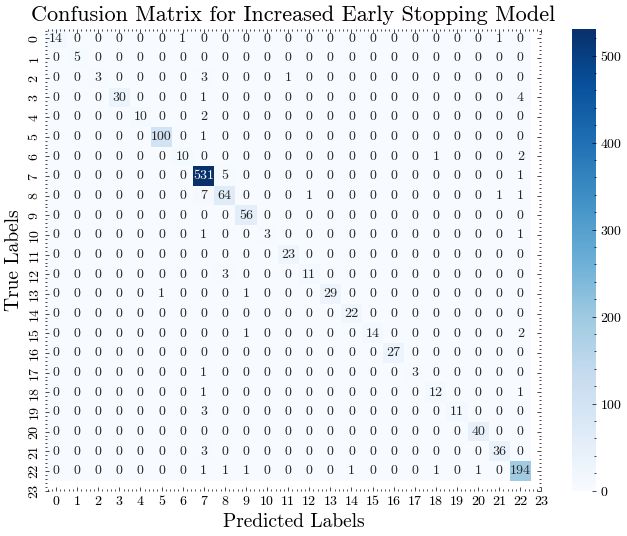

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       1.00      1.00      1.00         5
           2       1.00      0.43      0.60         7
           3       1.00      0.86      0.92        35
           4       1.00      0.83      0.91        12
           5       0.99      0.99      0.99       101
           6       0.91      0.77      0.83        13
           8       0.96      0.99      0.97       537
           9       0.88      0.86      0.87        74
          10       0.95      1.00      0.97        56
          11       1.00      0.60      0.75         5
          12       0.96      1.00      0.98        23
          13       0.92      0.79      0.85        14
          14       1.00      0.94      0.97        31
          15       0.96      1.00      0.98        22
          16       1.00      0.82      0.90        17
          17       1.00      1.00      1.00        27
          18       1.00    

In [95]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = early_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Increased Early Stopping Model", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

## AlexNet Model

In [96]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# Modify the classifier to fit 25 output classes
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=25)

# Define loss function, optimizer, and scheduler
criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Set device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
alexnet = alexnet.to(device)

# Train the model
final_results = train_model(alexnet, train_loader, val_loader, scheduler, 1000, 5)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 83.7MB/s]


Using device: cuda


Training Accuracy: 88.00%

Validation Accuracy: 95.33%



Training Accuracy: 97.60%

Validation Accuracy: 97.70%



Training Accuracy: 97.29%

Validation Accuracy: 97.01%

Early stopping count: 1



Training Accuracy: 99.18%

Validation Accuracy: 98.32%



Training Accuracy: 99.23%

Validation Accuracy: 98.47%



Training Accuracy: 99.62%

Validation Accuracy: 98.39%

Early stopping count: 1



Training Accuracy: 99.62%

Validation Accuracy: 98.32%

Early stopping count: 2



Training Accuracy: 99.54%

Validation Accuracy: 99.16%



Training Accuracy: 99.69%

Validation Accuracy: 98.93%

Early stopping count: 1



Training Accuracy: 99.49%

Validation Accuracy: 98.62%

Early stopping count: 2



Training Accuracy: 99.62%

Validation Accuracy: 99.08%

Early stopping count: 3



Training Accuracy: 99.74%

Validation Accuracy: 98.85%

Early stopping count: 4



Training Accuracy: 99.74%

Validation Accuracy: 98.93%

Early stopping count: 5

Early stopping triggered


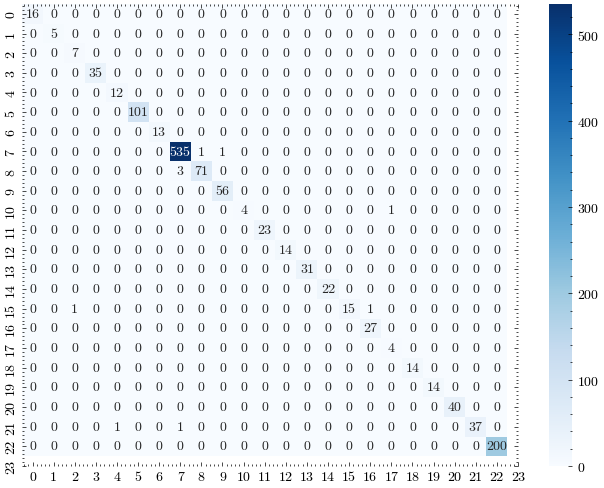

In [97]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.show()

In [98]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00        35
           4       0.92      1.00      0.96        12
           5       1.00      1.00      1.00       101
           6       1.00      1.00      1.00        13
           8       0.99      1.00      0.99       537
           9       0.99      0.96      0.97        74
          10       0.98      1.00      0.99        56
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        31
          15       1.00      1.00      1.00        22
          16       1.00      0.88      0.94        17
          17       0.96      1.00      0.98        27
          18       0.80    

In [99]:
final_results.sort_values(by='Validation Accuracy', ascending=False)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
7,8,0.011668,99.540465,0,99.157734
10,11,0.006942,99.617054,0,99.081164
12,13,0.004191,99.744703,0,98.928025
8,9,0.005189,99.693643,0,98.928025
11,12,0.005906,99.744703,0,98.851455
9,10,0.007441,99.489405,0,98.621746
4,5,0.014707,99.234108,0,98.468606
5,6,0.014261,99.617054,0,98.392037
3,4,0.021567,99.183048,0,98.315467
6,7,0.009344,99.617054,0,98.315467


## Batch Normalization

In [100]:
batch_model = nn.Sequential(
   nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)


criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(batch_model.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
batch_model = batch_model.to(device)

batch_results = train_model(batch_model, train_loader, val_loader, scheduler, 100, 15)

Using device: cuda


Training Accuracy: 47.97%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 66.00%



Training Accuracy: 54.74%

Validation Accuracy: 74.50%



Training Accuracy: 60.56%

Validation Accuracy: 81.93%



Training Accuracy: 66.15%

Validation Accuracy: 82.39%



Training Accuracy: 66.76%

Validation Accuracy: 83.31%



Training Accuracy: 70.64%

Validation Accuracy: 89.36%



Training Accuracy: 72.71%

Validation Accuracy: 88.59%

Early stopping count: 1



Training Accuracy: 73.83%

Validation Accuracy: 89.20%

Early stopping count: 2



Training Accuracy: 73.19%

Validation Accuracy: 89.97%



Training Accuracy: 75.80%

Validation Accuracy: 88.67%

Early stopping count: 1



Training Accuracy: 75.29%

Validation Accuracy: 91.42%



Training Accuracy: 78.45%

Validation Accuracy: 92.27%



Training Accuracy: 80.73%

Validation Accuracy: 92.34%



Training Accuracy: 83.07%

Validation Accuracy: 93.11%



Training Accuracy: 83.20%

Validation Accuracy: 92.80%

Early stopping count: 1



Training Accuracy: 80.04%

Validation Accuracy: 92.19%

Early stopping count: 2



Training Accuracy: 81.06%

Validation Accuracy: 91.81%

Early stopping count: 3



Training Accuracy: 82.33%

Validation Accuracy: 93.26%



Training Accuracy: 82.90%

Validation Accuracy: 92.57%

Early stopping count: 1



Training Accuracy: 84.81%

Validation Accuracy: 93.72%



Training Accuracy: 85.58%

Validation Accuracy: 91.96%

Early stopping count: 1



Training Accuracy: 86.60%

Validation Accuracy: 92.73%

Early stopping count: 2



Training Accuracy: 85.86%

Validation Accuracy: 93.26%

Early stopping count: 3



Training Accuracy: 86.70%

Validation Accuracy: 94.26%



Training Accuracy: 85.60%

Validation Accuracy: 93.57%

Early stopping count: 1



Training Accuracy: 86.93%

Validation Accuracy: 93.95%

Early stopping count: 2



Training Accuracy: 86.26%

Validation Accuracy: 93.95%

Early stopping count: 3



Training Accuracy: 87.77%

Validation Accuracy: 93.72%

Early stopping count: 4



Training Accuracy: 86.80%

Validation Accuracy: 94.26%



Training Accuracy: 88.13%

Validation Accuracy: 93.80%

Early stopping count: 1



Training Accuracy: 87.67%

Validation Accuracy: 93.80%

Early stopping count: 2



Training Accuracy: 87.82%

Validation Accuracy: 94.03%

Early stopping count: 3



Training Accuracy: 86.93%

Validation Accuracy: 93.49%

Early stopping count: 4



Training Accuracy: 87.29%

Validation Accuracy: 94.26%



Training Accuracy: 88.28%

Validation Accuracy: 94.33%



Training Accuracy: 88.92%

Validation Accuracy: 94.26%

Early stopping count: 1



Training Accuracy: 88.87%

Validation Accuracy: 94.18%

Early stopping count: 2



Training Accuracy: 88.92%

Validation Accuracy: 93.72%

Early stopping count: 3



Training Accuracy: 89.69%

Validation Accuracy: 94.18%

Early stopping count: 4



Training Accuracy: 89.10%

Validation Accuracy: 94.79%



Training Accuracy: 89.63%

Validation Accuracy: 94.18%

Early stopping count: 1



Training Accuracy: 90.20%

Validation Accuracy: 94.49%

Early stopping count: 2



Training Accuracy: 89.23%

Validation Accuracy: 94.87%



Training Accuracy: 88.72%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 90.25%

Validation Accuracy: 94.95%



Training Accuracy: 90.66%

Validation Accuracy: 95.02%



Training Accuracy: 91.04%

Validation Accuracy: 94.56%

Early stopping count: 1



Training Accuracy: 89.48%

Validation Accuracy: 93.49%

Early stopping count: 2



Training Accuracy: 86.29%

Validation Accuracy: 93.80%

Early stopping count: 3



Training Accuracy: 87.29%

Validation Accuracy: 94.03%

Early stopping count: 4



Training Accuracy: 88.00%

Validation Accuracy: 93.57%

Early stopping count: 5



Training Accuracy: 90.53%

Validation Accuracy: 94.18%

Early stopping count: 6



Training Accuracy: 89.97%

Validation Accuracy: 94.56%

Early stopping count: 7



Training Accuracy: 91.14%

Validation Accuracy: 94.79%

Early stopping count: 8



Training Accuracy: 90.96%

Validation Accuracy: 94.87%

Early stopping count: 9



Training Accuracy: 89.92%

Validation Accuracy: 94.41%

Early stopping count: 10



Training Accuracy: 90.32%

Validation Accuracy: 94.49%

Early stopping count: 11



Training Accuracy: 90.53%

Validation Accuracy: 95.33%



Training Accuracy: 92.09%

Validation Accuracy: 94.79%

Early stopping count: 1



Training Accuracy: 92.44%

Validation Accuracy: 95.25%

Early stopping count: 2



Training Accuracy: 90.66%

Validation Accuracy: 95.18%

Early stopping count: 3



Training Accuracy: 90.68%

Validation Accuracy: 94.87%

Early stopping count: 4



Training Accuracy: 93.16%

Validation Accuracy: 95.25%

Early stopping count: 5



Training Accuracy: 91.12%

Validation Accuracy: 95.25%

Early stopping count: 6



Training Accuracy: 91.65%

Validation Accuracy: 94.95%

Early stopping count: 7



Training Accuracy: 90.66%

Validation Accuracy: 94.72%

Early stopping count: 8



Training Accuracy: 91.09%

Validation Accuracy: 94.41%

Early stopping count: 9



Training Accuracy: 91.75%

Validation Accuracy: 94.26%

Early stopping count: 10



Training Accuracy: 91.45%

Validation Accuracy: 94.33%

Early stopping count: 11



Training Accuracy: 91.19%

Validation Accuracy: 94.18%

Early stopping count: 12



Training Accuracy: 92.29%

Validation Accuracy: 94.79%

Early stopping count: 13



Training Accuracy: 92.32%

Validation Accuracy: 94.56%

Early stopping count: 14



Training Accuracy: 92.39%

Validation Accuracy: 94.33%

Early stopping count: 15

Early stopping triggered


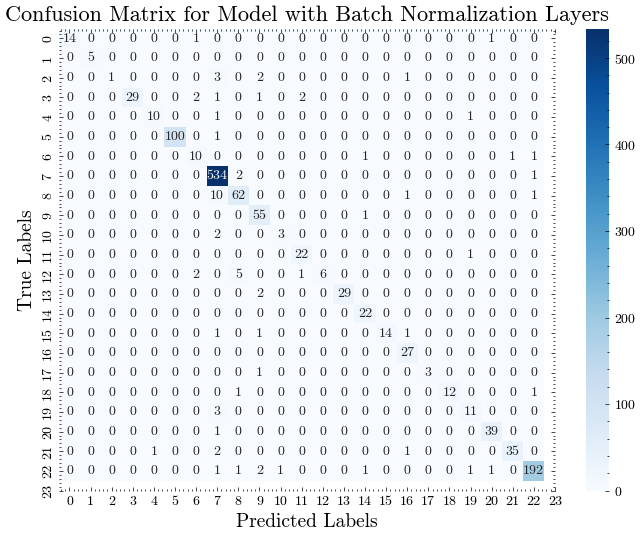

In [101]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = batch_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix for Model with Batch Normalization Layers", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

In [102]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       1.00      1.00      1.00         5
           2       1.00      0.14      0.25         7
           3       1.00      0.83      0.91        35
           4       0.91      0.83      0.87        12
           5       1.00      0.99      1.00       101
           6       0.67      0.77      0.71        13
           8       0.95      0.99      0.97       537
           9       0.87      0.84      0.86        74
          10       0.86      0.98      0.92        56
          11       0.75      0.60      0.67         5
          12       0.88      0.96      0.92        23
          13       1.00      0.43      0.60        14
          14       1.00      0.94      0.97        31
          15       0.88      1.00      0.94        22
          16       1.00      0.82      0.90        17
          17       0.87      1.00      0.93        27
          18       1.00    

In [103]:
batch_results.sort_values(by='Validation Accuracy', ascending=False)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
57,58,0.257178,90.528466,0,95.329250
59,60,0.206834,92.443196,0,95.252680
62,63,0.175944,93.158029,0,95.252680
63,64,0.257131,91.115650,0,95.252680
60,61,0.253534,90.656114,0,95.176110
...,...,...,...,...,...
4,5,1.033231,66.760276,0,83.307810
3,4,1.173259,66.147562,0,82.388974
2,3,1.415035,60.556548,0,81.929556
1,2,1.621784,54.735767,0,74.502297


## Increased Complexity Model

In [104]:
complex_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # New convolutional layer
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(128 * 28 * 28, 128),  # Updated input size due to added conv+pool
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(complex_model.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
complex_model = complex_model.to(device)

complex_results = train_model(complex_model, train_loader, val_loader, scheduler, 100, 15)

Using device: cuda


Training Accuracy: 49.35%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 68.15%



Training Accuracy: 66.40%

Validation Accuracy: 77.11%



Training Accuracy: 75.98%

Validation Accuracy: 82.08%



Training Accuracy: 80.62%

Validation Accuracy: 87.29%



Training Accuracy: 84.86%

Validation Accuracy: 90.28%



Training Accuracy: 88.10%

Validation Accuracy: 91.96%



Training Accuracy: 89.92%

Validation Accuracy: 91.96%



Training Accuracy: 91.42%

Validation Accuracy: 93.26%



Training Accuracy: 92.24%

Validation Accuracy: 92.80%

Early stopping count: 1



Training Accuracy: 93.46%

Validation Accuracy: 94.26%



Training Accuracy: 94.05%

Validation Accuracy: 93.26%

Early stopping count: 1



Training Accuracy: 94.31%

Validation Accuracy: 94.95%



Training Accuracy: 95.35%

Validation Accuracy: 94.33%

Early stopping count: 1



Training Accuracy: 94.51%

Validation Accuracy: 95.18%



Training Accuracy: 95.40%

Validation Accuracy: 94.26%

Early stopping count: 1



Training Accuracy: 95.71%

Validation Accuracy: 95.02%

Early stopping count: 2



Training Accuracy: 96.35%

Validation Accuracy: 95.41%



Training Accuracy: 95.92%

Validation Accuracy: 95.33%

Early stopping count: 1



Training Accuracy: 95.97%

Validation Accuracy: 95.48%



Training Accuracy: 96.48%

Validation Accuracy: 95.71%



Training Accuracy: 97.40%

Validation Accuracy: 95.56%

Early stopping count: 1



Training Accuracy: 96.50%

Validation Accuracy: 94.87%

Early stopping count: 2



Training Accuracy: 96.73%

Validation Accuracy: 94.95%

Early stopping count: 3



Training Accuracy: 97.34%

Validation Accuracy: 95.33%

Early stopping count: 4



Training Accuracy: 97.27%

Validation Accuracy: 95.56%

Early stopping count: 5



Training Accuracy: 97.27%

Validation Accuracy: 95.64%

Early stopping count: 6



Training Accuracy: 97.63%

Validation Accuracy: 95.56%

Early stopping count: 7



Training Accuracy: 97.80%

Validation Accuracy: 95.71%



Training Accuracy: 98.21%

Validation Accuracy: 94.41%

Early stopping count: 1



Training Accuracy: 97.78%

Validation Accuracy: 95.33%

Early stopping count: 2



Training Accuracy: 97.65%

Validation Accuracy: 95.48%

Early stopping count: 3



Training Accuracy: 97.42%

Validation Accuracy: 93.80%

Early stopping count: 4



Training Accuracy: 97.86%

Validation Accuracy: 95.10%

Early stopping count: 5



Training Accuracy: 98.16%

Validation Accuracy: 95.33%

Early stopping count: 6



Training Accuracy: 97.70%

Validation Accuracy: 95.25%

Early stopping count: 7



Training Accuracy: 98.14%

Validation Accuracy: 95.56%

Early stopping count: 8



Training Accuracy: 98.19%

Validation Accuracy: 95.48%

Early stopping count: 9



Training Accuracy: 97.98%

Validation Accuracy: 94.79%

Early stopping count: 10



Training Accuracy: 98.29%

Validation Accuracy: 94.18%

Early stopping count: 11



Training Accuracy: 97.65%

Validation Accuracy: 95.41%

Early stopping count: 12



Training Accuracy: 97.80%

Validation Accuracy: 95.25%

Early stopping count: 13



Training Accuracy: 98.16%

Validation Accuracy: 95.33%

Early stopping count: 14



Training Accuracy: 98.44%

Validation Accuracy: 95.48%

Early stopping count: 15

Early stopping triggered


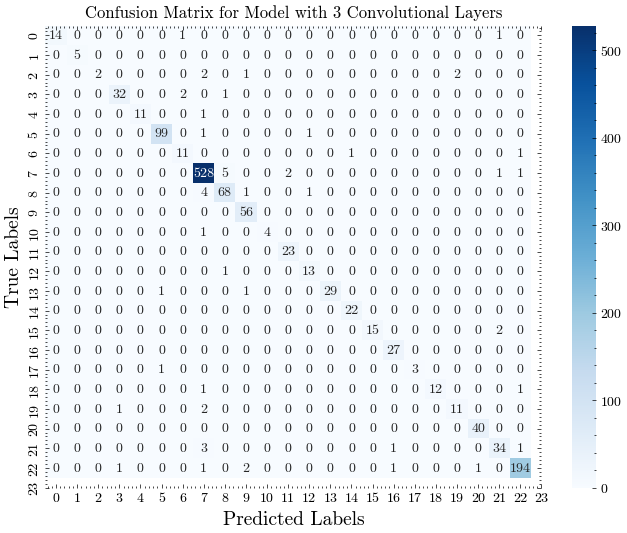

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       1.00      1.00      1.00         5
           2       1.00      0.29      0.44         7
           3       0.94      0.91      0.93        35
           4       1.00      0.92      0.96        12
           5       0.98      0.98      0.98       101
           6       0.79      0.85      0.81        13
           8       0.97      0.98      0.98       537
           9       0.91      0.92      0.91        74
          10       0.92      1.00      0.96        56
          11       1.00      0.80      0.89         5
          12       0.92      1.00      0.96        23
          13       0.87      0.93      0.90        14
          14       1.00      0.94      0.97        31
          15       0.96      1.00      0.98        22
          16       1.00      0.88      0.94        17
          17       0.93      1.00      0.96        27
          18       1.00    

In [105]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = complex_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Model with 3 Convolutional Layers")
plt.show()

print(classification_report(all_labels, all_preds))

In [106]:
complex_results

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,2.127624,49.348992,0,68.147014
1,2,1.323542,66.402859,0,77.105666
2,3,0.879173,75.976513,0,82.082695
3,4,0.607360,80.622926,0,87.289433
4,5,0.485899,84.860863,0,90.275651
5,6,0.377130,88.103140,0,91.960184
6,7,0.311027,89.915752,0,91.960184
7,8,0.259464,91.422007,0,93.261868
8,9,0.226732,92.238958,0,92.802450
9,10,0.175314,93.464386,0,94.257274


In [107]:
complex_model_2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256 * 14 * 14, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(complex_model_2.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
complex_model_2 = complex_model_2.to(device)

complex_results_2 = train_model(complex_model_2, train_loader, val_loader, scheduler, 1000, 15)

Using device: cuda


Training Accuracy: 44.01%



<ipython-input-71-a698f585077d>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Epoch': [epoch+1], 'Train Loss': [train_loss], 'Train Accuracy': [train_acc], 'Validation Loss': [0], 'Validation Accuracy': [val_acc]})], ignore_index=True)


Validation Accuracy: 51.91%



Training Accuracy: 55.37%

Validation Accuracy: 63.40%



Training Accuracy: 63.34%

Validation Accuracy: 75.27%



Training Accuracy: 70.21%

Validation Accuracy: 80.93%



Training Accuracy: 75.64%

Validation Accuracy: 84.38%



Training Accuracy: 80.01%

Validation Accuracy: 86.98%



Training Accuracy: 81.57%

Validation Accuracy: 88.82%



Training Accuracy: 83.38%

Validation Accuracy: 88.28%

Early stopping count: 1



Training Accuracy: 85.86%

Validation Accuracy: 90.58%



Training Accuracy: 86.98%

Validation Accuracy: 90.28%

Early stopping count: 1



Training Accuracy: 88.13%

Validation Accuracy: 90.66%



Training Accuracy: 89.56%

Validation Accuracy: 92.04%



Training Accuracy: 89.97%

Validation Accuracy: 92.96%



Training Accuracy: 91.78%

Validation Accuracy: 93.72%



Training Accuracy: 91.80%

Validation Accuracy: 93.34%

Early stopping count: 1



Training Accuracy: 91.19%

Validation Accuracy: 93.42%

Early stopping count: 2



Training Accuracy: 92.21%

Validation Accuracy: 92.73%

Early stopping count: 3



Training Accuracy: 93.34%

Validation Accuracy: 94.64%



Training Accuracy: 92.70%

Validation Accuracy: 94.18%

Early stopping count: 1



Training Accuracy: 93.31%

Validation Accuracy: 94.03%

Early stopping count: 2



Training Accuracy: 93.87%

Validation Accuracy: 94.56%

Early stopping count: 3



Training Accuracy: 94.08%

Validation Accuracy: 90.20%

Early stopping count: 4



Training Accuracy: 93.90%

Validation Accuracy: 94.56%

Early stopping count: 5



Training Accuracy: 95.00%

Validation Accuracy: 94.18%

Early stopping count: 6



Training Accuracy: 94.56%

Validation Accuracy: 94.79%



Training Accuracy: 94.69%

Validation Accuracy: 95.25%



Training Accuracy: 96.20%

Validation Accuracy: 94.72%

Early stopping count: 1



Training Accuracy: 95.20%

Validation Accuracy: 95.56%



Training Accuracy: 95.38%

Validation Accuracy: 94.18%

Early stopping count: 1



Training Accuracy: 95.10%

Validation Accuracy: 95.41%

Early stopping count: 2



Training Accuracy: 95.53%

Validation Accuracy: 95.25%

Early stopping count: 3



Training Accuracy: 94.46%

Validation Accuracy: 95.64%



Training Accuracy: 95.30%

Validation Accuracy: 91.73%

Early stopping count: 1



Training Accuracy: 95.53%

Validation Accuracy: 95.33%

Early stopping count: 2



Training Accuracy: 96.45%

Validation Accuracy: 94.95%

Early stopping count: 3



Training Accuracy: 96.27%

Validation Accuracy: 95.41%

Early stopping count: 4



Training Accuracy: 96.58%

Validation Accuracy: 95.87%



Training Accuracy: 96.68%

Validation Accuracy: 95.48%

Early stopping count: 1



Training Accuracy: 96.45%

Validation Accuracy: 95.48%

Early stopping count: 2



Training Accuracy: 96.60%

Validation Accuracy: 95.02%

Early stopping count: 3



Training Accuracy: 96.37%

Validation Accuracy: 95.94%



Training Accuracy: 96.27%

Validation Accuracy: 95.25%

Early stopping count: 1



Training Accuracy: 96.78%

Validation Accuracy: 95.48%

Early stopping count: 2



Training Accuracy: 96.78%

Validation Accuracy: 95.33%

Early stopping count: 3



Training Accuracy: 97.06%

Validation Accuracy: 96.02%



Training Accuracy: 97.37%

Validation Accuracy: 96.02%



Training Accuracy: 97.37%

Validation Accuracy: 95.87%

Early stopping count: 1



Training Accuracy: 97.47%

Validation Accuracy: 95.33%

Early stopping count: 2



Training Accuracy: 97.17%

Validation Accuracy: 96.02%



Training Accuracy: 97.40%

Validation Accuracy: 96.17%



Training Accuracy: 97.88%

Validation Accuracy: 95.94%

Early stopping count: 1



Training Accuracy: 97.98%

Validation Accuracy: 95.94%

Early stopping count: 2



Training Accuracy: 97.73%

Validation Accuracy: 96.40%



Training Accuracy: 97.91%

Validation Accuracy: 95.48%

Early stopping count: 1



Training Accuracy: 97.80%

Validation Accuracy: 96.63%



Training Accuracy: 97.55%

Validation Accuracy: 95.64%

Early stopping count: 1



Training Accuracy: 97.73%

Validation Accuracy: 95.64%

Early stopping count: 2



Training Accuracy: 98.21%

Validation Accuracy: 96.71%



Training Accuracy: 98.26%

Validation Accuracy: 95.87%

Early stopping count: 1



Training Accuracy: 97.55%

Validation Accuracy: 93.34%

Early stopping count: 2



Training Accuracy: 97.83%

Validation Accuracy: 96.25%

Early stopping count: 3



Training Accuracy: 98.32%

Validation Accuracy: 96.25%

Early stopping count: 4



Training Accuracy: 98.01%

Validation Accuracy: 96.02%

Early stopping count: 5



Training Accuracy: 98.60%

Validation Accuracy: 95.48%

Early stopping count: 6



Training Accuracy: 98.24%

Validation Accuracy: 96.48%

Early stopping count: 7



Training Accuracy: 98.32%

Validation Accuracy: 95.71%

Early stopping count: 8



Training Accuracy: 98.32%

Validation Accuracy: 96.32%

Early stopping count: 9



Training Accuracy: 98.03%

Validation Accuracy: 96.63%

Early stopping count: 10



Training Accuracy: 98.47%

Validation Accuracy: 96.17%

Early stopping count: 11



Training Accuracy: 98.14%

Validation Accuracy: 96.55%

Early stopping count: 12



Training Accuracy: 98.34%

Validation Accuracy: 96.32%

Early stopping count: 13



Training Accuracy: 98.52%

Validation Accuracy: 96.55%

Early stopping count: 14



Training Accuracy: 98.70%

Validation Accuracy: 95.71%

Early stopping count: 15

Early stopping triggered


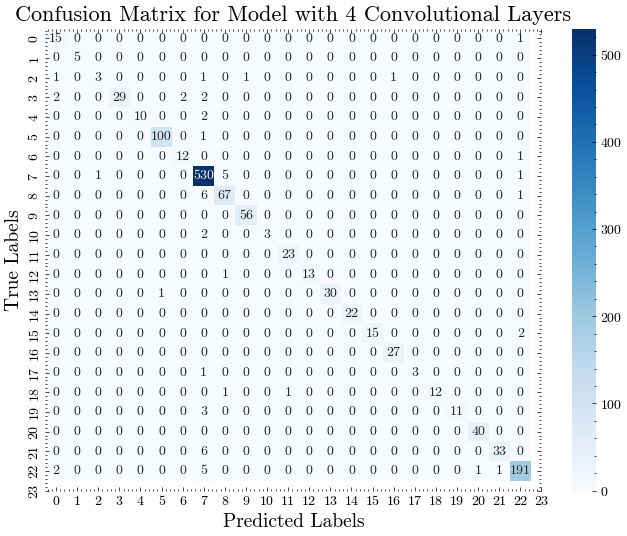

              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       1.00      1.00      1.00         5
           2       0.75      0.43      0.55         7
           3       1.00      0.83      0.91        35
           4       1.00      0.83      0.91        12
           5       0.99      0.99      0.99       101
           6       0.86      0.92      0.89        13
           8       0.95      0.99      0.97       537
           9       0.91      0.91      0.91        74
          10       0.98      1.00      0.99        56
          11       1.00      0.60      0.75         5
          12       0.96      1.00      0.98        23
          13       1.00      0.93      0.96        14
          14       1.00      0.97      0.98        31
          15       1.00      1.00      1.00        22
          16       1.00      0.88      0.94        17
          17       0.96      1.00      0.98        27
          18       1.00    

In [108]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = complex_model_2(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix for Model with 4 Convolutional Layers", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

In [109]:
complex_results_2.sort_values(by='Validation Accuracy', ascending=False)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
57,58,0.047394,98.212918,0,96.707504
54,55,0.058343,97.804442,0,96.630934
67,68,0.049781,98.034210,0,96.630934
69,70,0.054653,98.136329,0,96.554364
71,72,0.031019,98.519275,0,96.554364
...,...,...,...,...,...
4,5,0.827984,75.644626,0,84.379786
3,4,1.052419,70.206791,0,80.934150
2,3,1.322587,63.339290,0,75.267994
1,2,1.768677,55.374011,0,63.399694


In [110]:
complex_model_3 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),

    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 25)
)

criteria = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(complex_model_3.parameters(), lr=0.0001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
complex_model_3 = complex_model_3.to(device)

complex_results_3 = train_model(complex_model_3, train_loader, val_loader, scheduler, 1000, 15)


Using device: cuda


Training Accuracy: 36.43%

Validation Accuracy: 49.92%



Training Accuracy: 51.77%

Validation Accuracy: 57.73%



Training Accuracy: 60.56%

Validation Accuracy: 68.38%



Training Accuracy: 66.63%

Validation Accuracy: 75.50%



Training Accuracy: 71.43%

Validation Accuracy: 80.47%



Training Accuracy: 75.11%

Validation Accuracy: 82.47%



Training Accuracy: 78.73%

Validation Accuracy: 88.44%



Training Accuracy: 80.55%

Validation Accuracy: 88.44%



Training Accuracy: 82.64%

Validation Accuracy: 89.20%



Training Accuracy: 83.51%

Validation Accuracy: 89.59%



Training Accuracy: 85.96%

Validation Accuracy: 91.50%



Training Accuracy: 87.31%

Validation Accuracy: 92.34%



Training Accuracy: 88.00%

Validation Accuracy: 92.04%

Early stopping count: 1



Training Accuracy: 88.23%

Validation Accuracy: 92.27%

Early stopping count: 2



Training Accuracy: 89.12%

Validation Accuracy: 93.80%



Training Accuracy: 89.05%

Validation Accuracy: 93.03%

Early stopping count: 1



Training Accuracy: 90.71%

Validation Accuracy: 93.26%

Early stopping count: 2



Training Accuracy: 91.45%

Validation Accuracy: 92.73%

Early stopping count: 3



Training Accuracy: 91.75%

Validation Accuracy: 93.19%

Early stopping count: 4



Training Accuracy: 91.22%

Validation Accuracy: 93.80%



Training Accuracy: 92.37%

Validation Accuracy: 94.56%



Training Accuracy: 93.39%

Validation Accuracy: 94.72%



Training Accuracy: 93.95%

Validation Accuracy: 94.72%



Training Accuracy: 93.31%

Validation Accuracy: 95.18%



Training Accuracy: 94.49%

Validation Accuracy: 95.10%

Early stopping count: 1



Training Accuracy: 95.40%

Validation Accuracy: 95.33%



Training Accuracy: 95.07%

Validation Accuracy: 95.56%



Training Accuracy: 94.66%

Validation Accuracy: 94.49%

Early stopping count: 1



Training Accuracy: 94.31%

Validation Accuracy: 95.41%

Early stopping count: 2



Training Accuracy: 95.76%

Validation Accuracy: 95.33%

Early stopping count: 3



Training Accuracy: 96.04%

Validation Accuracy: 95.87%



Training Accuracy: 96.76%

Validation Accuracy: 96.02%



Training Accuracy: 96.58%

Validation Accuracy: 96.02%



Training Accuracy: 96.89%

Validation Accuracy: 96.17%



Training Accuracy: 96.45%

Validation Accuracy: 96.02%

Early stopping count: 1



Training Accuracy: 97.45%

Validation Accuracy: 96.02%

Early stopping count: 2



Training Accuracy: 95.86%

Validation Accuracy: 94.95%

Early stopping count: 3



Training Accuracy: 97.09%

Validation Accuracy: 94.87%

Early stopping count: 4



Training Accuracy: 97.01%

Validation Accuracy: 95.94%

Early stopping count: 5



Training Accuracy: 95.81%

Validation Accuracy: 95.02%

Early stopping count: 6



Training Accuracy: 97.24%

Validation Accuracy: 95.87%

Early stopping count: 7



Training Accuracy: 97.37%

Validation Accuracy: 95.33%

Early stopping count: 8



Training Accuracy: 96.83%

Validation Accuracy: 94.41%

Early stopping count: 9



Training Accuracy: 96.45%

Validation Accuracy: 95.25%

Early stopping count: 10



Training Accuracy: 96.40%

Validation Accuracy: 95.79%

Early stopping count: 11



Training Accuracy: 96.96%

Validation Accuracy: 95.71%

Early stopping count: 12



Training Accuracy: 97.42%

Validation Accuracy: 95.94%

Early stopping count: 13



Training Accuracy: 98.03%

Validation Accuracy: 96.25%



Training Accuracy: 97.98%

Validation Accuracy: 96.55%



Training Accuracy: 98.11%

Validation Accuracy: 96.32%

Early stopping count: 1



Training Accuracy: 98.11%

Validation Accuracy: 96.17%

Early stopping count: 2



Training Accuracy: 97.93%

Validation Accuracy: 96.55%



Training Accuracy: 97.63%

Validation Accuracy: 96.40%

Early stopping count: 1



Training Accuracy: 97.55%

Validation Accuracy: 96.32%

Early stopping count: 2



Training Accuracy: 98.06%

Validation Accuracy: 96.63%



Training Accuracy: 98.14%

Validation Accuracy: 96.48%

Early stopping count: 1



Training Accuracy: 98.32%

Validation Accuracy: 97.09%



Training Accuracy: 97.86%

Validation Accuracy: 96.63%

Early stopping count: 1



Training Accuracy: 98.09%

Validation Accuracy: 95.94%

Early stopping count: 2



Training Accuracy: 98.70%

Validation Accuracy: 96.25%

Early stopping count: 3



Training Accuracy: 98.83%

Validation Accuracy: 96.32%

Early stopping count: 4



Training Accuracy: 97.75%

Validation Accuracy: 96.48%

Early stopping count: 5



Training Accuracy: 97.93%

Validation Accuracy: 95.02%

Early stopping count: 6



Training Accuracy: 97.70%

Validation Accuracy: 96.32%

Early stopping count: 7



Training Accuracy: 98.39%

Validation Accuracy: 96.55%

Early stopping count: 8



Training Accuracy: 98.47%

Validation Accuracy: 96.55%

Early stopping count: 9



Training Accuracy: 98.32%

Validation Accuracy: 96.48%

Early stopping count: 10



Training Accuracy: 99.00%

Validation Accuracy: 95.94%

Early stopping count: 11



Training Accuracy: 98.52%

Validation Accuracy: 96.71%

Early stopping count: 12



Training Accuracy: 98.44%

Validation Accuracy: 96.17%

Early stopping count: 13



Training Accuracy: 98.65%

Validation Accuracy: 96.63%

Early stopping count: 14



Training Accuracy: 98.72%

Validation Accuracy: 96.25%

Early stopping count: 15

Early stopping triggered


In [111]:
complex_results_3

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,2.614402,36.430942,0,49.923430
1,2,2.023197,51.774317,0,57.733538
2,3,1.592327,60.556548,0,68.376723
3,4,1.222534,66.632627,0,75.497703
4,5,1.018195,71.432219,0,80.474732
...,...,...,...,...,...
67,68,0.021001,99.004340,0,95.941807
68,69,0.040518,98.519275,0,96.707504
69,70,0.051172,98.442686,0,96.171516
70,71,0.025514,98.646924,0,96.630934


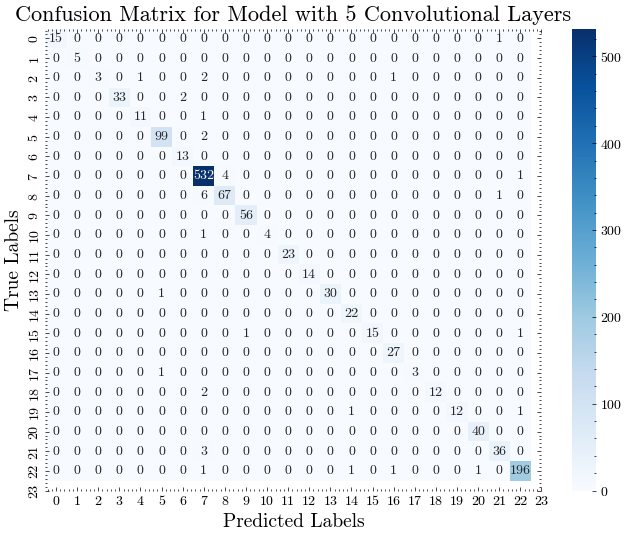

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       1.00      1.00      1.00         5
           2       1.00      0.43      0.60         7
           3       1.00      0.94      0.97        35
           4       0.92      0.92      0.92        12
           5       0.98      0.98      0.98       101
           6       0.87      1.00      0.93        13
           8       0.97      0.99      0.98       537
           9       0.94      0.91      0.92        74
          10       0.98      1.00      0.99        56
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        14
          14       1.00      0.97      0.98        31
          15       0.92      1.00      0.96        22
          16       1.00      0.88      0.94        17
          17       0.93      1.00      0.96        27
          18       1.00    

In [112]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = complex_model_3(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(24), yticklabels=range(24))
plt.title("Confusion Matrix for Model with 5 Convolutional Layers", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

print(classification_report(all_labels, all_preds))

## Model Analysis

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(initial_model, input_size=(1, 3, 224, 224), expand_nested=False)
model_graph.visual_graph.render("model_architecture_inital", format="png")

In [ ]:

model_graph = draw_graph(complex_model_3, input_size=(1, 3, 224, 224), expand_nested=False)
model_graph.visual_graph.render("model_architecture_final", format="png")

In [ ]:
from torchsummary import summary
summary(complex_model_3, input_size=(3, 224, 224))